In [ ]:
!pip install yahoofinancials
!pip install pandas-ta
!pip install catboost
!pip install costcla


In [4]:
#IMPORT CLASSIFIERS
#IMPORT CLASSIFIERS
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from costcla.models import CostSensitiveRandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#IMPORT OTHERS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st
import pandas_ta as ta
import time
import warnings
import itertools
import hyperopt as hp

from collections import OrderedDict 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate
from datetime import datetime
from yahoofinancials import YahooFinancials
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split,  cross_val_score, KFold, cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore", category=FutureWarning)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 

In [30]:
# THIS ONE FOR CONFUSION MATRIX
def plot_confusion_matrix(cm,
                          target_names, 
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



#PLOT HP AFFECTS AND CHANGE OVER TIME
def plot_param_vs_time( param_name ):
    f, ax = plt.subplots(1)
    xs = [t['tid'] for t in trials_obj.trials]
    ys = [t['misc']['vals'][ param_name ] for t in trials_obj.trials]
    ax.set_xlim(xs[0]-10, xs[-1]+10)
    ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
    ax.set_title('$' + param_name +'$ $vs$ $t$ ', fontsize=18)
    ax.set_xlabel('$t$', fontsize=16)
    ax.set_ylabel('$' + param_name +'$', fontsize=16)
    plt.show()

def plot_loss_vs_param( param_name ):
    f, ax = plt.subplots(1)
    xs = [t['misc']['vals'][ param_name ] for t in trials_obj.trials]
    ys = [t['result']['loss'] for t in trials_obj.trials]
    ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
    ax.set_title('$val$ $vs$ $' + param_name + '$ ', fontsize=18)
    ax.set_xlabel('$' + param_name + '$', fontsize=16)
    ax.set_ylabel('$val$', fontsize=16)
    plt.show()




In [16]:
class HELP():
    def __init__( self ):
        self.classifier_list = [ ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, SVC, MLPClassifier, KNeighborsClassifier,
                                CatBoostClassifier, LGBMClassifier,  XGBClassifier, StackingCVClassifier,
                                CostSensitiveRandomForestClassifier ]

        self.classifier_list_str = [ 'ExtraTreesClassifier','RandomForestClassifier', 'AdaBoostClassifier',
                                'GradientBoostingClassifier', 'SVC', 'MLPClassifier', 'KNeighborsClassifier',
                                'CatBoostClassifier', 'LGBMClassifier',  'XGBClassifier', 'StackingCVClassifier',
                                'CostSensitiveRandomForestClassifier' ]

        #self.class_list_spike = list()
        #self.class_list_crash = list()
        #self.class_key_spike = list()
        #self.class_key_crash = list()
        #self.last_x_days = last_x_days
        #self.cycle = cycle
        #self.counter = 0
        #self.counter_max = last_x_days // cycle -1 if last_x_days % cycle == 0 else last_x_days // cycle 
        #self.last_cycle = self.cycle if last_x_days % cycle == 0 else last_x_days % cycle
        #self.preprocess()
        #self.define_classes( return_days, multicollinearity )
        #self.DATE_TEST = self.DATE_ALL_DATA.iloc[ -last_x_days : ]
        #self.TEST_RETURNS = self.ALL_RETURNS[ -last_x_days : ]

    def preprocess( self ):
        print('\n PREPROCESSING \n')

        ticker_details = pd.read_excel('Ticker List.xlsx')
        ticker = ticker_details['Ticker'].to_list()
        names = ticker_details['Description'].to_list()

        #Extracting Data from Yahoo Finance and Adding them to Values table using date as key
        end_date= "2020-06-19"
        start_date = "2000-01-01"
        date_range = pd.bdate_range(start=start_date,end=end_date)
        values = pd.DataFrame({ 'Date': date_range})
        values['Date']= pd.to_datetime(values['Date'])

        #Extracting Data from Yahoo Finance and Adding them to Values table using date as key
        for i in ticker:
            raw_data = YahooFinancials(i)
            raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
            df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
            df.columns = ['Date1',i]
            df['Date1']= pd.to_datetime(df['Date1'])
            values = values.merge(df,how='left',left_on='Date',right_on='Date1')
            values = values.drop(labels='Date1',axis=1)
        self.VV = values

        #Renaming columns to represent instrument names rather than their ticker codes for ease of readability
        names.insert(0,'Date')
        values.columns = names
        values.tail()


        #Front filling the NaN values in the data set
        values = values.fillna(method="ffill",axis=0)
        values = values.fillna(method="bfill",axis=0)
        values.isna().sum()

        #Return
        values['SPX-RSI'] = ta.rsi( values['SPX'] )

        BBANDS = ta.bbands( values['SPX'] )
        keys = BBANDS.keys().to_list()

        Upper = BBANDS[ 'BBU_5' ]
        Lower = BBANDS[ 'BBL_5' ]

        Upper_perc = Upper / values['SPX']
        Lower_perc = Lower / values['SPX']

        values[ 'BBU-Distance' ] = Upper_perc
        values[ 'BBL-Distance' ] = Lower_perc
        values['MACD-Histogram'] = ta.macd( values[ 'SPX' ] )[ 'MACDH_12_26_9' ]
        # Co-ercing numeric type to all columns except Date
        cols=values.columns.drop('Date')
        values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=4)
        #print(values.tail())

        imp = ['Gold','USD Index', 'Oil', 'SPX','VIX', 'High Yield Fund' , 'Nikkei', 'Dax', '10Yr', '2Yr' , 'EEM' ,'XLE', 'XLF', 'XLI', 'AUDJPY']
        # Calculating Short term -Historical Returns
        change_days = [1,3,5,14,21]
        
        data = pd.DataFrame(data=values['Date'])
        for i in change_days:
            x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
            data=pd.concat(objs=(data,x),axis=1)
            x=[]



        # Calculating Long term Historical Returns
        change_days = [60,90,180,250]

        for i in change_days:
            x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
            data=pd.concat(objs=(data,x),axis=1)
            x=[]

        #Calculating Moving averages for SPX
        moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
        moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
        moving_avg['SPX/15SMA'] = (values['SPX']/(values['SPX'].rolling(window=15).mean()))-1
        moving_avg['SPX/30SMA'] = (values['SPX']/(values['SPX'].rolling(window=30).mean()))-1
        moving_avg['SPX/60SMA'] = (values['SPX']/(values['SPX'].rolling(window=60).mean()))-1
        moving_avg['SPX/90SMA'] = (values['SPX']/(values['SPX'].rolling(window=90).mean()))-1
        moving_avg['SPX/180SMA'] = (values['SPX']/(values['SPX'].rolling(window=180).mean()))-1
        moving_avg['SPX/90EMA'] = (values['SPX']/(values['SPX'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
        moving_avg['SPX/180EMA'] = (values['SPX']/(values['SPX'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
        moving_avg = moving_avg.dropna(axis=0)
        #Merging Moving Average values to the feature space
        data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')


        self.RAW_data = pd.merge(left=data,right=moving_avg,how='left',on='Date')

        self.RAW_y = pd.DataFrame(data=values['Date'])

        self.RAW_values = values

    def mult( self, data, threshold, TARGET = 'SPX' ):
        keys = data.keys().to_list()
        corr = data.corr()
        target_set = corr[ TARGET ]
        drop_list = list()
        
        #loop over features in corr matrix except SPX
        for i, key in enumerate(keys):
            if key != TARGET:
                
                print('EXAMINING {} \n '.format( key ) )
                print('DROP_LIST {} \n'.format( drop_list ) )
                #Get 'abs' corr values of current feature 
                values = corr[ key ]
                
                #we wont control corr between feature and [ SPX, features itself ] 
                #we will also skip dropped features in the next loop
                skip_list = [ TARGET, key ]

                #since skip_list will be updated for each feature
                #we save dropped features in drop_list to append it 
                #while exploring each feature
                if len( drop_list ) > 0:
                    #drop if drop_list is not empty
                    skip_list.extend( drop_list )

                print('SKIP LIST {} \n'.format( skip_list ) )
                #we will loop over 
                for k, ind in enumerate(keys):
                    #skip features in skip_list
                    if ind not in skip_list:

                        print(ind)
                        print(ind)
                        #if corr between 2 features exceeds threshold
                        if abs( values[ k ] ) > threshold:
                            print( values[ k ] )
                            #check which one is more corr to target
                            if corr[ TARGET ][ key ] > corr[ TARGET ][ ind ]:
                                #drop the other one
                                data = data.drop( ind, axis = 1 )
                                #append dropped feature's key to drop_list
                                drop_list.append( ind )
                                print('DROPPED {} \n '.format( ind ))
                            elif key not in drop_list:
                                #inverse of the 'statement' above
                                data = data.drop( key, axis = 1 )
                                drop_list.append( key )
                                print('DROPPED {} \n '.format( key ))
                                break

        return data, drop_list
                    
            
    def define_classes( self, return_days, multicollinearity ):
        print('\n DEFINING CLASSES \n')
        y = self.RAW_y
        values = self.RAW_values
        data = self.RAW_data
        
        y[ 'SPX-Target' ] = values[ "SPX" ].pct_change( periods = -return_days )
        y.isna().sum()

        # Removing NAs
        data = data[ data[ 'SPX-T-250' ].notna() ]
        y = y[ y[ 'SPX-Target' ].notna() ]

        #Adding Target Variables
        data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
        data.isna().sum()
        
        #Select Threshold p (left tail probability)
        p1 = 0.25
        p2 = 0.75
        #Get z-Value
        z1 = st.norm.ppf( p1 )
        z2 = st.norm.ppf( p2 )
       
        #Calculating Threshold (t) for each Y
        crash = round( (z1 * np.std( data[ "SPX-Target" ] ) ) + np.mean( data[ "SPX-Target" ] ), 5 )
        spike = round( (z2 * np.std( data[ "SPX-Target" ] ) ) + np.mean( data[ "SPX-Target" ] ), 5 )
        
        #Creating Labels
        data[ 'Y-Crash' ] = ( data[ 'SPX-Target' ] < crash ) * 1
        data[ 'Y-Spike' ] = ( data[ 'SPX-Target' ] > spike ) * 1

        #Save Dates
        self.DATE_ALL_DATA = data[ 'Date' ]
        last_values = values[ values[ 'Date' ] <= data[ 'Date' ].iloc[ -1 ] ]
        self.ALL_RETURNS = list()

        #Calculate cash returns
        RATES = data[ 'SPX-Target' ].to_list()
        CLOSE = last_values[ 'SPX' ].to_list()

        for i in range( len( data[ 'SPX-Target' ] ) ):
            self.ALL_RETURNS.append( RATES[ i ] * CLOSE[ i ] )

        #Prepare df for vif calculation
        no_target_data =  data.drop( [ 'SPX-Target', 'Date', 'Y-Crash', 'Y-Spike'  ], axis = 1 )
        #calculate vif
        self.vif_scores = self.variance_inflation_factors( no_target_data )
        #get feature names which vif > 10
        inds = (self.vif_scores > 10 ).index
        droplist = inds[ self.vif_scores > 10 ]

        if multicollinearity == True:
            data = data.drop( droplist, axis = 1 )

        #For now, data has Spike and Crash labels 
        self.data = data.drop( [ 'SPX-Target', 'Date'], axis = 1 )
        

    def variance_inflation_factors( self, exog_df ):

        exog_df = add_constant(exog_df)
        vifs = pd.Series(
            [1 / (1. - OLS(exog_df[col].values, 
                          exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
            for col in exog_df],
            index=exog_df.columns,
            name='VIF'
        )
        return vifs


    def select_classifier( self, classifier, key ):
        #for ELEM in self.classifier_list_str:
        #    if classifier == ELEM[ : len( classifier )  ]: 
        #        self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ) ]
        if key == 'crash':
            if classifier == 'EXT':
                self.class_list_crash.append( ExtraTreesClassifier( n_estimators = 300, random_state = 0 ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

            elif classifier == 'GB':
                self.class_list_crash.append( GradientBoostingClassifier( random_state = 0 ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )
                    
            elif classifier == 'CB':
                self.class_list_crash.append( CatBoostClassifier() )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

            elif classifier == 'STCK':
                est_list = list()
                for i in range( len( self.class_list_crash ) ):
                    est_list.append( ( self.class_key_crash[ i ], self.class_list_crash[ i ]  ) )
                self.class_list_crash.append( StackingClassifier(estimators = est_list,  cv = 5, final_estimator = CatBoostClassifier() ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

        elif key == 'spike':
            if classifier == 'EXT':
                self.class_list_spike.append( ExtraTreesClassifier( n_estimators = 300, random_state = 0 ) )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'GB':
                self.class_list_spike.append( GradientBoostingClassifier( random_state = 0 ) )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'CB':
                self.class_list_spike.append( CatBoostClassifier() )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'STCK':
                est_list = list()
                for i in range( len(self.class_list_spike) ):
                    est_list.append( ( self.class_key_spike[ i ], self.class_list_spike[ i ]  ) )
                self.class_list_spike.append( StackingClassifier( estimators = est_list,  cv = 5, final_estimator = CatBoostClassifier() ) ) 

                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

    def backtest(self):
        list_of_cash_tt = list()
        self.make_pred( for_valid = False )
        classifiers = self.BT_RESULTS.keys().to_list()
        count = 0
        for CCC in classifiers:
            if CCC != 'Target':
                temp_cash = list()
                temp_cash.append( 0 )
                cc = 0

                preds = self.BT_RESULTS[ CCC ].to_list()

                assert len( preds ) ==  len( self.TEST_RETURNS )

                for i in range( len( preds ) ):
                    if preds[ i ] == 1:
                        cc += -self.TEST_RETURNS[ i ]
                    temp_cash.append( cc )

                if count == 0:
                    CASH = pd.DataFrame( { CCC: temp_cash  })
                    count += 1
                else:
                    CASH[ CCC ] = temp_cash
                    count += 1

        self.CASH = CASH
      


    def scores( self, typez ):
        if typez == 'crash':
            results = self.results_crash
        else:
            results = self.results_spike

        KEYS = results.keys().to_list()
        counter = 0
        for  key in KEYS:
            if key != 'Target':
                score_list = list()
                for metric in self.metrics:
                    score_list.append( metric( results[ 'Target' ], results[ key ] ) )

                if counter == 0:
                    scores = pd.DataFrame( { key: score_list  })
                    counter = counter + 1
                else:
                    scores[ key ] = score_list
                    counter = counter + 1

        if typez == 'crash':
            self.scores_crash = scores
        else:
            self.scores_spike = scores



    def redefine_classifiers( self ):
        self.class_list_spike = list()
        self.class_list_crash = list()
        for classifier in self.class_key_spike:
            self.select_classifier( classifier, 'spike' )
        for classifier in self.class_key_crash:
            self.select_classifier( classifier, 'crash' )


    def retrain( self ):

        for i in range( self.counter_max + 1 ):
            start_time = time.time()
            print( '\n TRAIN # {} \n'.format( i ) )
            self.update_data()
            self.redefine_classifiers()
            for classifier in self.class_list_spike:
                classifier.fit( self.X_train_spike, self.y_train_spike )

            for classifier in self.class_list_crash:
                classifier.fit( self.X_train_crash, self.y_train_crash )
            print('FINISHED {} \n '.format( i ) )
            print('Lasts : {} \n' .format(time.time() - start_time))

            self.make_pred( typez = 'crash' )
            self.make_pred( typez = 'spike' )
            self.counter += 1


    def smotetomek( self, X_train, y_train ):
        smt = SMOTETomek( random_state = 21 )
        return smt.fit_sample( X_train, y_train )


    def update_data( self ):

        #Update train-test split after every cycle time
        #if it is last cycle, use remaining days as test data
        if self.counter_max == self.counter:
            TEST_data = self.data.iloc[ -self.last_x_days + self.counter * self.cycle : ]
            TRAIN_data = self.data.iloc[ : -self.last_x_days + self.counter * self.cycle ]
        else:
            TEST_data = self.data.iloc[ -self.last_x_days + self.counter * self.cycle : -self.last_x_days + self.counter * self.cycle + self.cycle ]
            TRAIN_data = self.data.iloc[ : -self.last_x_days + self.counter * self.cycle ]


        #Create Training set and crash-spike labels
        X_train = TRAIN_data.drop( ['Y-Crash', 'Y-Spike'], axis = 1 )
        y_train_crash = TRAIN_data[ 'Y-Crash' ]
        y_train_spike = TRAIN_data[ 'Y-Spike' ]

        #Create test sets
        self.X_test = TEST_data.drop( [ 'Y-Spike', 'Y-Crash' ], axis = 1 )
        self.y_test_crash = TEST_data[ 'Y-Crash' ]
        self.y_test_spike = TEST_data[ 'Y-Spike' ]

        #Scale data between 0-1
        mm = MinMaxScaler()
        mm = mm.fit( X_train )
        X_train = mm.transform( X_train )
        self.X_test = mm.transform( self.X_test )

        #Create samples with smotetomek to eliminate imbalance of positive instances
        self.X_train_crash, self.y_train_crash = self.smotetomek( X_train, y_train_crash )
        self.X_train_spike, self.y_train_spike = self.smotetomek( X_train, y_train_spike )


    def make_pred( self, typez ):
        XXX = self.X_test
        if typez == 'crash':
            TARGET = self.y_test_crash
            classifiers = self.class_list_crash
            class_keys = self.class_key_crash
        else:
            TARGET = self.y_test_spike
            classifiers = self.class_list_spike
            class_keys = self.class_key_spike

        for i, classifier in enumerate( classifiers ):
            temp = classifier.predict( XXX )
            if i == 0:
                results = pd.DataFrame( { 'Target': TARGET, class_keys[ i ] : temp } )
            else:
                results[ class_keys[ i ] ] = temp
       

        if typez == 'crash':
            if self.counter == 0:
                self.results_crash = results
            else:
                self.results_crash = self.results_crash.append( results )

        else:
            if self.counter == 0:
                self.results_spike = results
            else:

                self.results_crash = self.results_crash.append( results )


    def confusion_matrix( self, classifier, key ):
        if key == 'crash':
            pred = self.results_crash[ classifier ]
            true = self.results_crash[ 'Target' ]
            return confusion_matrix( true, pred )
        elif key == 'spike':
            pred = self.results_spike[ classifier ]
            true = self.results_spike[ 'Target' ]
            return confusion_matrix( true, pred )




    def confusion_matrix( self ):
        pred = self.optimizer( self.X_test )
        true = self.y_test
        cm = np.array(confusion_matrix( true, pred ))
        plot_confusion_matrix( cm = cm, target_names = [ 'nothing', 'spike' ] )



In [33]:
class Tuner( HELP ):
    def __init__( self, multicollinearity = False, typez = 'spike' ):
        super().__init__()

        self.metrics = [ f1_score, precision_score, roc_auc_score ]
        self.metircs_key = [ 'f1', 'precision', 'roc_auc']
        self.classifier_list = [ ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, SVC, MLPClassifier, KNeighborsClassifier,
                                CatBoostClassifier, LGBMClassifier,  XGBClassifier, StackingCVClassifier,
                                CostSensitiveRandomForestClassifier ]

        self.classifier_list_str = [ 'ExtraTreesClassifier','RandomForestClassifier', 'AdaBoostClassifier',
                                'GradientBoostingClassifier', 'SVC', 'MLPClassifier', 'KNeighborsClassifier',
                                'CatBoostClassifier', 'LGBMClassifier',  'XGBClassifier', 'StackingCVClassifier',
                                'CostSensitiveRandomForestClassifier' ]
        self.typez = typez

    def choose_classifier( self, classifier, backtest = False ):
        self.class_key = classifier
        for ELEM in self.classifier_list_str:
            if classifier == ELEM[ : len( classifier )  ]: 
                if backtest:
                    self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]( **self.best_params )
                else:
                    self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]()


    def classifier_to_tune( self, classifier, backtest = False ):
        self.class_key = classifier
        for ELEM in self.classifier_list_str:
            if classifier == ELEM[ : len( classifier )  ]: 
                self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]


    def scale( self, X_train, X_test, scale_type = 'minmax' ):
        if scale_type == 'minmax':
            scaler = MinMaxScaler()
        elif scale_type == 'robust':
            scaler = RobustScaler()
        elif scale_type == 'standard':
            scaler = StandardScaler()
        elif scale_type == 'maxabs':
            scaler = MaxAbsScaler()

        scaler = scaler.fit( X_train )
        X_train = scaler.transform( X_train )
        X_test = scaler.transform( X_test )
        
        return X_train, X_test

    def cash_test( self, preds ):
        cash = [ 0 for i in range( 13 ) ]
        CASHH = 0
        cash_gt = [ 0 for i in range( 13 ) ]
        CASHH_GT = 0
        test_ret_values = list( self.TEST_RETURNS )
        self.y_test = list(self.y_test)
        for i in range( len( preds ) ):
            CASHH = CASHH + test_ret_values[ i ] * preds[ i ]
            cash.append( CASHH )
            CASHH_GT = CASHH_GT + test_ret_values[ i ] * self.y_test[ i ]
            cash_gt.append( CASHH_GT )
        return cash, cash_gt


    def prepare_data( self, smotetomek = True, b_test = False, test_percent = 0.3 ):
        shuffle = True
        data = self.data
            
        X = data.drop( ['Y-Crash', 'Y-Spike'], axis = 1 )

        if self.typez == 'crash':
            y = data[ 'Y-Crash' ]
        else:
            y = data[ 'Y-Spike' ]

        stratify = y

        if b_test:
            shuffle = False
            stratify = None
        
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = test_percent, random_state = 42, shuffle = shuffle, stratify = stratify )

        if smotetomek:
            X_train, y_train = self.smotetomek( X_train, y_train )

        X_train, X_test = self.scale( X_train, X_test )
        
        return X_train, X_test, y_train, y_test


    def process_data(self, return_days = 14, multicollinearity = False,
                     smotetomek = True, b_test = False, test_percent = 0.2 ):
      
        self.preprocess()
        self.define_classes( return_days, multicollinearity )
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data( smotetomek = smotetomek,
                                                                                  b_test = b_test,
                                                                                  test_percent = test_percent)
        self.TEST_RETURNS = self.ALL_RETURNS[ -len( self.y_test ) : ]
        self.TEST_DATES = self.DATE_ALL_DATA[ -len( self.y_test ) : ]


    def print_class_options( self ):
        for elem in self.classifier_list_str:
            print('{} \n'.format( elem ) )


    def train_tuned( self, multicollinearity = False ):
        self.process_data( b_test = True, test_percent = 0.1 )
        self.classifier.fit( self.X_train, self.y_train )
        preds = self.classifier.predict( self.X_test )
        print( ' \n ============SCORE============ \n {}'.format( f1_score(self.y_test, preds) ) )
        cash, cash_gt = self.cash_test( preds )
        return cash, cash_gt, preds

#    def weight_function( self ):
#        num_of_classes = len( self.classifier.classes_ )
        
#std: 10 30 60 90 180

#knn: num_of_class, weights, leaf_size, p
#ext: est_range, criterion, features, depth, leaf_size_range
#lgbm: est_range, boosting(gbdt, dark), leaf_size_range, max_depth, n_est


In [18]:
class HPOpt(Tuner):

    def __init__(self, rosemary ):
        self.X_train = rosemary.X_train
        self.X_test  = rosemary.X_test
        self.y_train = rosemary.y_train
        self.y_test  = rosemary.y_test
        self.classifier = rosemary.classifier

        self.dtypez = {  
                      'n_estimators' : int,
                      'num_leaves': int
                       }


    def process(self, fn_name, space, trials, algo, max_evals):
      
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        return result, trials


    def objective( self, args ):
        args = self.input_converter( args )
        clf = self.classifier( **args )
        clf.fit( self.X_train, self.y_train )
        pred = clf.predict( self.X_test )
        score = f1_score( self.y_test, pred )
        print( '\n ============================ \n {} \n ============================ \n'.format(score ))
        cm = np.array(confusion_matrix( self.y_test, pred ))
        plot_confusion_matrix( cm = cm, target_names = [ 'nothing', 'spike' ] )

        return {'loss': -score, 'status': STATUS_OK}
        #f1_scorer = make_scorer( f1_score )


    def input_converter( self, args ):
        keyz = list( args.keys() )
        for key in keyz:
            if key in self.dtypez.keys():
                args[ key ] = self.dtypez[ key ]( args[ key ])
        return args 


In [28]:
boost_list = ['gbdt', 'dart']


In [27]:


SPACE = OrderedDict([('n_estimators', hp.uniform( 'n_estimators', 10, 300  ) ),          #int
                    ('boosting_type', hp.choice('boosting_type', boost_list ) ),            #choice
                    ('num_leaves', hp.uniform('num_leaves', 15 , 80 ) ) ] )                 #float


In [26]:
### DROPS MULTICOL. FEATURES 
### DROPS MULTICOL. FEATURES 
### DROPS MULTICOL. FEATURES 
### DROPS MULTICOL. FEATURES 

rosemary = Tuner()
rosemary.process_data( multicollinearity = True )
rosemary.classifier_to_tune( 'LGB' )



 PREPROCESSING 


 DEFINING CLASSES 




 0.6029850746268656 

  0%|          | 0/200 [00:02<?, ?it/s, best loss: ?]

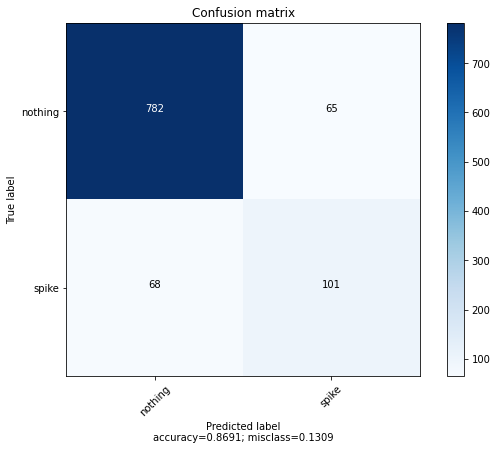


 0.6546762589928057 

  0%|          | 1/200 [00:10<07:42,  2.32s/it, best loss: -0.6029850746268656]

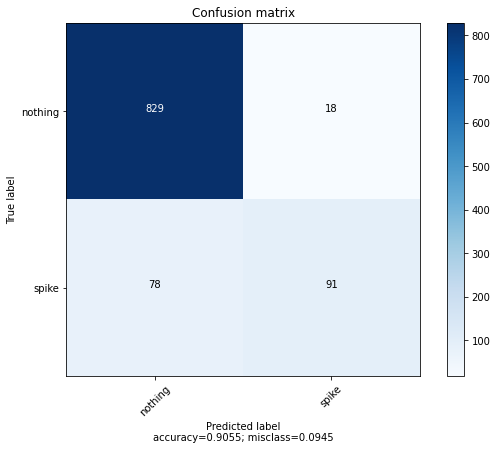


 0.6143344709897611 

  1%|          | 2/200 [00:12<13:44,  4.17s/it, best loss: -0.6546762589928057]

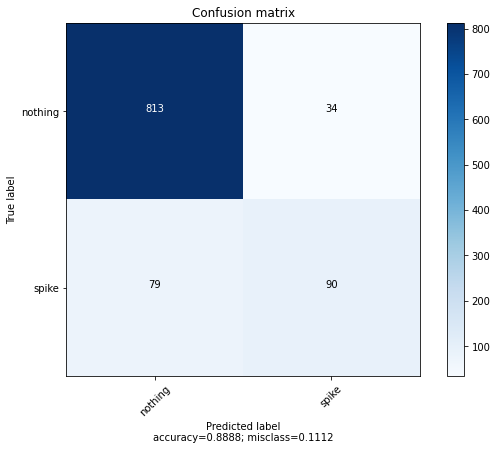


 0.6066666666666667 

  2%|▏         | 3/200 [00:16<11:48,  3.60s/it, best loss: -0.6546762589928057]

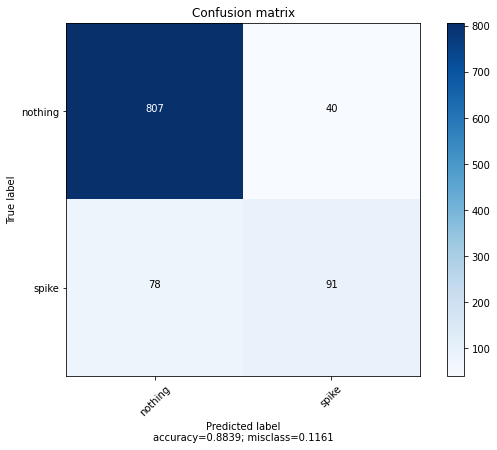


 0.6571428571428571 

  2%|▏         | 4/200 [00:21<12:11,  3.73s/it, best loss: -0.6546762589928057]

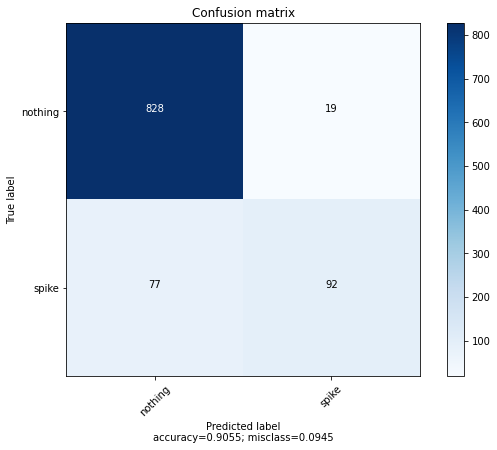


 0.6032786885245902 

  2%|▎         | 5/200 [00:27<12:33,  3.86s/it, best loss: -0.6571428571428571]

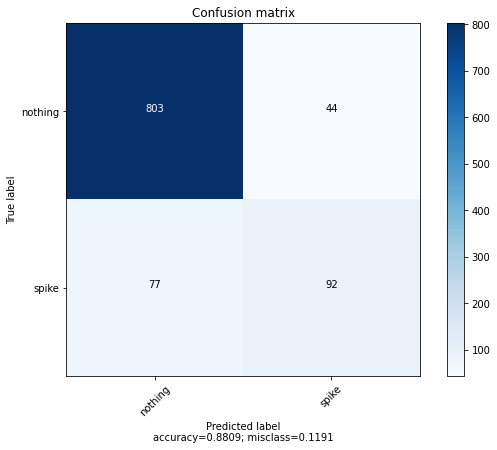


 0.6127946127946129 

  3%|▎         | 6/200 [00:30<14:39,  4.53s/it, best loss: -0.6571428571428571]

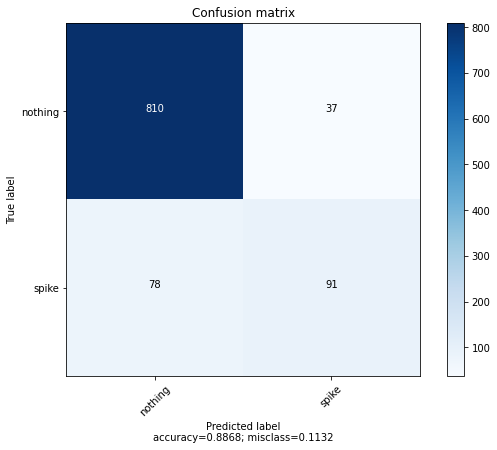


 0.6271777003484321 

  4%|▎         | 7/200 [00:33<13:08,  4.08s/it, best loss: -0.6571428571428571]

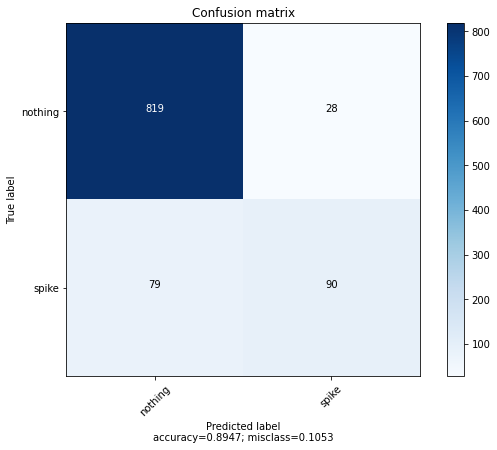


 0.6304347826086956 

  4%|▍         | 8/200 [00:38<12:41,  3.96s/it, best loss: -0.6571428571428571]

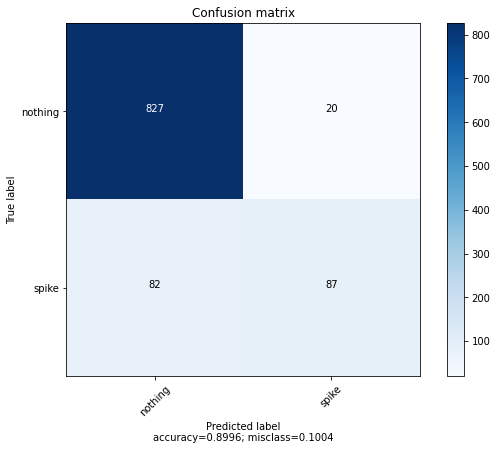


 0.5599999999999999 

  4%|▍         | 9/200 [00:39<13:28,  4.23s/it, best loss: -0.6571428571428571]

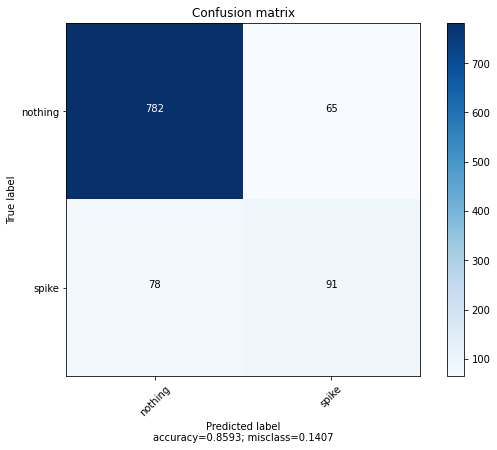


 0.5512367491166078 

  5%|▌         | 10/200 [00:42<10:29,  3.31s/it, best loss: -0.6571428571428571]

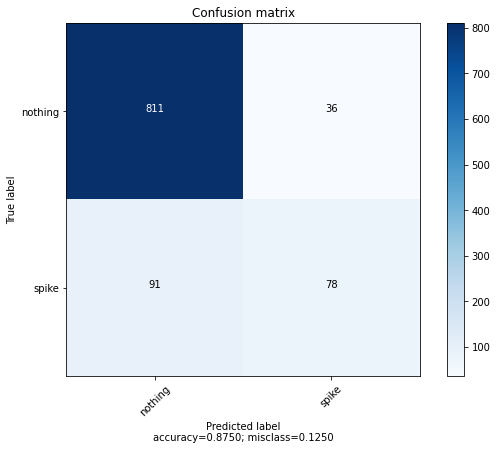


 0.5815602836879432 

  6%|▌         | 11/200 [00:45<09:50,  3.13s/it, best loss: -0.6571428571428571]

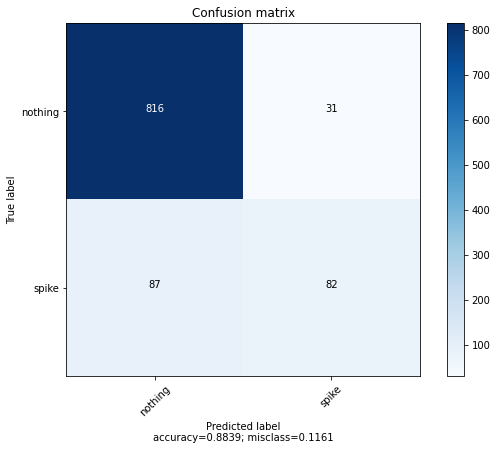


 0.4702549575070822 

  6%|▌         | 12/200 [00:46<09:56,  3.17s/it, best loss: -0.6571428571428571]

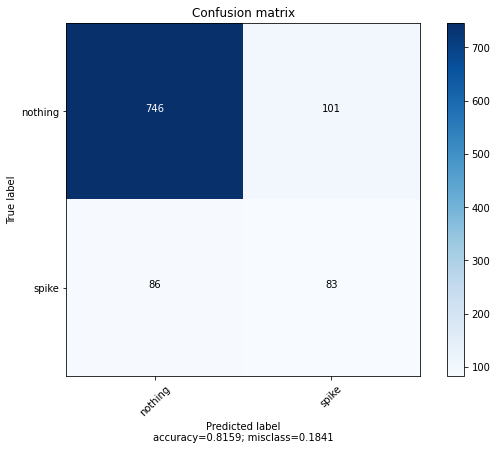


 0.6254295532646048 

  6%|▋         | 13/200 [00:52<07:34,  2.43s/it, best loss: -0.6571428571428571]

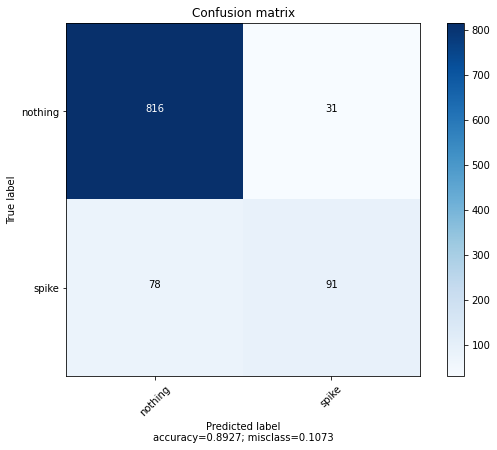


 0.6153846153846153 

  7%|▋         | 14/200 [01:00<10:26,  3.37s/it, best loss: -0.6571428571428571]

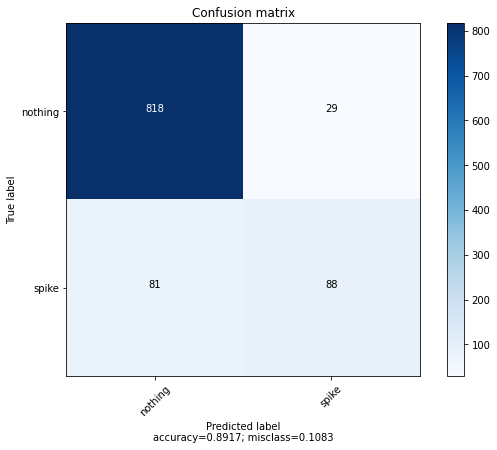


 0.6666666666666666 

  8%|▊         | 15/200 [01:04<15:03,  4.88s/it, best loss: -0.6571428571428571]

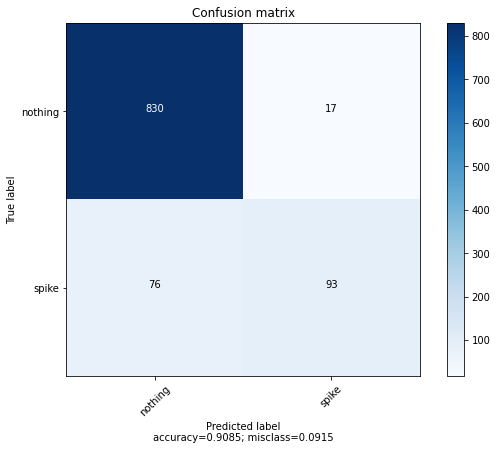


 0.625 

  8%|▊         | 16/200 [01:09<14:25,  4.70s/it, best loss: -0.6666666666666666]

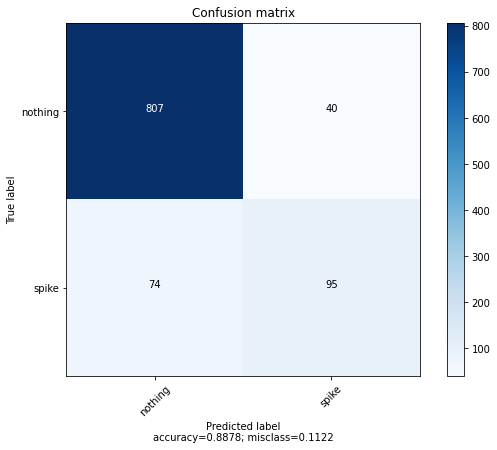


 0.6258503401360545 

  8%|▊         | 17/200 [01:12<14:27,  4.74s/it, best loss: -0.6666666666666666]

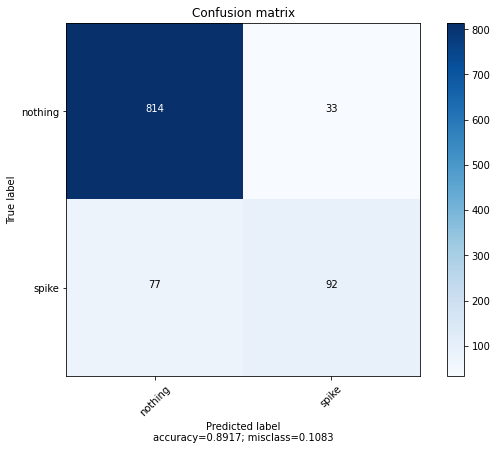


 0.6468401486988847 

  9%|▉         | 18/200 [01:19<13:10,  4.34s/it, best loss: -0.6666666666666666]

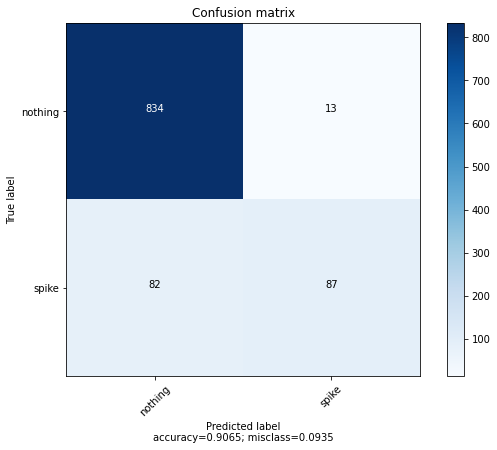


 0.5648414985590777 

 10%|▉         | 19/200 [01:20<14:56,  4.95s/it, best loss: -0.6666666666666666]

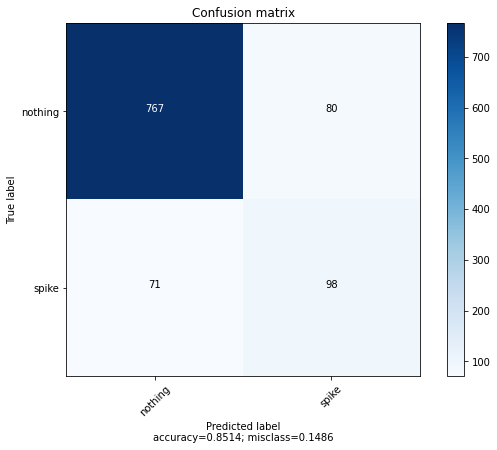


 0.6370370370370371 

 10%|█         | 20/200 [01:26<11:41,  3.90s/it, best loss: -0.6666666666666666]

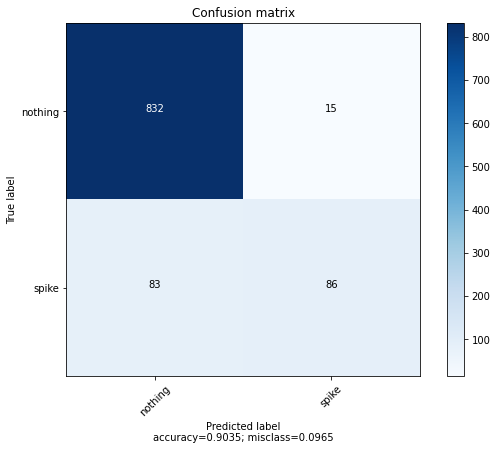


 0.6453900709219859 

 10%|█         | 21/200 [01:30<13:20,  4.47s/it, best loss: -0.6666666666666666]

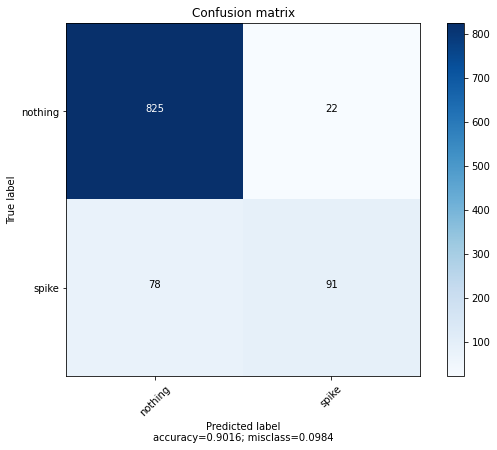


 0.6292134831460674 

 11%|█         | 22/200 [01:38<12:32,  4.23s/it, best loss: -0.6666666666666666]

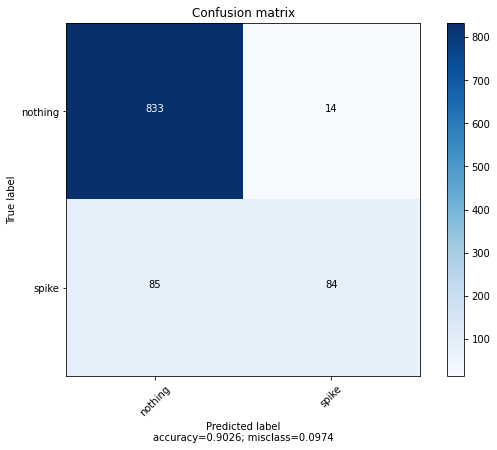


 0.5870307167235495 

 12%|█▏        | 23/200 [01:41<15:56,  5.40s/it, best loss: -0.6666666666666666]

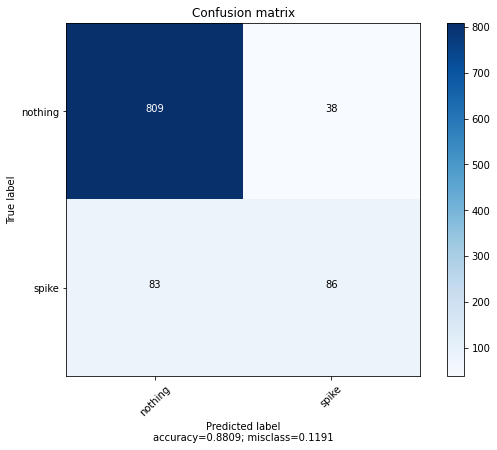


 0.5584415584415585 

 12%|█▏        | 24/200 [01:43<13:48,  4.71s/it, best loss: -0.6666666666666666]

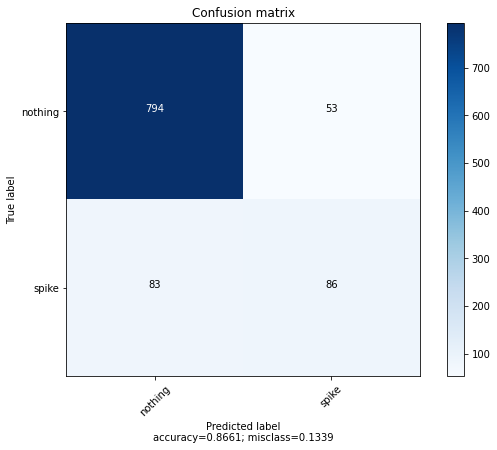


 0.6273062730627307 

 12%|█▎        | 25/200 [01:50<11:12,  3.85s/it, best loss: -0.6666666666666666]

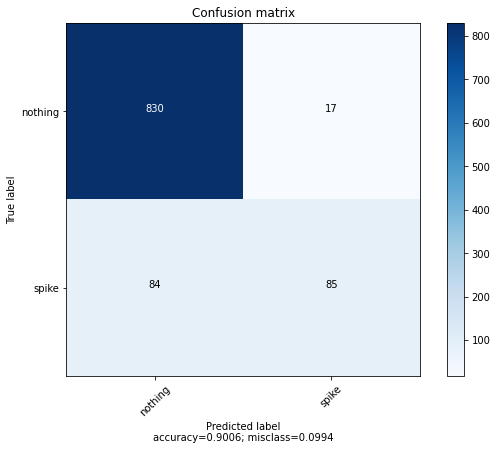


 0.6690140845070421 

 13%|█▎        | 26/200 [01:57<14:17,  4.93s/it, best loss: -0.6666666666666666]

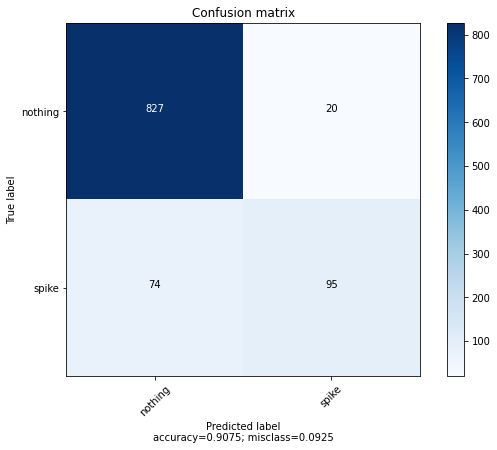


 0.5387453874538746 

 14%|█▎        | 27/200 [02:01<15:50,  5.50s/it, best loss: -0.6690140845070421]

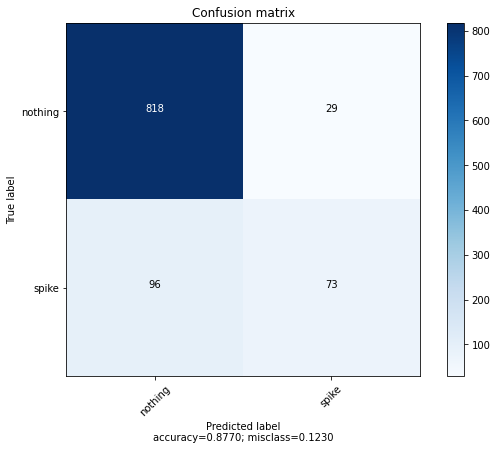


 0.6594982078853047 

 14%|█▍        | 28/200 [02:05<14:13,  4.96s/it, best loss: -0.6690140845070421]

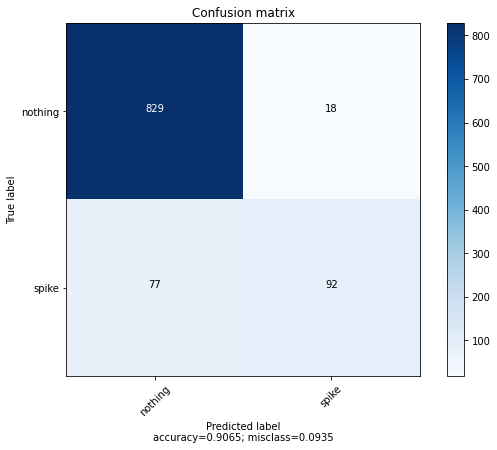


 0.6268656716417911 

 14%|█▍        | 29/200 [02:13<13:03,  4.58s/it, best loss: -0.6690140845070421]

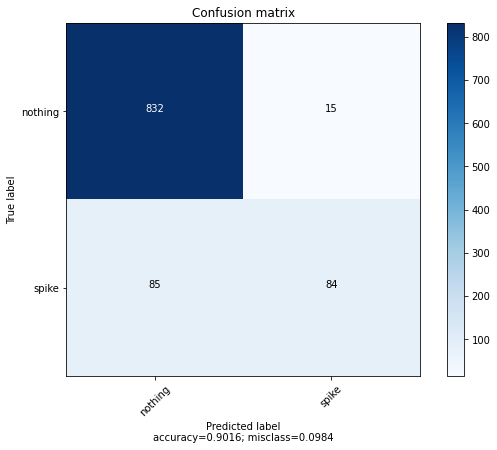


 0.6222222222222222 

 15%|█▌        | 30/200 [02:18<16:14,  5.73s/it, best loss: -0.6690140845070421]

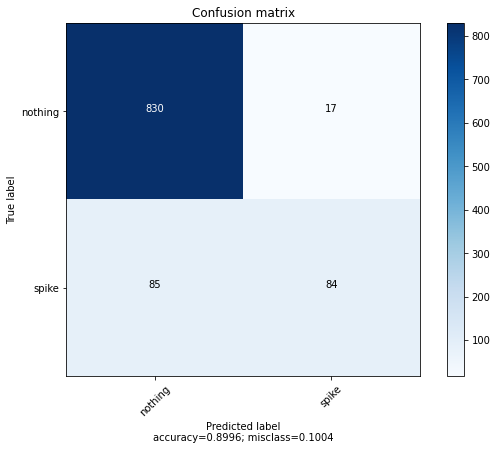


 0.6327272727272728 

 16%|█▌        | 31/200 [02:23<15:37,  5.55s/it, best loss: -0.6690140845070421]

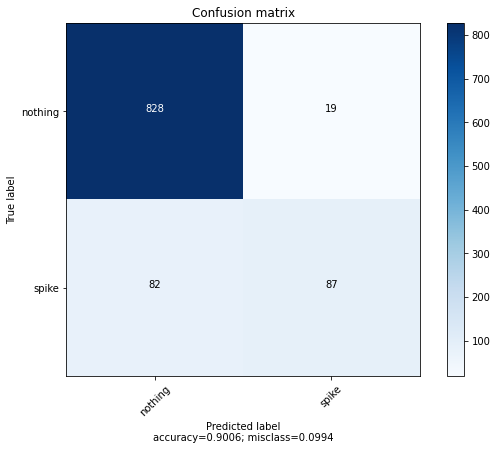


 0.6642335766423358 

 16%|█▌        | 32/200 [02:31<14:50,  5.30s/it, best loss: -0.6690140845070421]

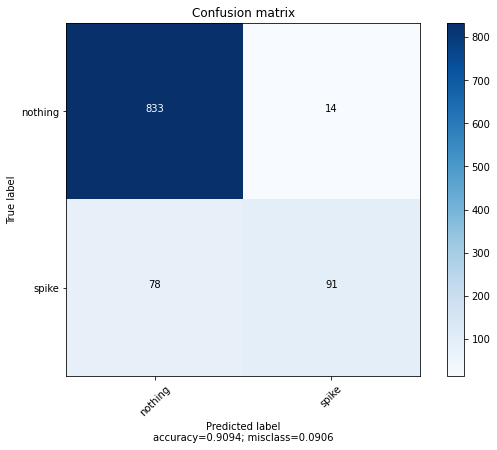


 0.5912408759124088 

 16%|█▋        | 33/200 [02:37<17:04,  6.13s/it, best loss: -0.6690140845070421]

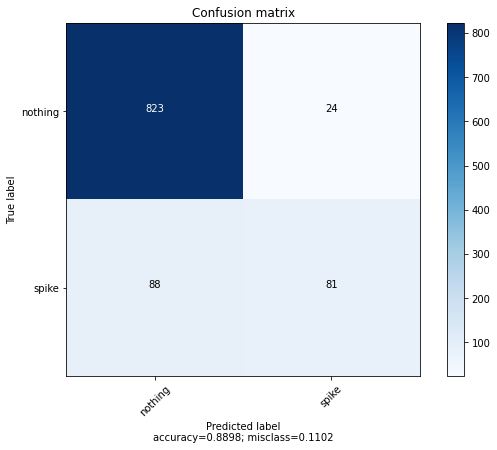


 0.5987261146496815 

 17%|█▋        | 34/200 [02:38<16:32,  5.98s/it, best loss: -0.6690140845070421]

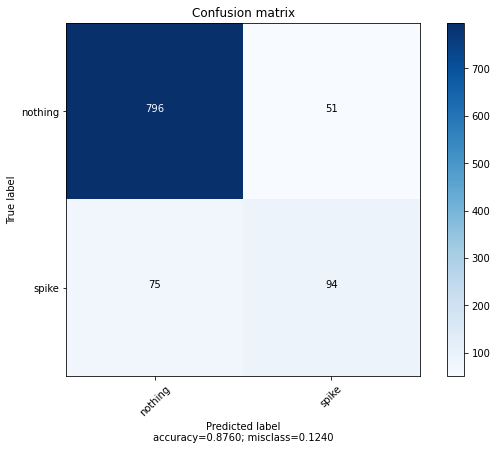


 0.6169491525423728 

 18%|█▊        | 35/200 [02:43<12:46,  4.65s/it, best loss: -0.6690140845070421]

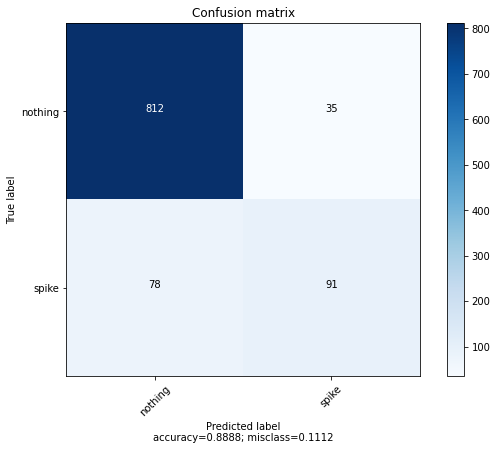


 0.6095238095238096 

 18%|█▊        | 36/200 [02:45<13:19,  4.87s/it, best loss: -0.6690140845070421]

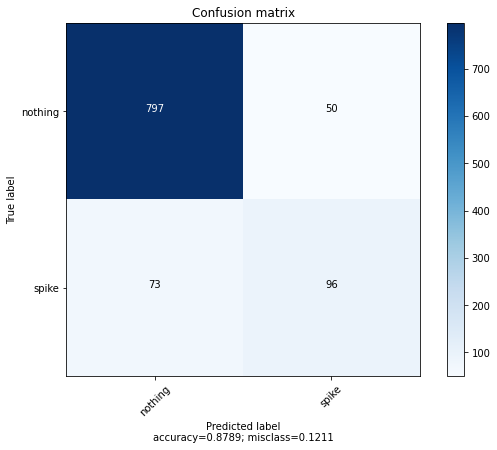


 0.6570397111913358 

 18%|█▊        | 37/200 [02:53<10:25,  3.83s/it, best loss: -0.6690140845070421]

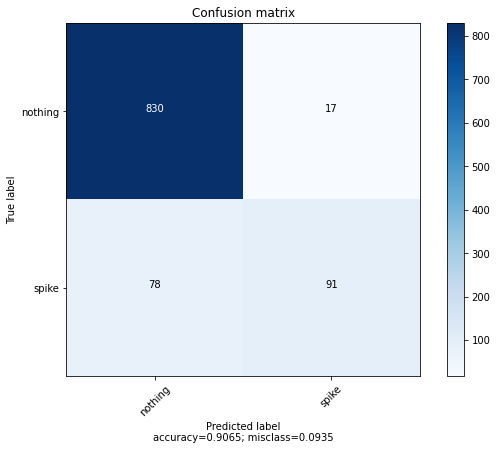


 0.6520146520146521 

 19%|█▉        | 38/200 [02:58<13:45,  5.09s/it, best loss: -0.6690140845070421]

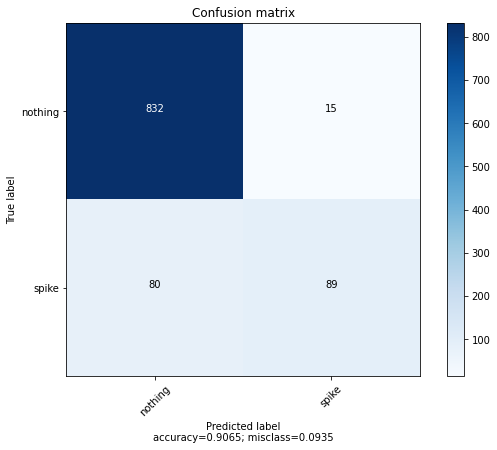


 0.6399999999999999 

 20%|█▉        | 39/200 [03:06<13:30,  5.03s/it, best loss: -0.6690140845070421]

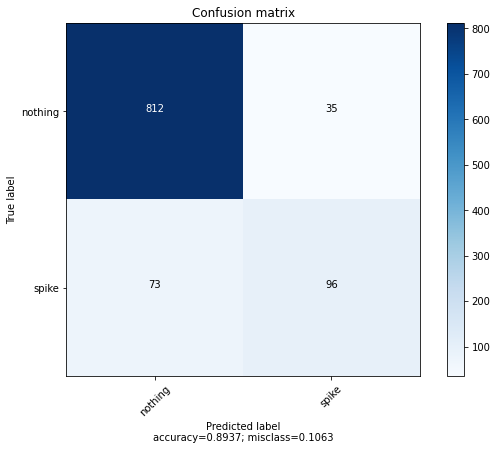


 0.6323529411764707 

 20%|██        | 40/200 [03:11<15:43,  5.90s/it, best loss: -0.6690140845070421]

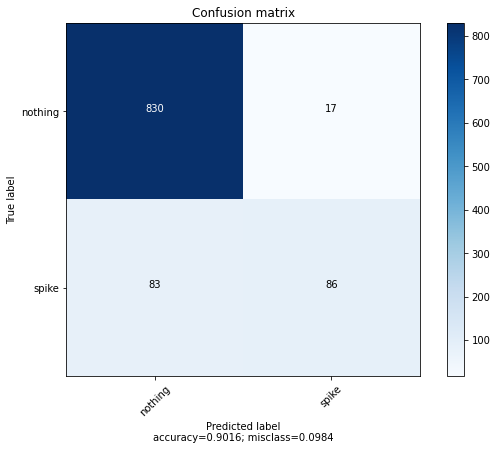


 0.5814696485623002 

 20%|██        | 41/200 [03:14<15:05,  5.70s/it, best loss: -0.6690140845070421]

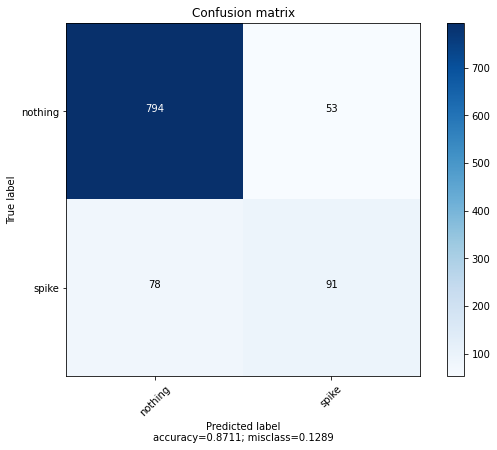


 0.6206896551724138 

 21%|██        | 42/200 [03:17<12:46,  4.85s/it, best loss: -0.6690140845070421]

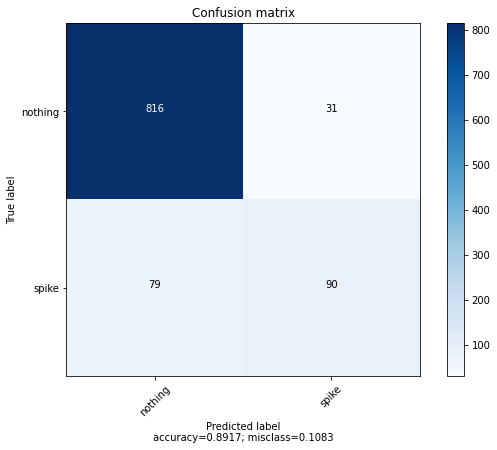


 0.6245614035087719 

 22%|██▏       | 43/200 [03:21<11:42,  4.48s/it, best loss: -0.6690140845070421]

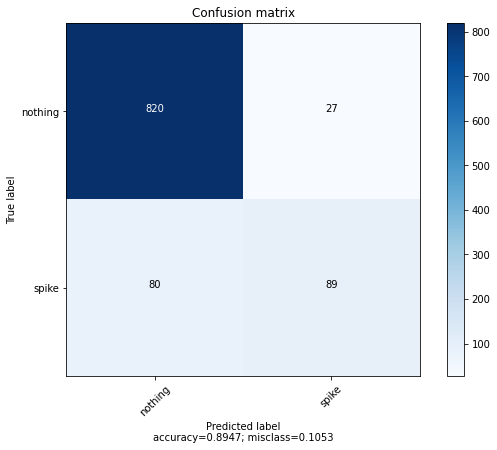


 0.5589225589225589 

 22%|██▏       | 44/200 [03:23<11:01,  4.24s/it, best loss: -0.6690140845070421]

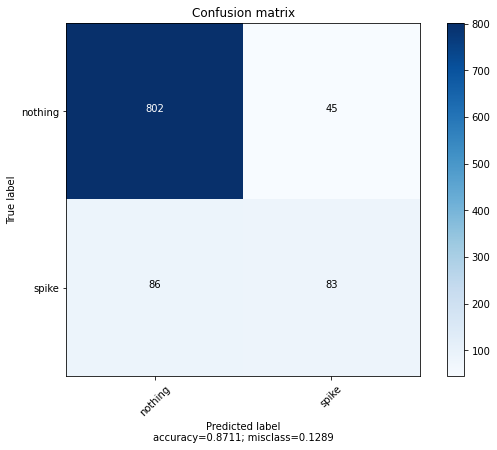


 0.6405228758169934 

 22%|██▎       | 45/200 [03:25<09:10,  3.55s/it, best loss: -0.6690140845070421]

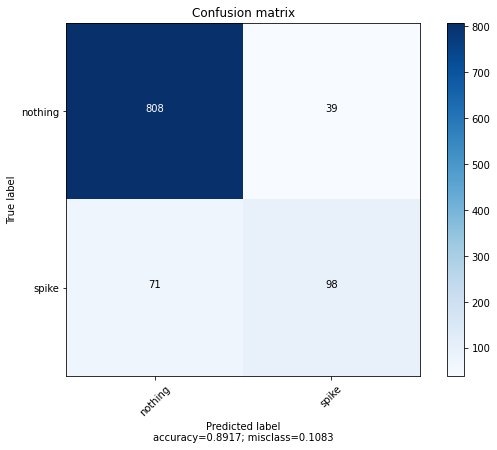


 0.6402877697841727 

 23%|██▎       | 46/200 [03:31<08:12,  3.20s/it, best loss: -0.6690140845070421]

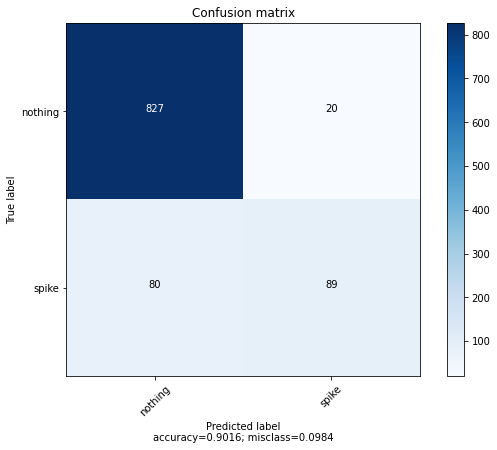


 0.4727272727272728 

 24%|██▎       | 47/200 [03:32<09:56,  3.90s/it, best loss: -0.6690140845070421]

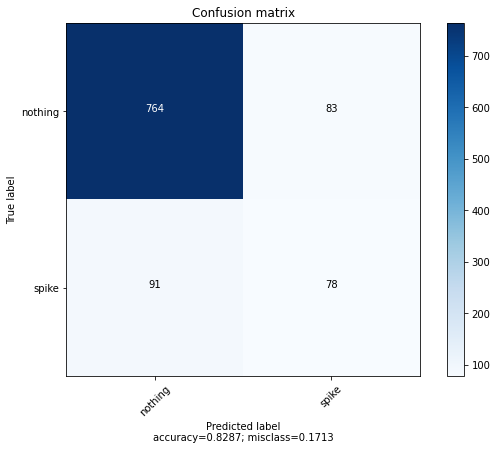


 0.5923566878980892 

 24%|██▍       | 48/200 [03:35<07:25,  2.93s/it, best loss: -0.6690140845070421]

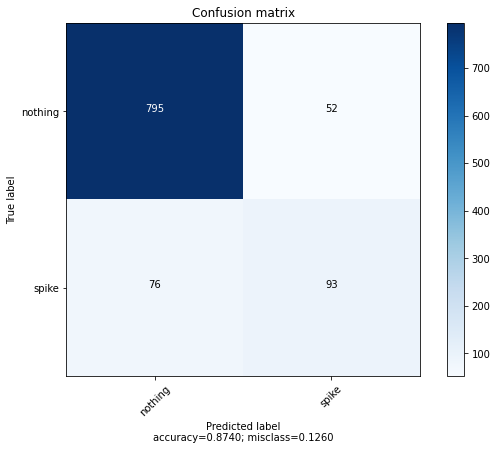


 0.4968944099378882 

 24%|██▍       | 49/200 [03:36<07:43,  3.07s/it, best loss: -0.6690140845070421]

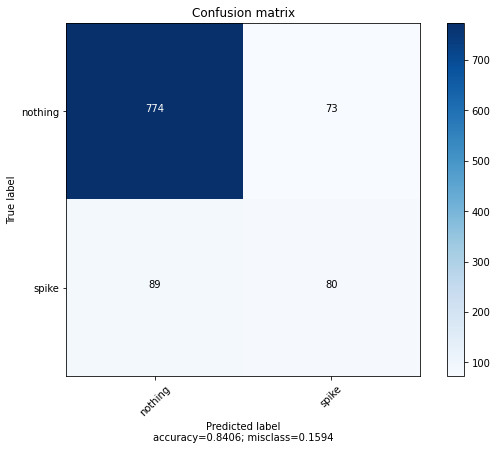


 0.6327272727272728 

 25%|██▌       | 50/200 [03:41<06:08,  2.46s/it, best loss: -0.6690140845070421]

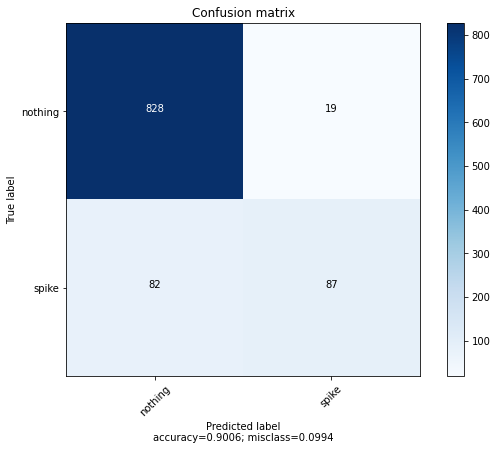


 0.6617647058823529 

 26%|██▌       | 51/200 [03:46<07:41,  3.10s/it, best loss: -0.6690140845070421]

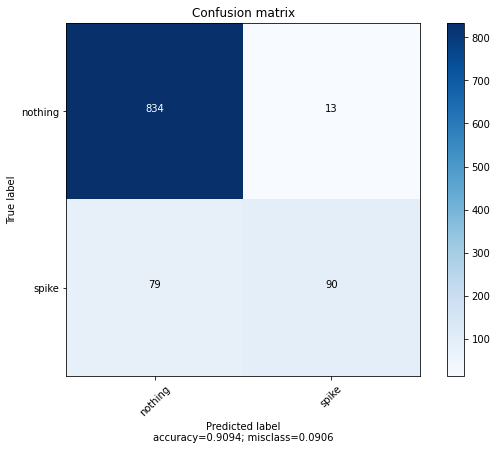


 0.6621621621621622 

 26%|██▌       | 52/200 [03:51<09:35,  3.89s/it, best loss: -0.6690140845070421]

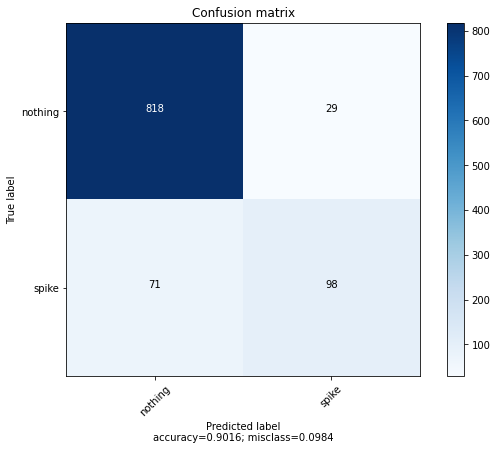


 0.6013513513513514 

 26%|██▋       | 53/200 [03:53<10:13,  4.17s/it, best loss: -0.6690140845070421]

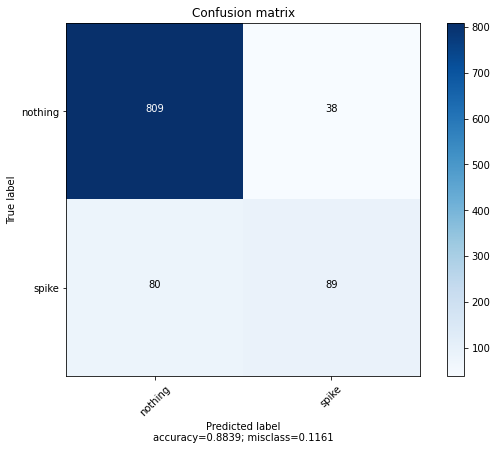


 0.6071428571428572 

 27%|██▋       | 54/200 [03:58<08:42,  3.58s/it, best loss: -0.6690140845070421]

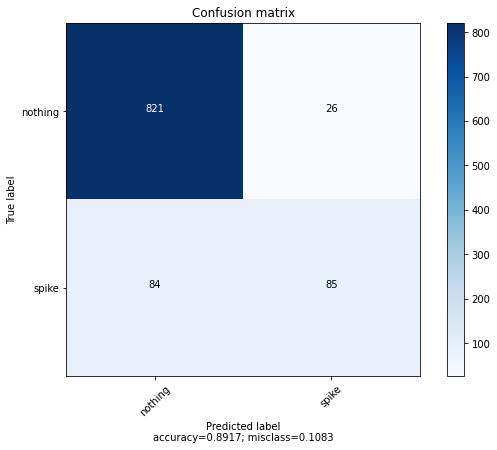


 0.644927536231884 

 28%|██▊       | 55/200 [04:14<09:34,  3.96s/it, best loss: -0.6690140845070421]

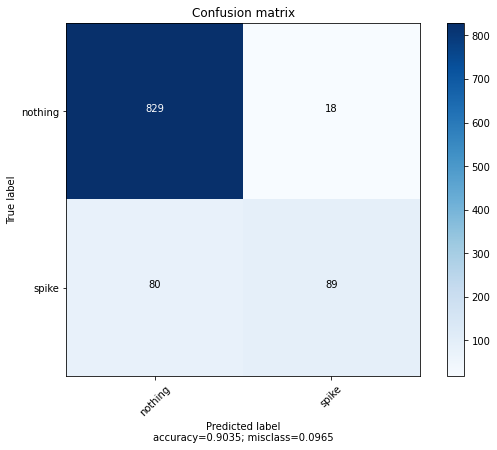


 0.6520146520146521 

 28%|██▊       | 56/200 [04:21<17:38,  7.35s/it, best loss: -0.6690140845070421]

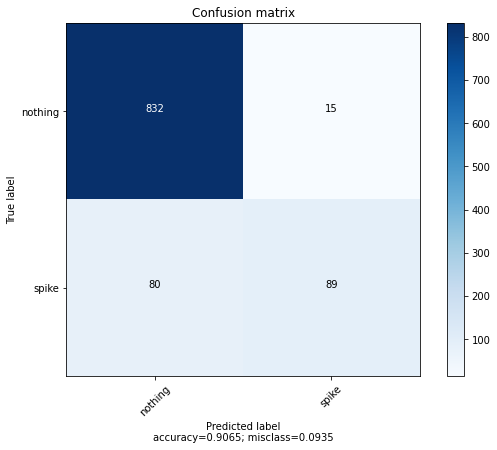


 0.6344827586206897 

 28%|██▊       | 57/200 [04:28<17:25,  7.31s/it, best loss: -0.6690140845070421]

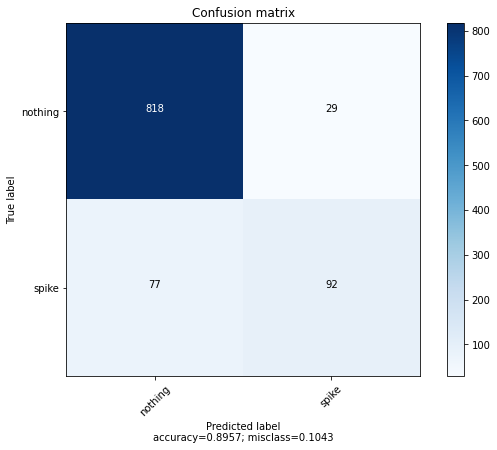


 0.6214285714285714 

 29%|██▉       | 58/200 [04:32<17:24,  7.36s/it, best loss: -0.6690140845070421]

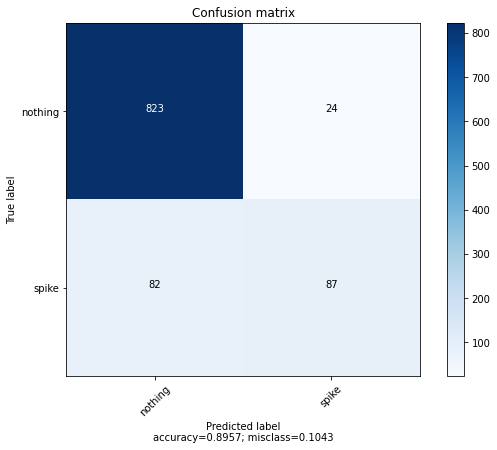


 0.57439446366782 

 30%|██▉       | 59/200 [04:35<14:30,  6.17s/it, best loss: -0.6690140845070421]

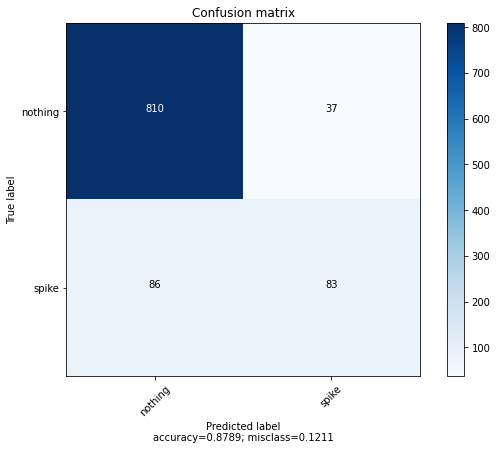


 0.6363636363636364 

 30%|███       | 60/200 [04:41<12:05,  5.18s/it, best loss: -0.6690140845070421]

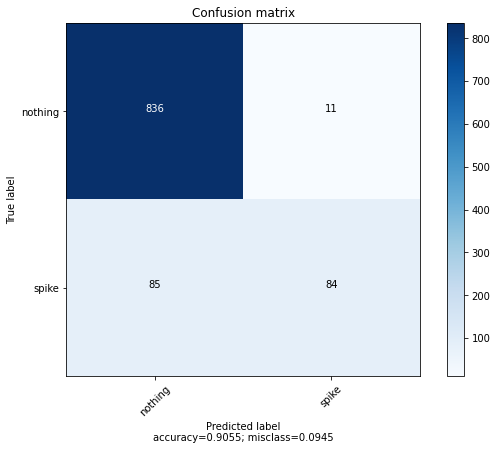


 0.6494464944649446 

 30%|███       | 61/200 [04:49<12:57,  5.59s/it, best loss: -0.6690140845070421]

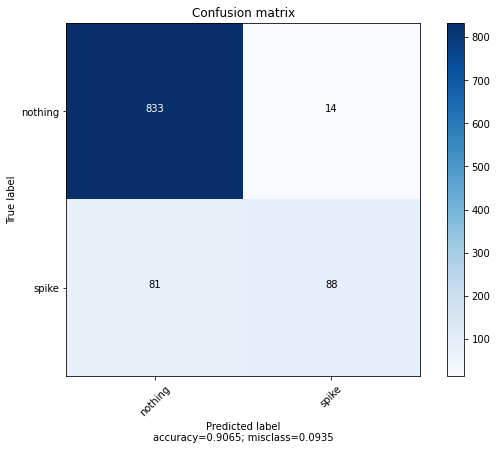


 0.5787965616045846 

 31%|███       | 62/200 [04:50<14:17,  6.21s/it, best loss: -0.6690140845070421]

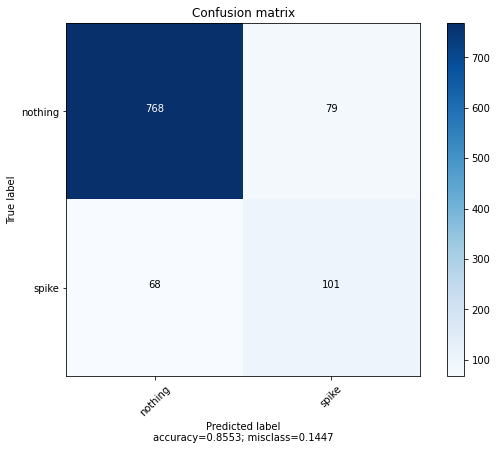


 0.5623003194888179 

 32%|███▏      | 63/200 [04:51<10:30,  4.60s/it, best loss: -0.6690140845070421]

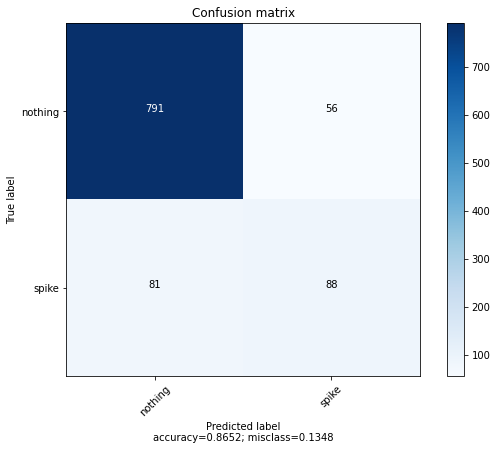


 0.5757575757575758 

 32%|███▏      | 64/200 [04:57<08:27,  3.73s/it, best loss: -0.6690140845070421]

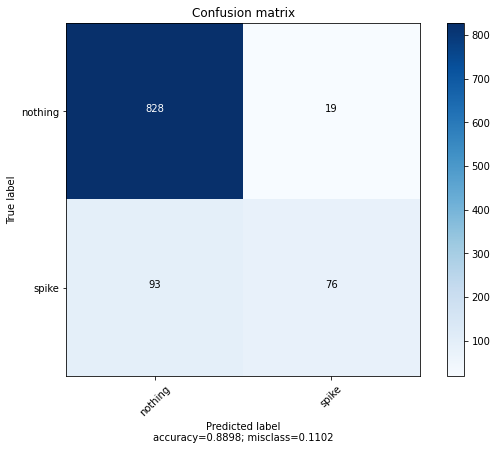


 0.6568265682656828 

 32%|███▎      | 65/200 [05:05<10:03,  4.47s/it, best loss: -0.6690140845070421]

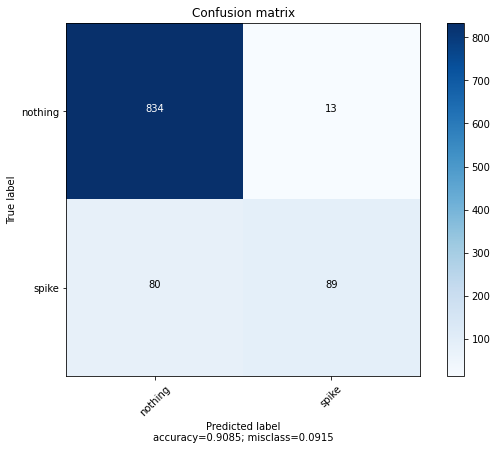


 0.6642335766423358 

 33%|███▎      | 66/200 [05:14<11:55,  5.34s/it, best loss: -0.6690140845070421]

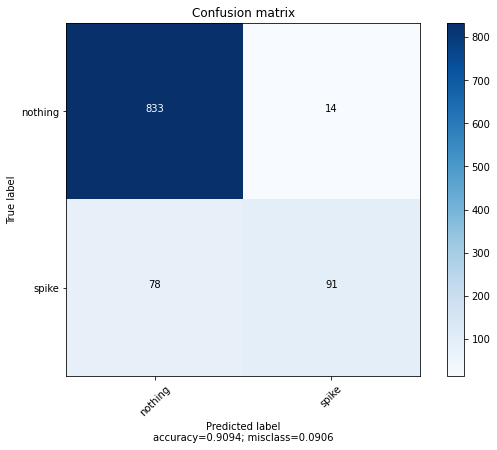


 0.62453531598513 

 34%|███▎      | 67/200 [05:22<14:06,  6.36s/it, best loss: -0.6690140845070421]

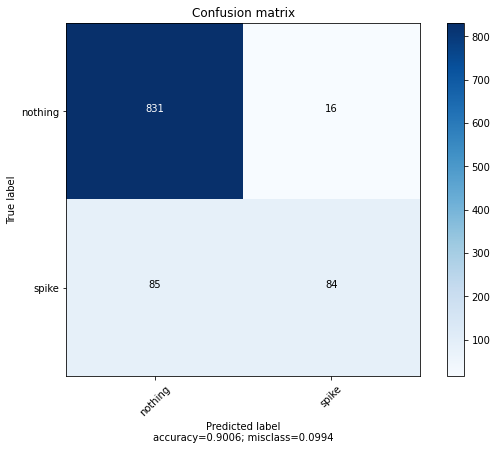


 0.6571428571428571 

 34%|███▍      | 68/200 [05:26<15:18,  6.96s/it, best loss: -0.6690140845070421]

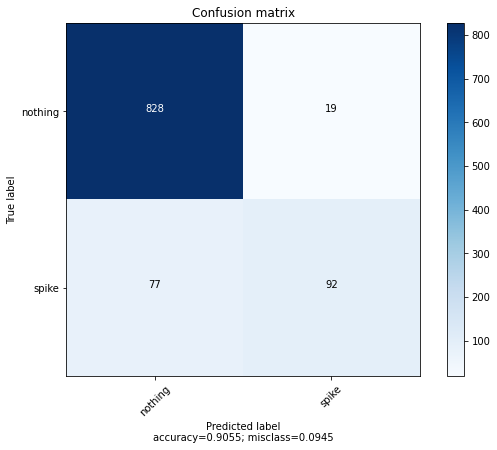


 0.6394052044609666 

 34%|███▍      | 69/200 [05:34<13:35,  6.23s/it, best loss: -0.6690140845070421]

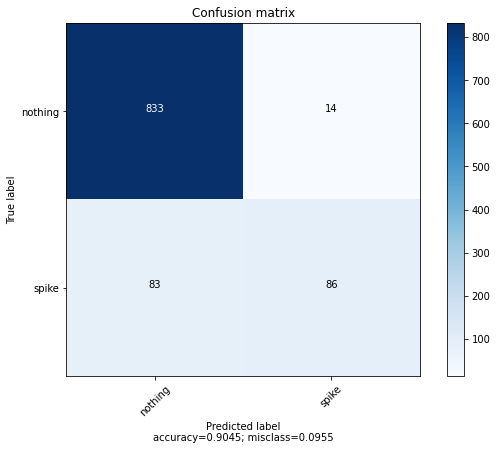


 0.6593406593406593 

 35%|███▌      | 70/200 [05:41<14:34,  6.73s/it, best loss: -0.6690140845070421]

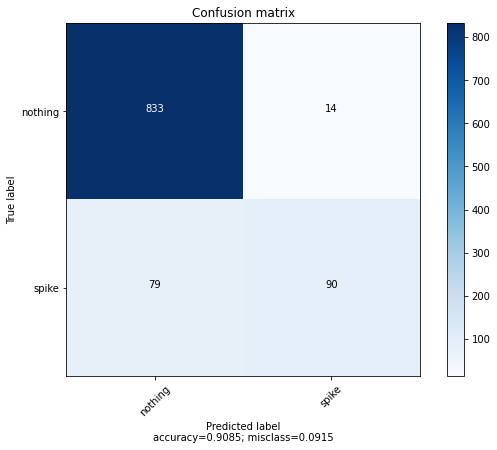


 0.6567164179104478 

 36%|███▌      | 71/200 [05:48<14:33,  6.77s/it, best loss: -0.6690140845070421]

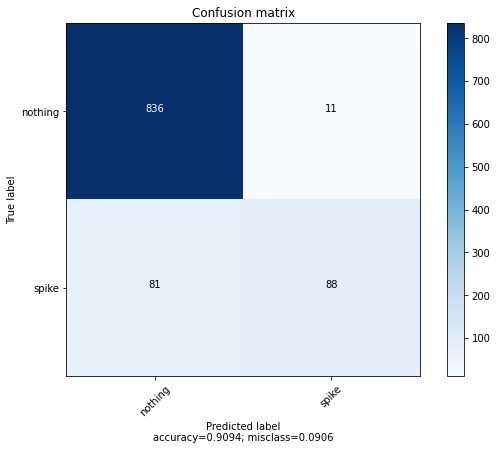


 0.6545454545454545 

 36%|███▌      | 72/200 [05:55<14:34,  6.83s/it, best loss: -0.6690140845070421]

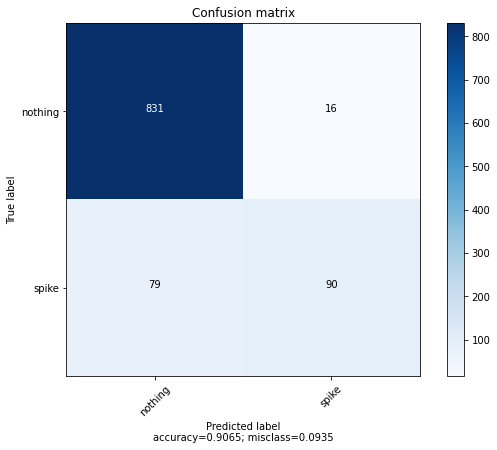


 0.676470588235294 

 36%|███▋      | 73/200 [06:03<14:27,  6.83s/it, best loss: -0.6690140845070421]

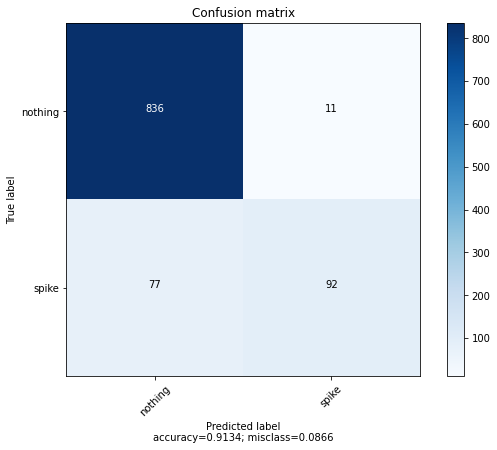


 0.6370370370370371 

 37%|███▋      | 74/200 [06:12<15:12,  7.25s/it, best loss: -0.676470588235294]

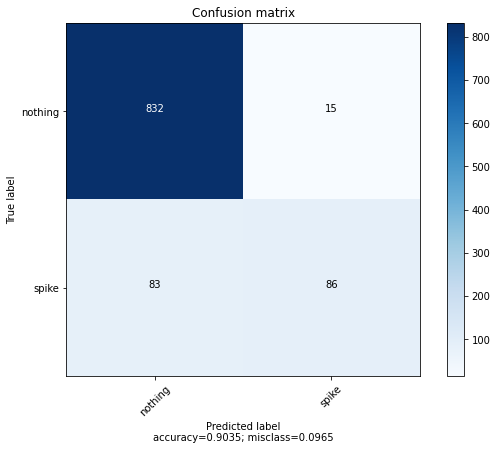


 0.6642335766423358 

 38%|███▊      | 75/200 [06:19<15:48,  7.59s/it, best loss: -0.676470588235294]

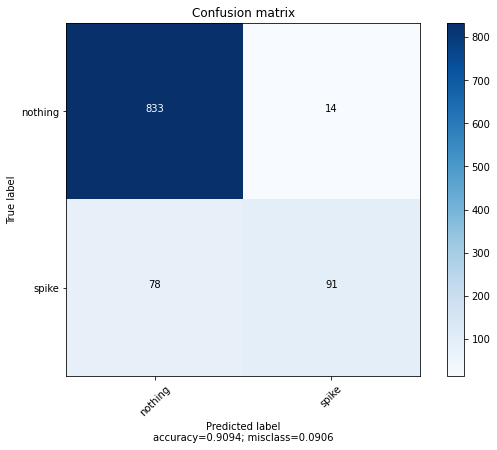


 0.656934306569343 

 38%|███▊      | 76/200 [06:27<15:18,  7.41s/it, best loss: -0.676470588235294]

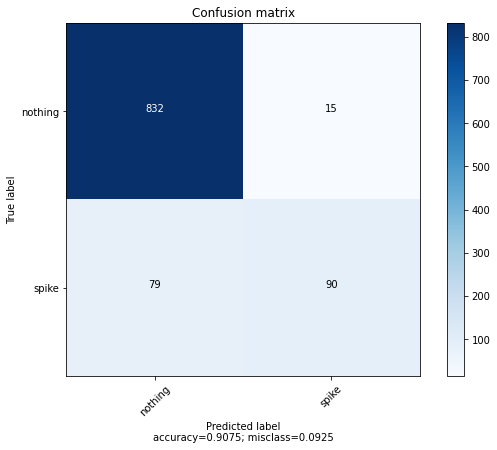


 0.6474820143884894 

 38%|███▊      | 77/200 [06:31<15:38,  7.63s/it, best loss: -0.676470588235294]

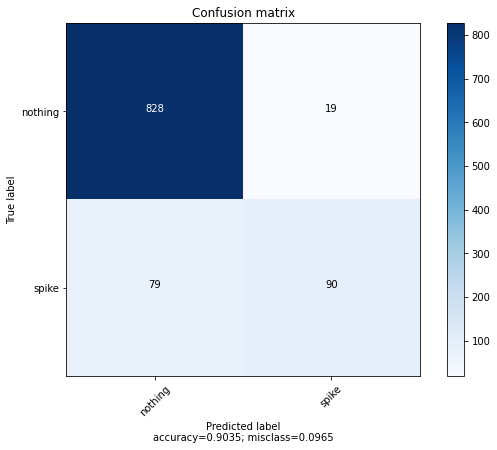


 0.6116838487972509 

 39%|███▉      | 78/200 [06:39<13:39,  6.72s/it, best loss: -0.676470588235294]

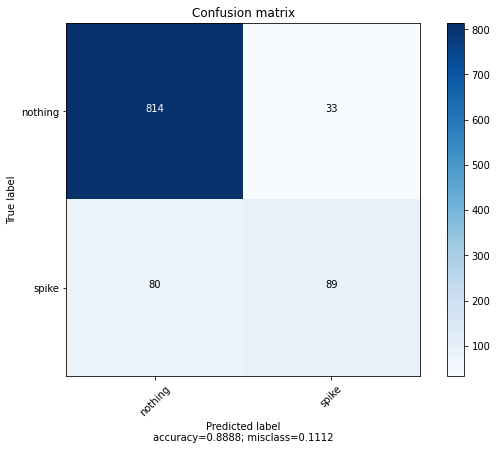


 0.6214285714285714 

 40%|███▉      | 79/200 [06:43<14:14,  7.06s/it, best loss: -0.676470588235294]

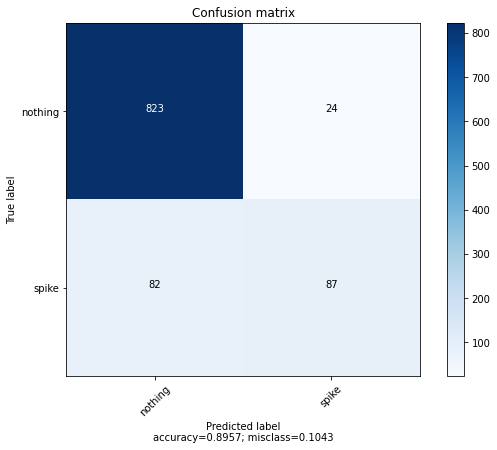


 0.6784452296819788 

 40%|████      | 80/200 [06:48<12:13,  6.11s/it, best loss: -0.676470588235294]

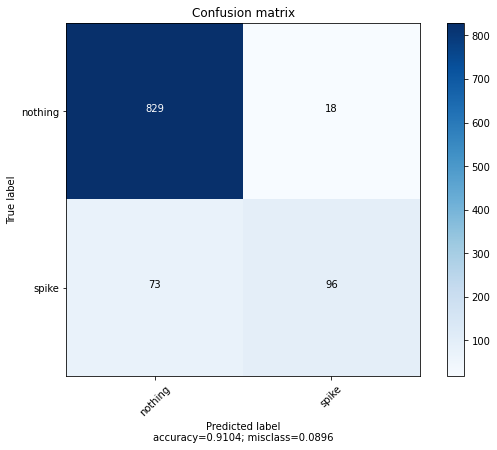


 0.6323529411764707 

 40%|████      | 81/200 [06:54<11:31,  5.81s/it, best loss: -0.6784452296819788]

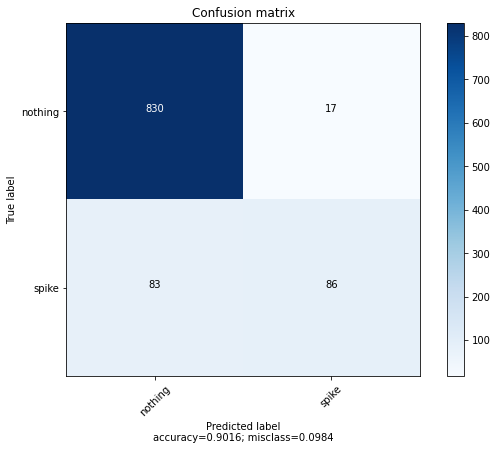


 0.6571428571428571 

 41%|████      | 82/200 [07:00<11:07,  5.66s/it, best loss: -0.6784452296819788]

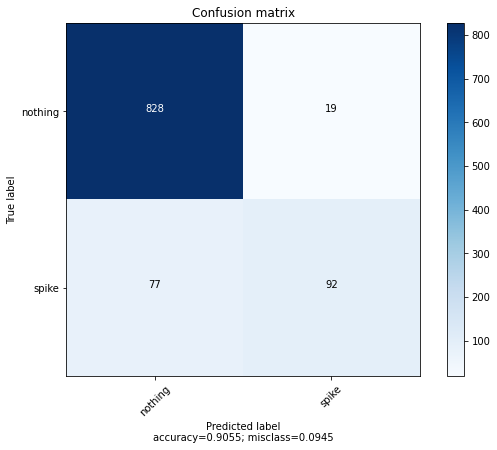


 0.6545454545454545 

 42%|████▏     | 83/200 [07:07<11:20,  5.82s/it, best loss: -0.6784452296819788]

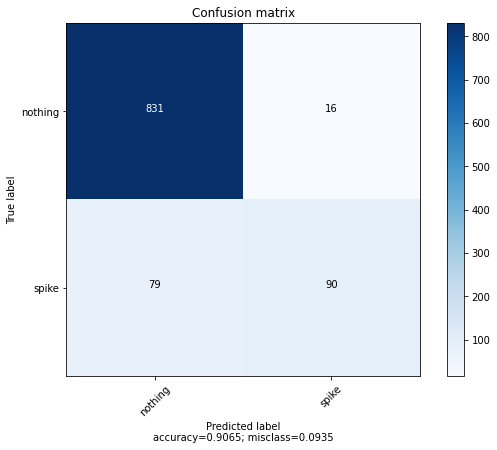


 0.6554054054054055 

 42%|████▏     | 84/200 [07:12<11:59,  6.20s/it, best loss: -0.6784452296819788]

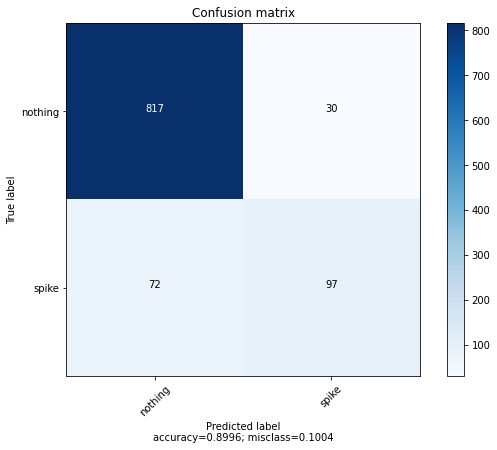


 0.6594202898550725 

 42%|████▎     | 85/200 [07:22<11:20,  5.92s/it, best loss: -0.6784452296819788]

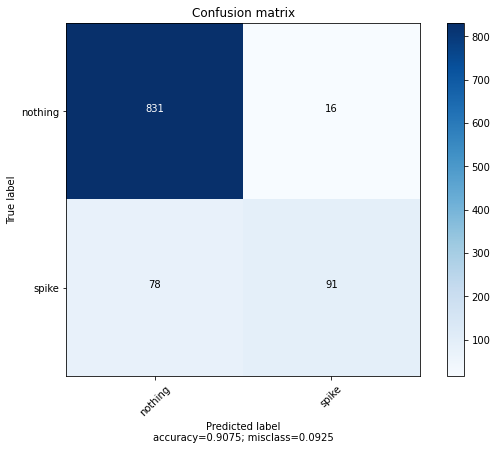


 0.6125461254612545 

 43%|████▎     | 86/200 [07:26<13:19,  7.01s/it, best loss: -0.6784452296819788]

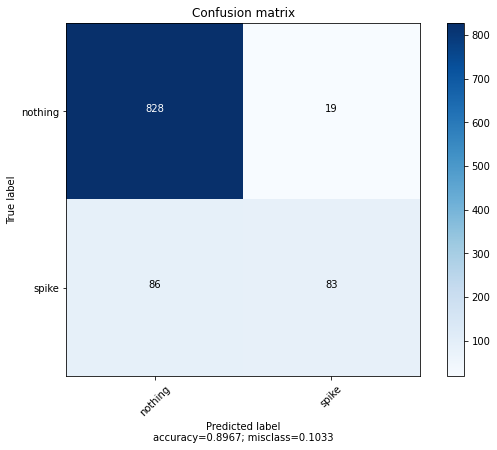


 0.6423357664233577 

 44%|████▎     | 87/200 [07:32<11:51,  6.29s/it, best loss: -0.6784452296819788]

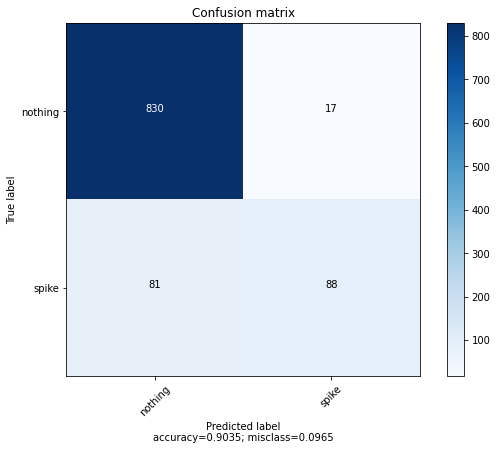


 0.6544117647058825 

 44%|████▍     | 88/200 [07:39<11:26,  6.13s/it, best loss: -0.6784452296819788]

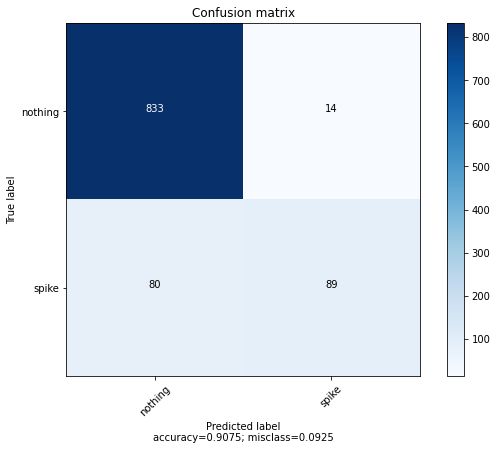


 0.6411149825783973 

 44%|████▍     | 89/200 [07:45<11:35,  6.27s/it, best loss: -0.6784452296819788]

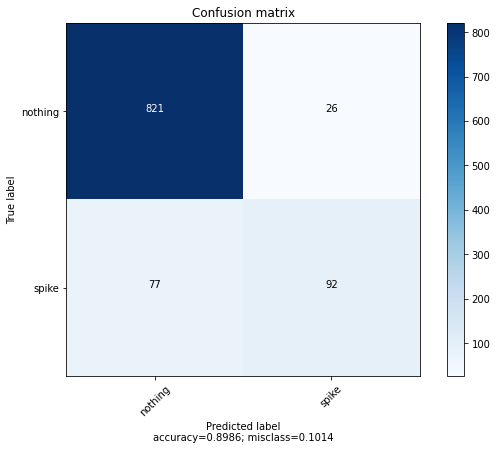


 0.621160409556314 

 45%|████▌     | 90/200 [07:48<11:45,  6.41s/it, best loss: -0.6784452296819788]

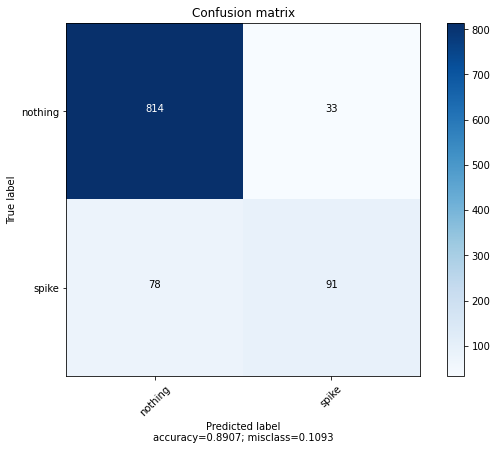


 0.5724907063197027 

 46%|████▌     | 91/200 [07:53<09:37,  5.30s/it, best loss: -0.6784452296819788]

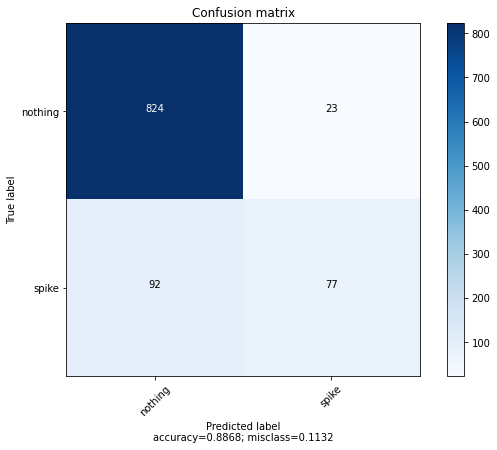


 0.6642857142857144 

 46%|████▌     | 92/200 [07:57<09:11,  5.11s/it, best loss: -0.6784452296819788]

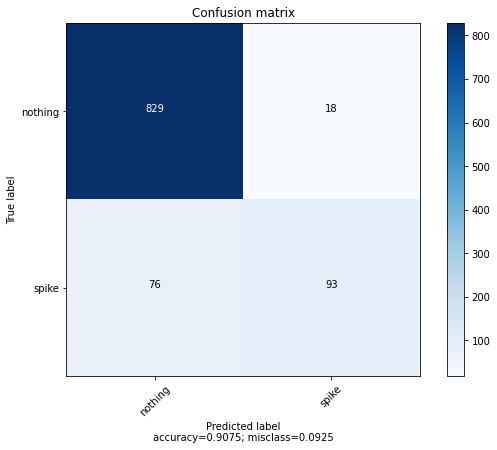


 0.6338028169014085 

 46%|████▋     | 93/200 [08:01<08:39,  4.86s/it, best loss: -0.6784452296819788]

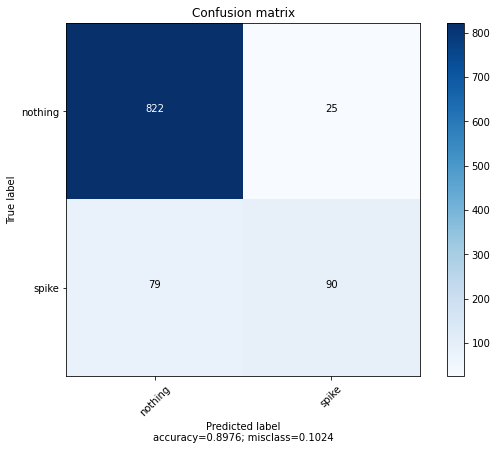


 0.6296296296296297 

 47%|████▋     | 94/200 [08:07<08:11,  4.63s/it, best loss: -0.6784452296819788]

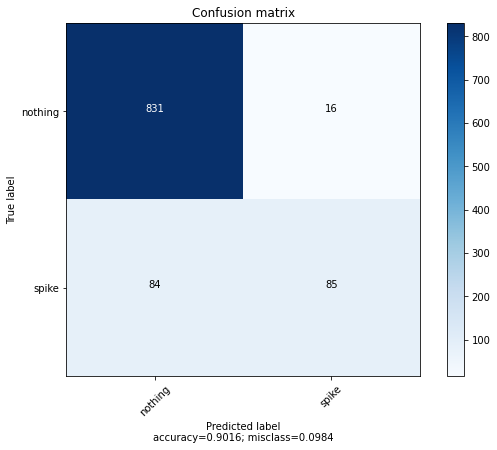


 0.644927536231884 

 48%|████▊     | 95/200 [08:12<08:57,  5.12s/it, best loss: -0.6784452296819788]

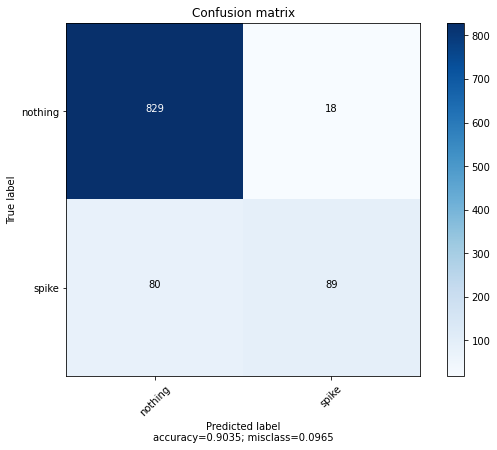


 0.6031746031746031 

 48%|████▊     | 96/200 [08:15<08:45,  5.05s/it, best loss: -0.6784452296819788]

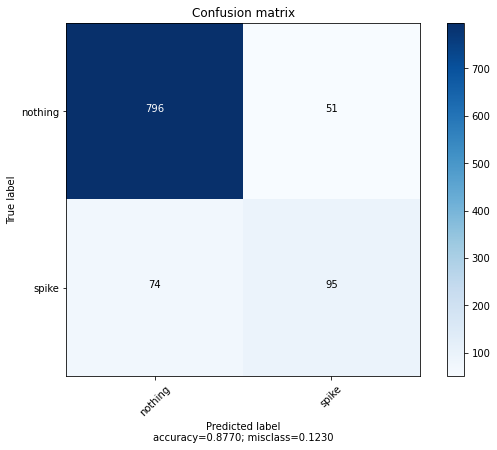


 0.60431654676259 

 48%|████▊     | 97/200 [08:20<07:25,  4.32s/it, best loss: -0.6784452296819788]

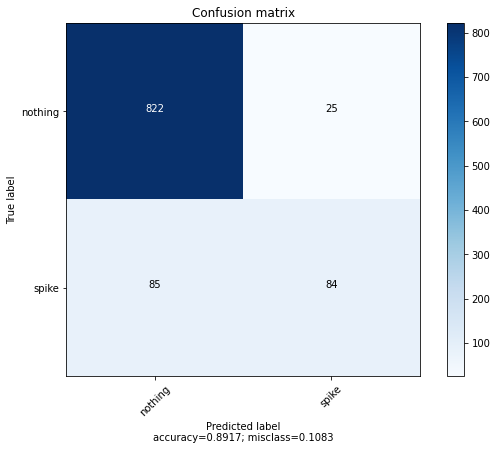


 0.6499999999999999 

 49%|████▉     | 98/200 [08:24<07:44,  4.55s/it, best loss: -0.6784452296819788]

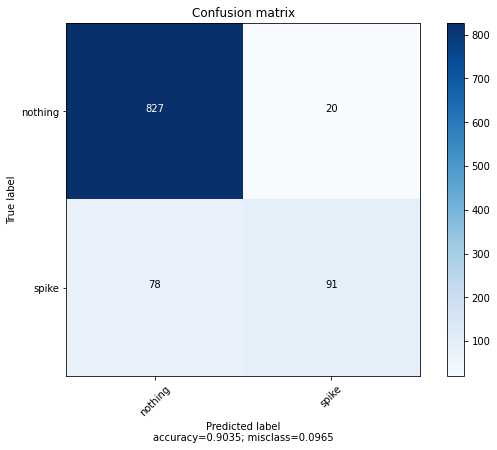


 0.6785714285714285 

 50%|████▉     | 99/200 [08:31<07:16,  4.32s/it, best loss: -0.6784452296819788]

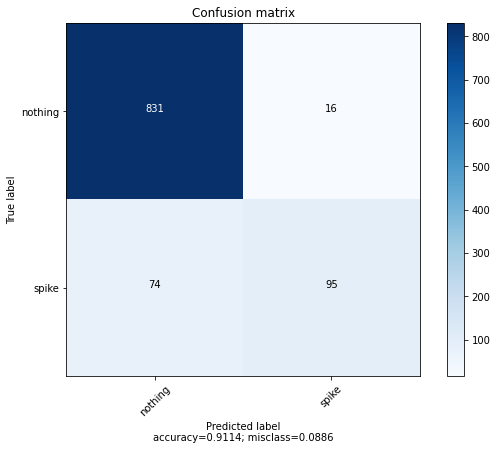


 0.6472727272727272 

 50%|█████     | 100/200 [08:37<08:40,  5.20s/it, best loss: -0.6785714285714285]

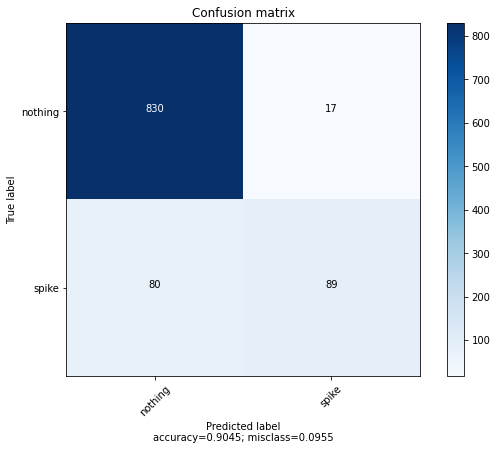


 0.6168831168831169 

 50%|█████     | 101/200 [08:43<09:06,  5.52s/it, best loss: -0.6785714285714285]

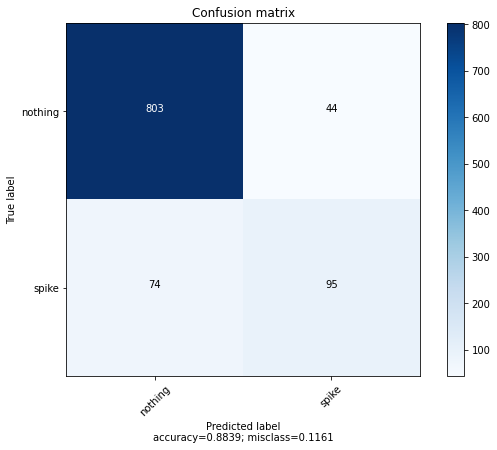


 0.6714285714285714 

 51%|█████     | 102/200 [08:50<09:09,  5.61s/it, best loss: -0.6785714285714285]

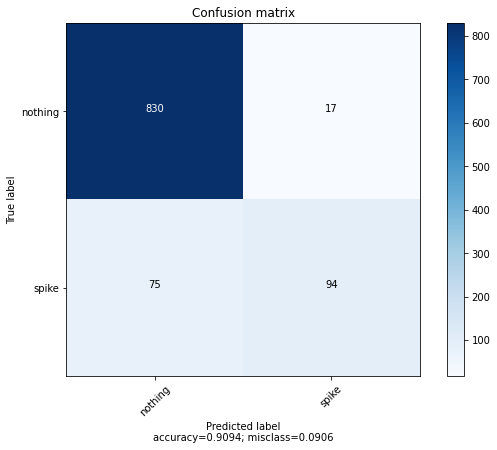


 0.6350364963503651 

 52%|█████▏    | 103/200 [08:55<09:40,  5.98s/it, best loss: -0.6785714285714285]

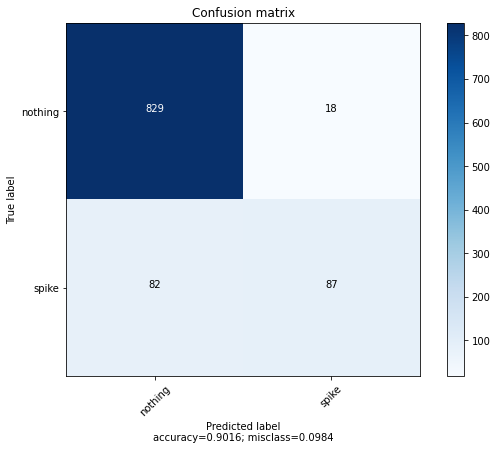


 0.6474820143884894 

 52%|█████▏    | 104/200 [08:59<08:55,  5.58s/it, best loss: -0.6785714285714285]

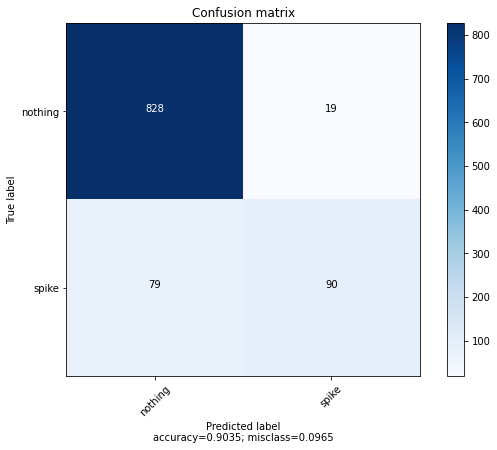


 0.6808510638297872 

 52%|█████▎    | 105/200 [09:06<08:23,  5.30s/it, best loss: -0.6785714285714285]

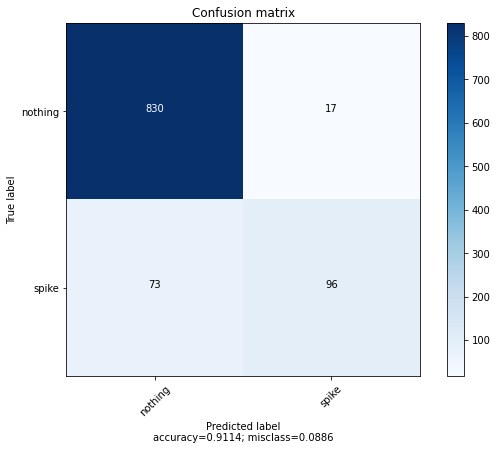


 0.58 

 53%|█████▎    | 106/200 [09:08<09:07,  5.82s/it, best loss: -0.6808510638297872]

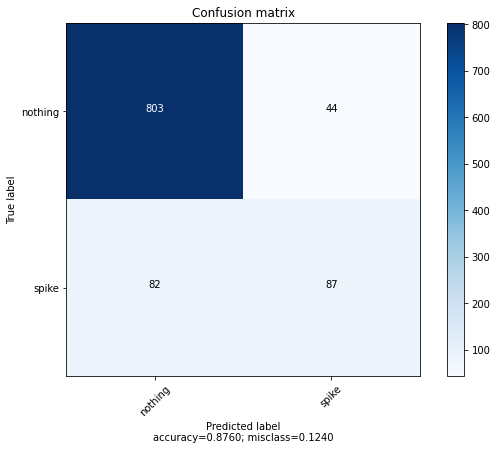


 0.6468401486988847 

 54%|█████▎    | 107/200 [09:15<07:03,  4.55s/it, best loss: -0.6808510638297872]

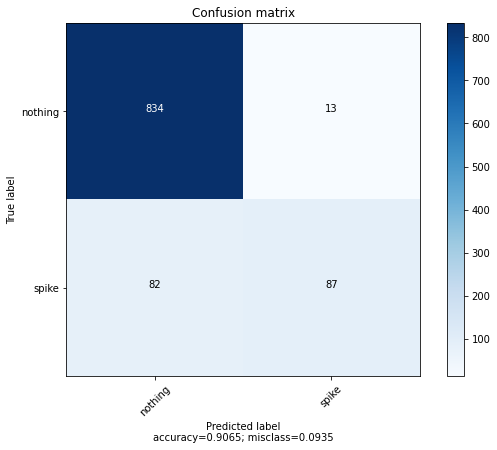


 0.6293706293706295 

 54%|█████▍    | 108/200 [09:23<08:04,  5.26s/it, best loss: -0.6808510638297872]

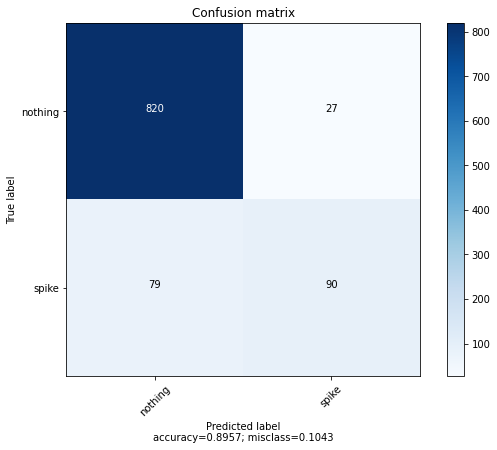


 0.6373626373626374 

 55%|█████▍    | 109/200 [09:28<09:08,  6.03s/it, best loss: -0.6808510638297872]

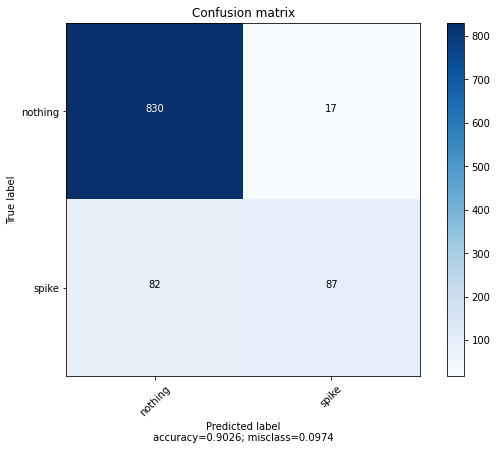


 0.5972222222222222 

 55%|█████▌    | 110/200 [09:33<08:54,  5.94s/it, best loss: -0.6808510638297872]

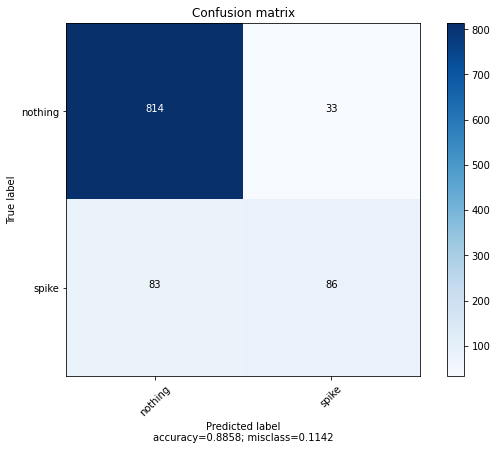


 0.6051660516605165 

 56%|█████▌    | 111/200 [09:37<08:03,  5.44s/it, best loss: -0.6808510638297872]

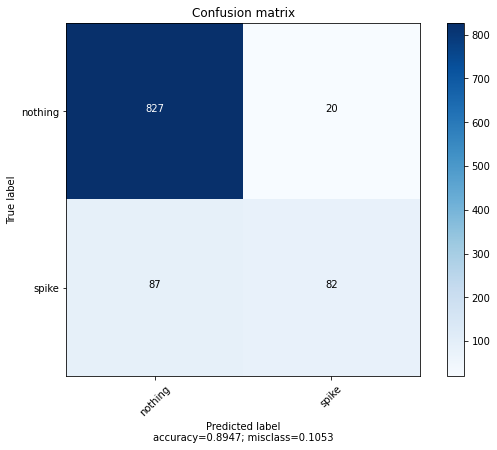


 0.6666666666666667 

 56%|█████▌    | 112/200 [09:42<07:26,  5.07s/it, best loss: -0.6808510638297872]

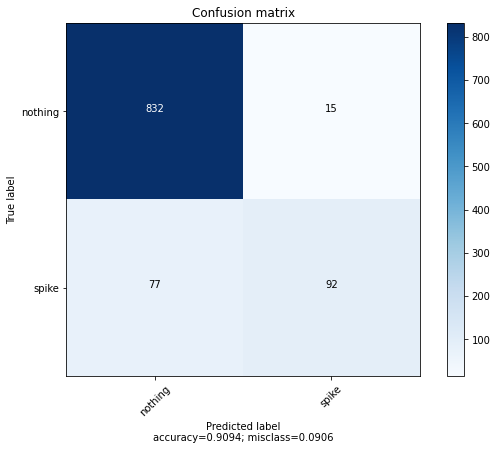


 0.6713780918727915 

 56%|█████▋    | 113/200 [09:48<07:36,  5.24s/it, best loss: -0.6808510638297872]

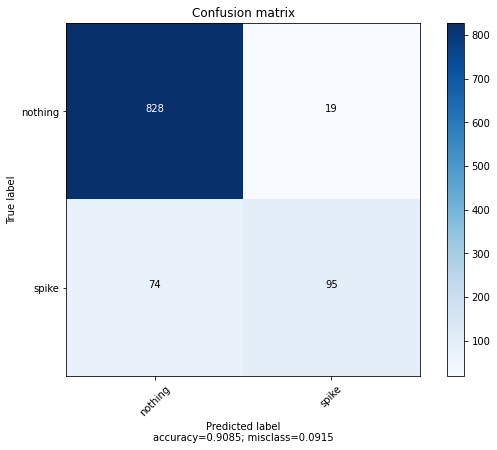


 0.6245614035087719 

 57%|█████▋    | 114/200 [09:57<07:32,  5.26s/it, best loss: -0.6808510638297872]

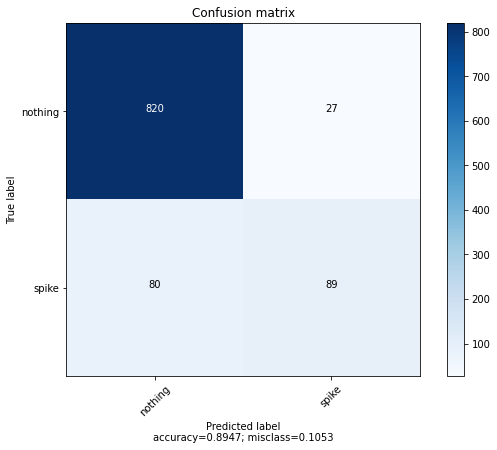


 0.6137931034482759 

 57%|█████▊    | 115/200 [10:00<09:20,  6.60s/it, best loss: -0.6808510638297872]

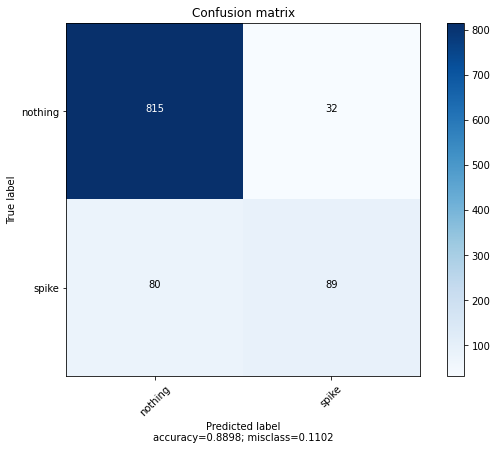


 0.51985559566787 

 58%|█████▊    | 116/200 [10:02<07:24,  5.29s/it, best loss: -0.6808510638297872]

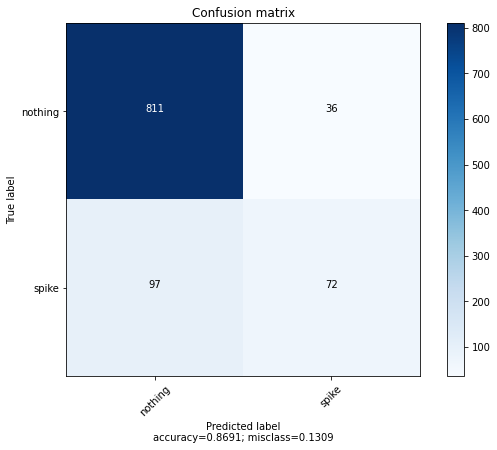


 0.6472727272727272 

 58%|█████▊    | 117/200 [10:09<06:05,  4.40s/it, best loss: -0.6808510638297872]

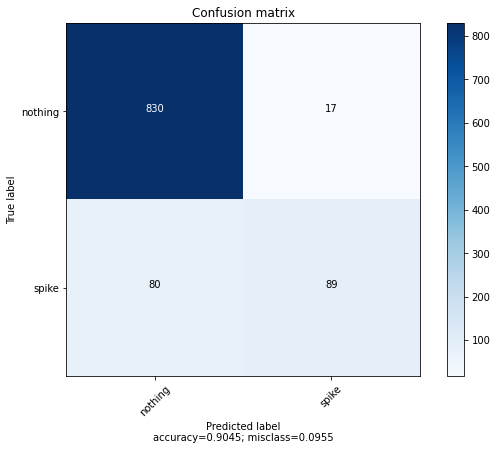


 0.608695652173913 

 59%|█████▉    | 118/200 [10:11<07:07,  5.22s/it, best loss: -0.6808510638297872]

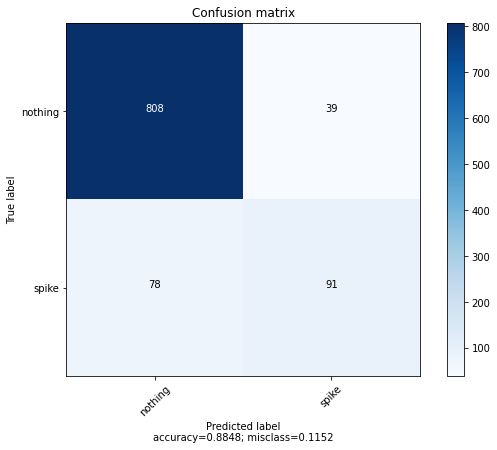


 0.6304347826086956 

 60%|█████▉    | 119/200 [10:17<05:49,  4.31s/it, best loss: -0.6808510638297872]

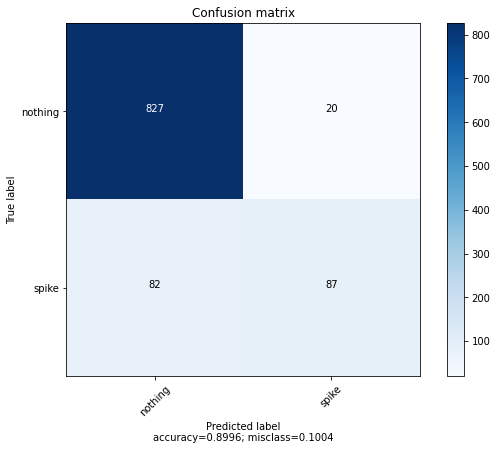


 0.6490066225165563 

 60%|██████    | 120/200 [10:22<06:10,  4.63s/it, best loss: -0.6808510638297872]

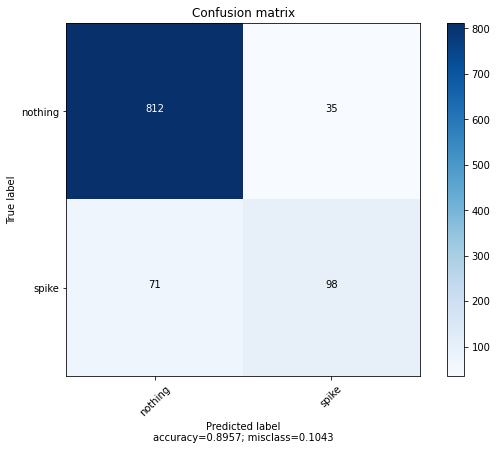


 0.6573426573426573 

 60%|██████    | 121/200 [10:27<06:13,  4.72s/it, best loss: -0.6808510638297872]

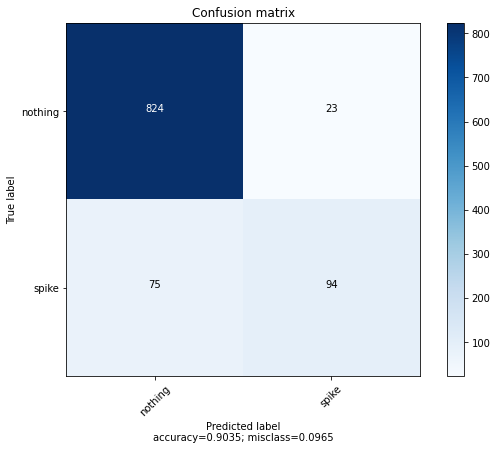


 0.6330935251798561 

 61%|██████    | 122/200 [10:32<06:14,  4.80s/it, best loss: -0.6808510638297872]

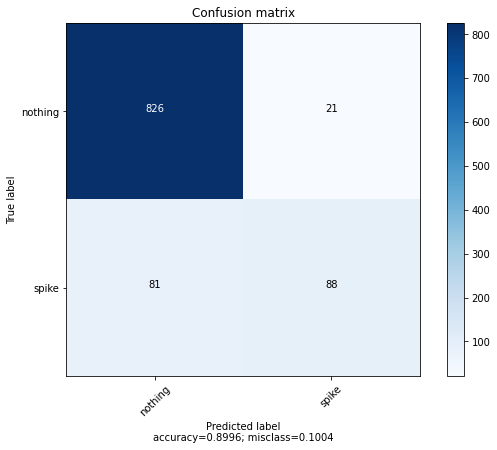


 0.6458333333333334 

 62%|██████▏   | 123/200 [10:36<06:18,  4.91s/it, best loss: -0.6808510638297872]

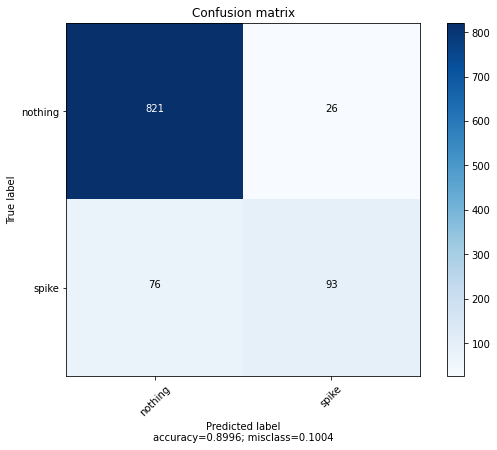


 0.6785714285714285 

 62%|██████▏   | 124/200 [10:43<06:02,  4.77s/it, best loss: -0.6808510638297872]

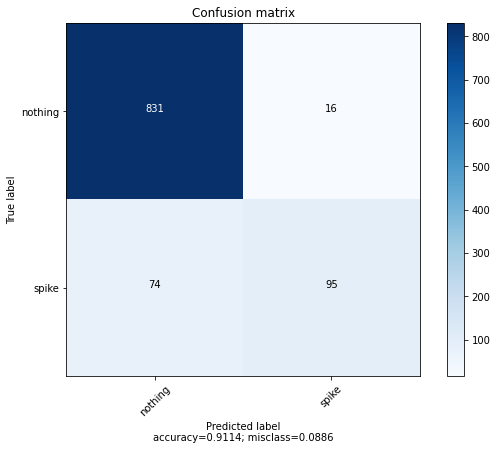


 0.6761565836298933 

 62%|██████▎   | 125/200 [10:48<06:42,  5.37s/it, best loss: -0.6808510638297872]

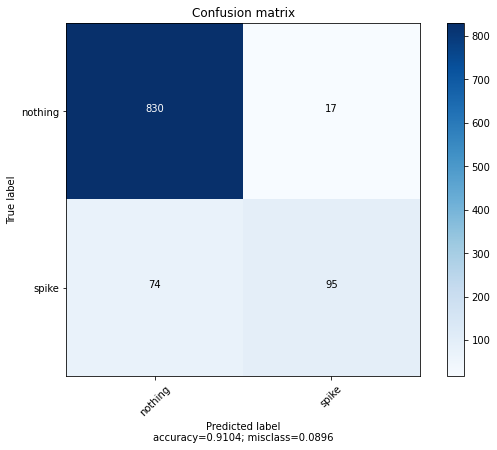


 0.6785714285714285 

 63%|██████▎   | 126/200 [10:55<06:19,  5.13s/it, best loss: -0.6808510638297872]

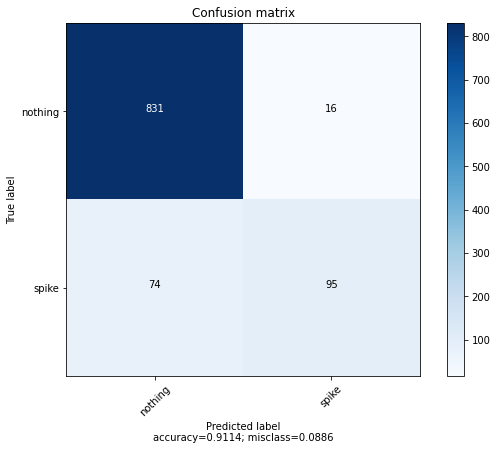


 0.5819397993311036 

 64%|██████▎   | 127/200 [10:57<07:14,  5.95s/it, best loss: -0.6808510638297872]

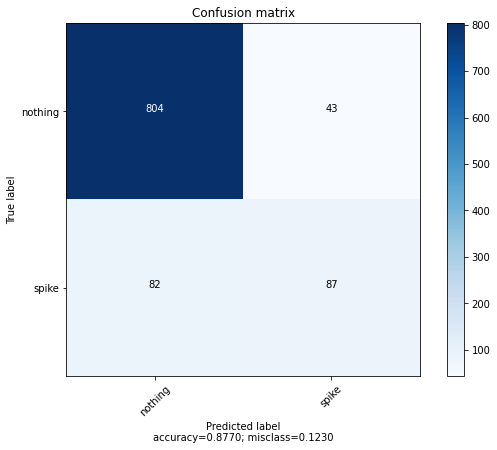


 0.6592592592592592 

 64%|██████▍   | 128/200 [11:06<05:31,  4.61s/it, best loss: -0.6808510638297872]

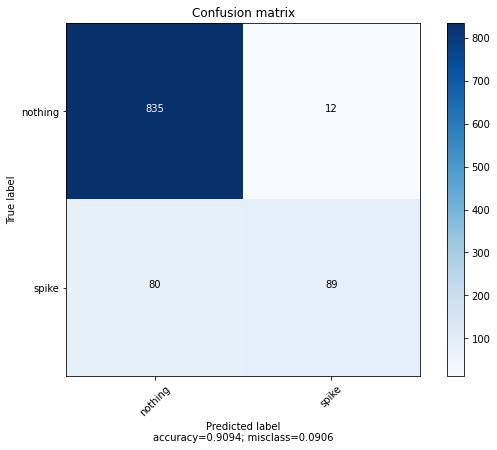


 0.6000000000000001 

 64%|██████▍   | 129/200 [11:11<07:00,  5.92s/it, best loss: -0.6808510638297872]

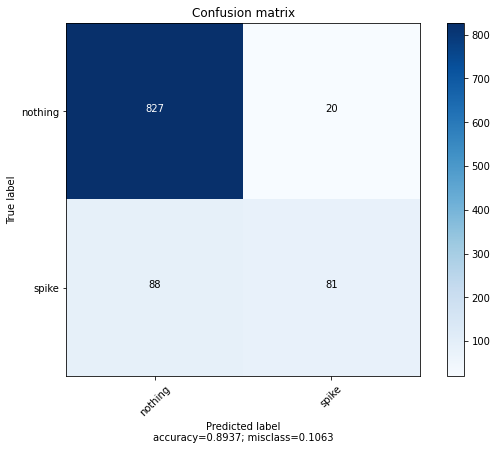


 0.6394052044609666 

 65%|██████▌   | 130/200 [11:20<06:43,  5.76s/it, best loss: -0.6808510638297872]

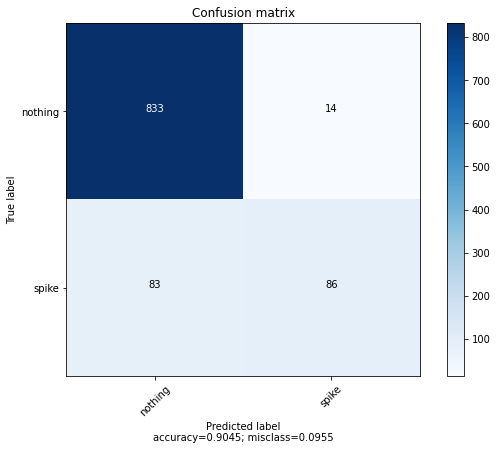


 0.6346863468634687 

 66%|██████▌   | 131/200 [11:28<07:43,  6.72s/it, best loss: -0.6808510638297872]

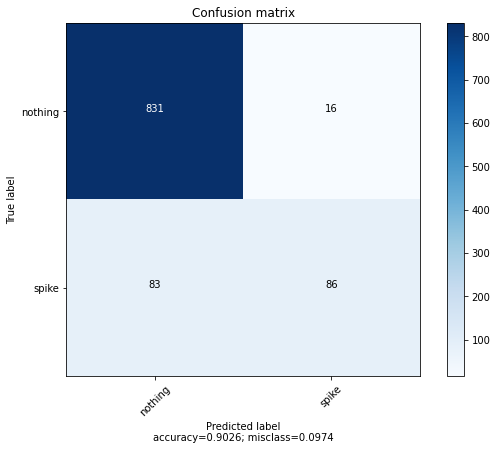


 0.6494464944649446 

 66%|██████▌   | 132/200 [11:35<08:04,  7.13s/it, best loss: -0.6808510638297872]

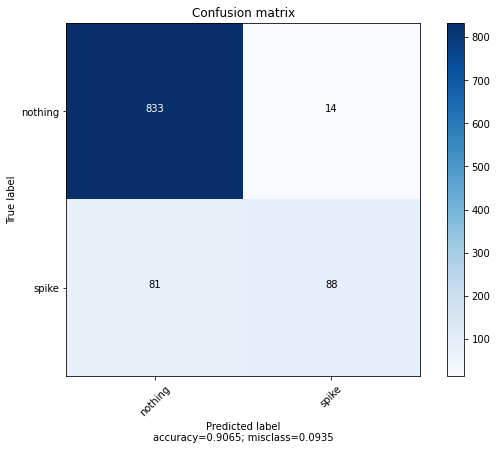


 0.625 

 66%|██████▋   | 133/200 [11:44<07:50,  7.03s/it, best loss: -0.6808510638297872]

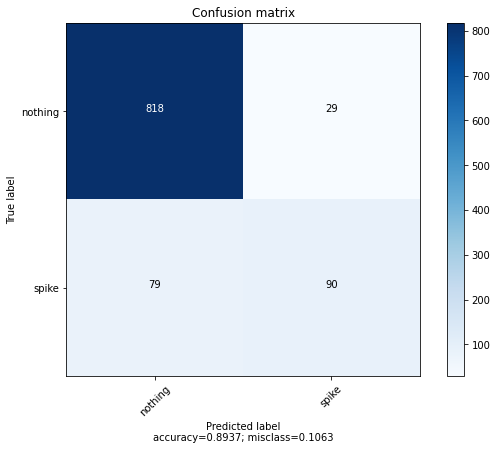


 0.6832740213523133 

 67%|██████▋   | 134/200 [11:51<08:11,  7.44s/it, best loss: -0.6808510638297872]

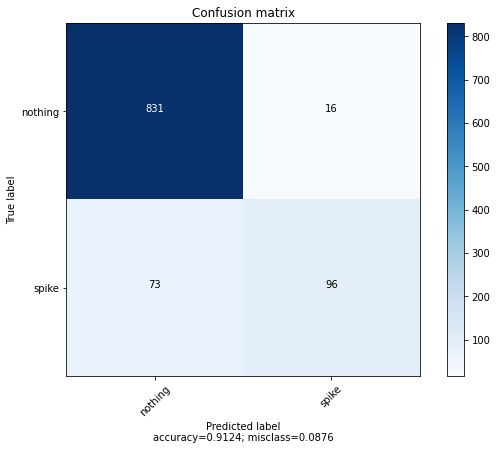


 0.6209150326797385 

 68%|██████▊   | 135/200 [11:54<08:04,  7.46s/it, best loss: -0.6832740213523133]

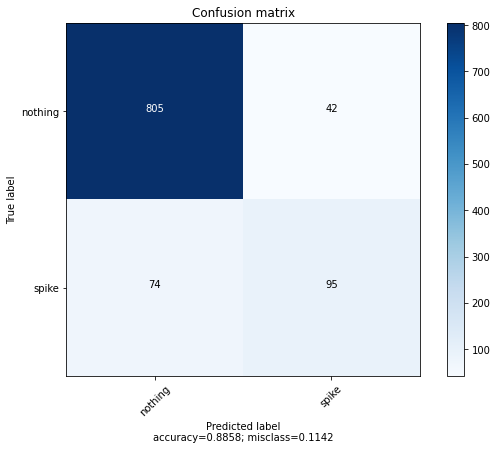


 0.6714801444043322 

 68%|██████▊   | 136/200 [11:59<06:28,  6.06s/it, best loss: -0.6832740213523133]

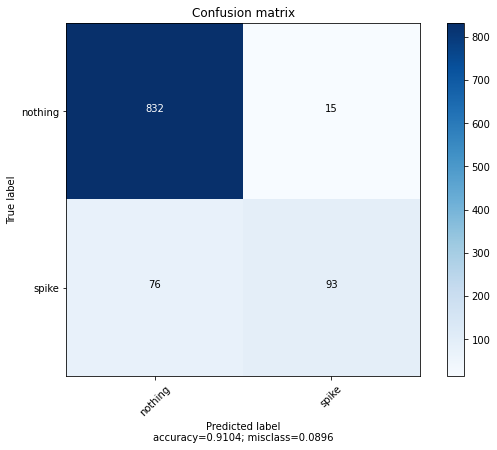


 0.644927536231884 

 68%|██████▊   | 137/200 [12:05<06:14,  5.94s/it, best loss: -0.6832740213523133]

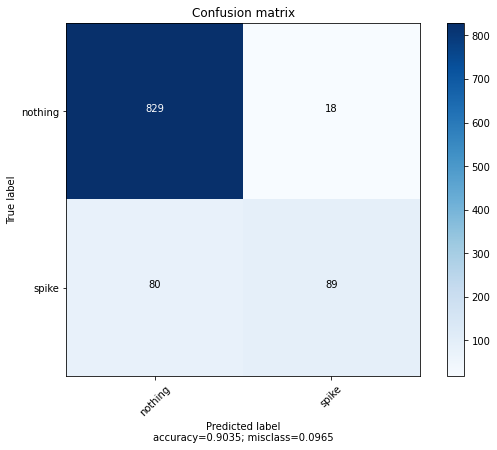


 0.6548042704626336 

 69%|██████▉   | 138/200 [12:10<05:57,  5.76s/it, best loss: -0.6832740213523133]

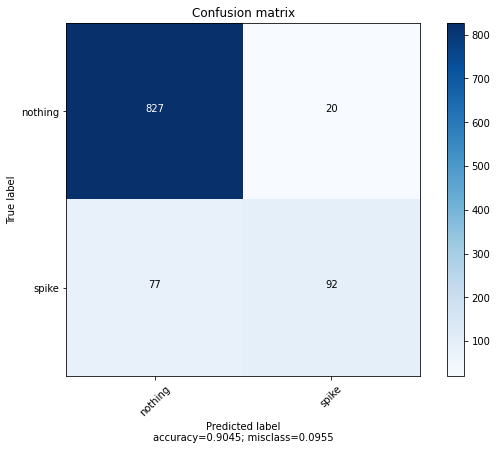


 0.6468646864686468 

 70%|██████▉   | 139/200 [12:16<05:39,  5.56s/it, best loss: -0.6832740213523133]

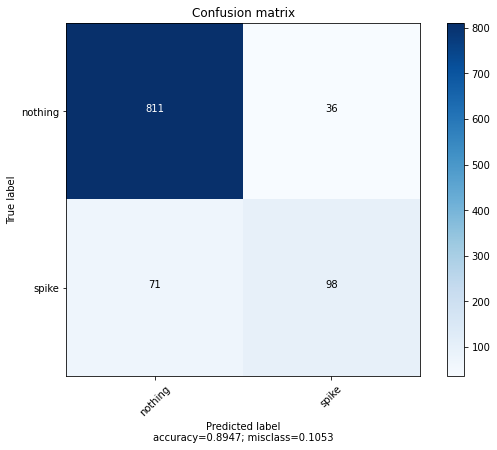


 0.6713780918727915 

 70%|███████   | 140/200 [12:23<05:44,  5.74s/it, best loss: -0.6832740213523133]

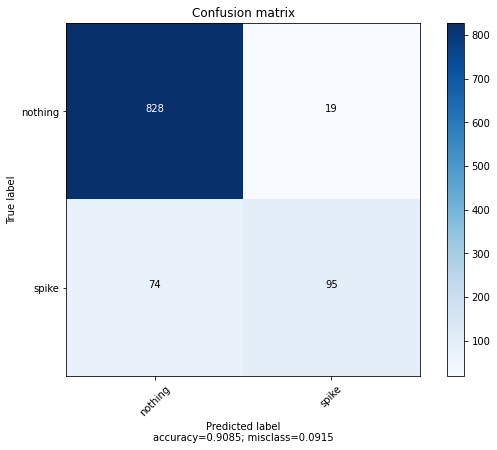


 0.4682080924855491 

 70%|███████   | 141/200 [12:24<06:00,  6.11s/it, best loss: -0.6832740213523133]

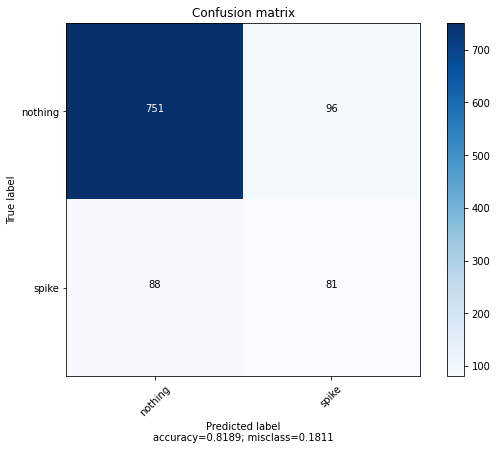


 0.6494464944649446 

 71%|███████   | 142/200 [12:31<04:20,  4.50s/it, best loss: -0.6832740213523133]

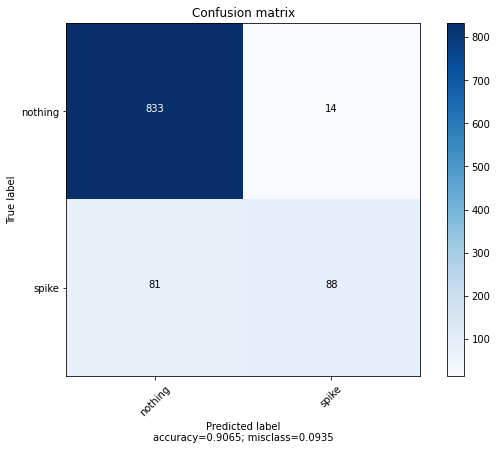


 0.6420664206642067 

 72%|███████▏  | 143/200 [12:37<05:03,  5.32s/it, best loss: -0.6832740213523133]

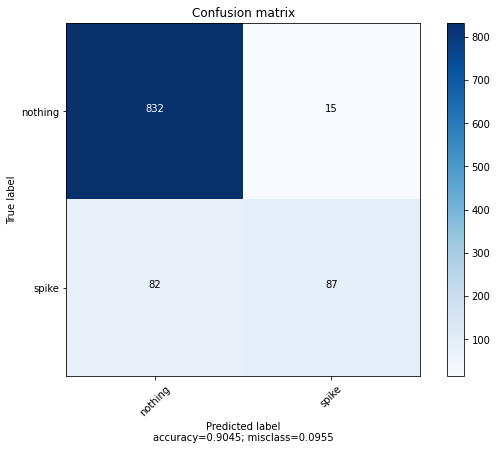


 0.6420664206642067 

 72%|███████▏  | 144/200 [12:44<05:03,  5.41s/it, best loss: -0.6832740213523133]

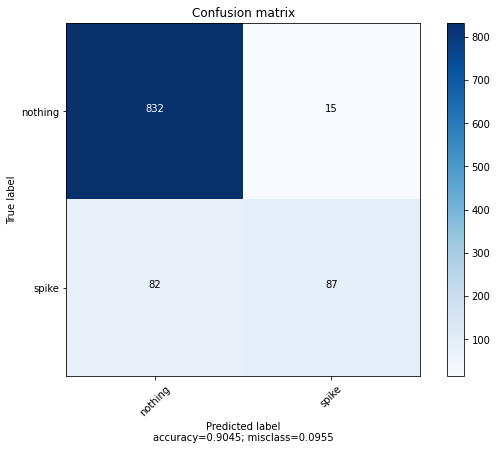


 0.62453531598513 

 72%|███████▎  | 145/200 [12:51<05:35,  6.10s/it, best loss: -0.6832740213523133]

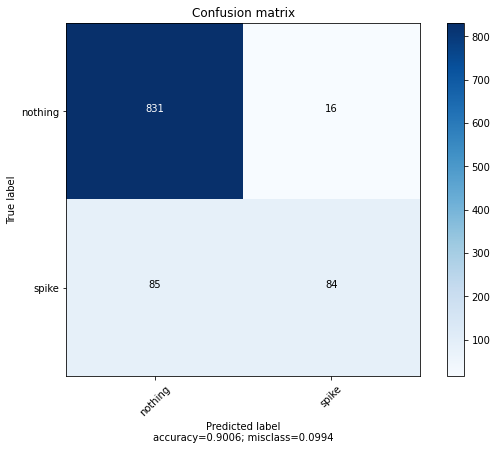


 0.6370370370370371 

 73%|███████▎  | 146/200 [12:59<05:43,  6.36s/it, best loss: -0.6832740213523133]

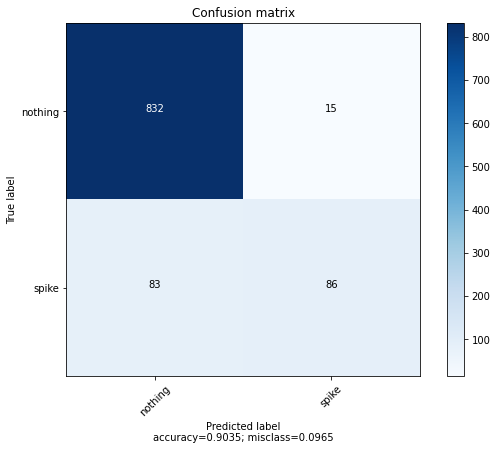


 0.656934306569343 

 74%|███████▎  | 147/200 [13:07<05:57,  6.75s/it, best loss: -0.6832740213523133]

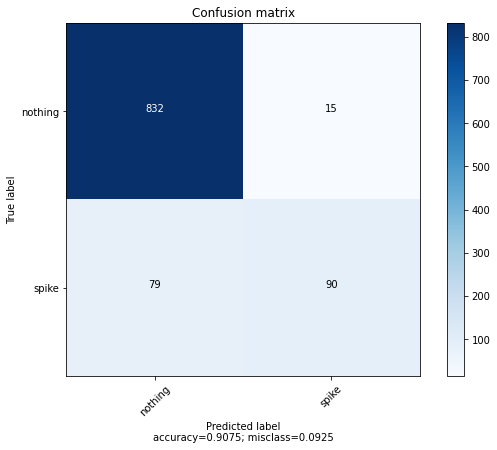


 0.6807017543859648 

 74%|███████▍  | 148/200 [13:14<06:10,  7.13s/it, best loss: -0.6832740213523133]

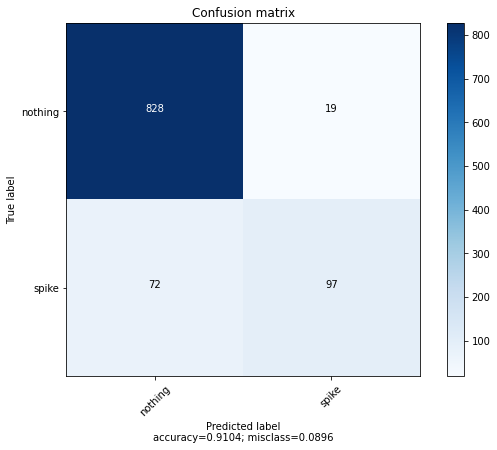


 0.6784452296819788 

 74%|███████▍  | 149/200 [13:20<05:59,  7.04s/it, best loss: -0.6832740213523133]

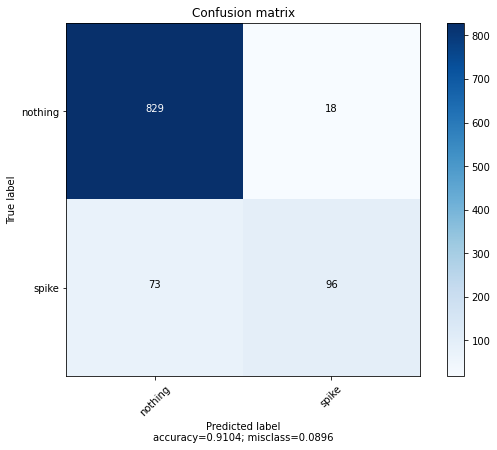


 0.6761565836298933 

 75%|███████▌  | 150/200 [13:27<05:39,  6.79s/it, best loss: -0.6832740213523133]

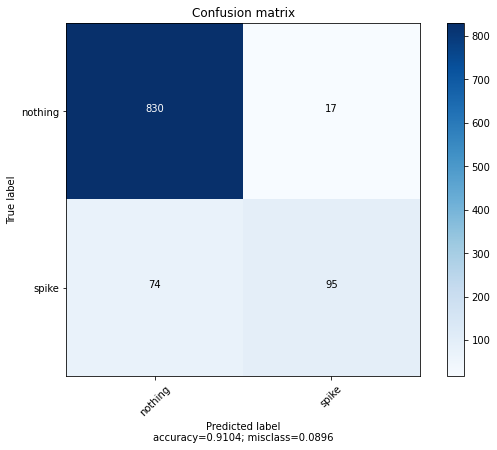


 0.6343283582089552 

 76%|███████▌  | 151/200 [13:35<05:39,  6.93s/it, best loss: -0.6832740213523133]

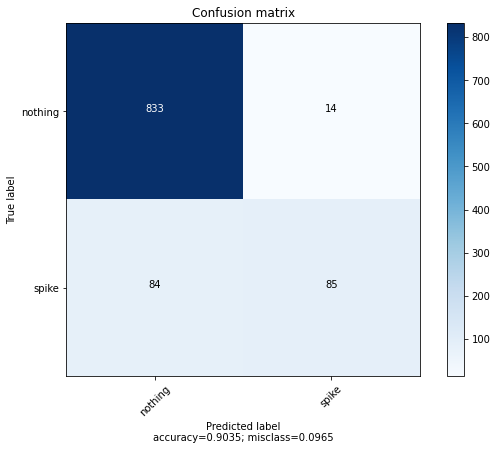


 0.6346863468634687 

 76%|███████▌  | 152/200 [13:42<05:45,  7.21s/it, best loss: -0.6832740213523133]

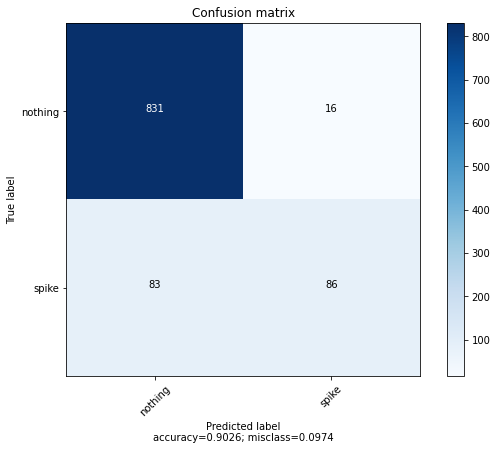


 0.6591760299625468 

 76%|███████▋  | 153/200 [13:50<05:28,  6.98s/it, best loss: -0.6832740213523133]

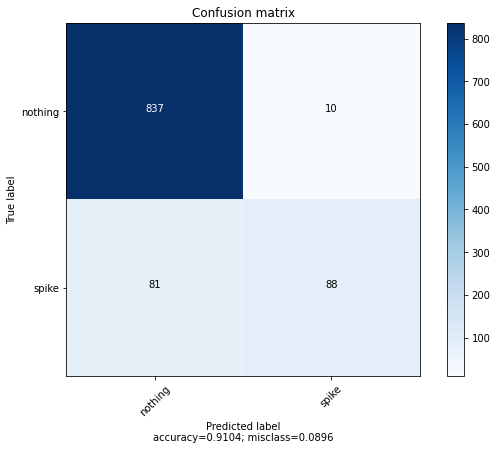


 0.6236559139784946 

 77%|███████▋  | 154/200 [13:56<05:47,  7.56s/it, best loss: -0.6832740213523133]

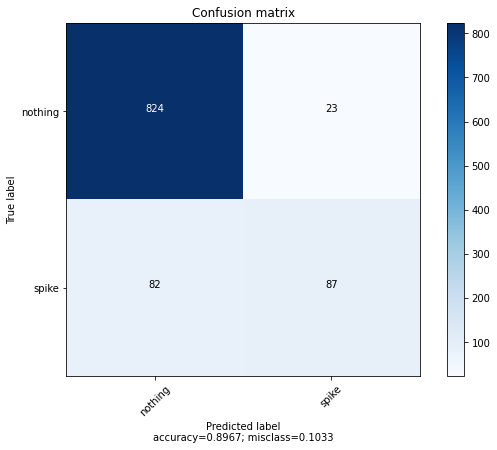


 0.6739926739926739 

 78%|███████▊  | 155/200 [14:04<05:12,  6.95s/it, best loss: -0.6832740213523133]

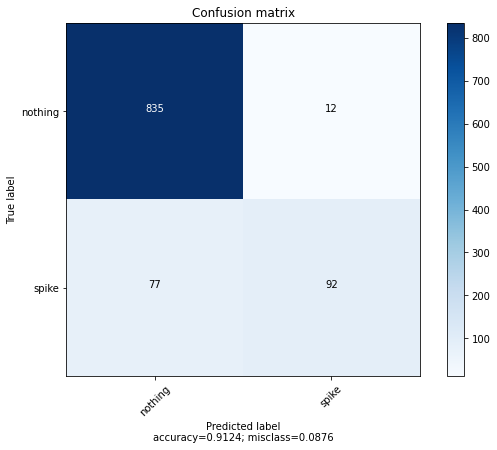


 0.6367041198501873 

 78%|███████▊  | 156/200 [14:10<05:14,  7.14s/it, best loss: -0.6832740213523133]

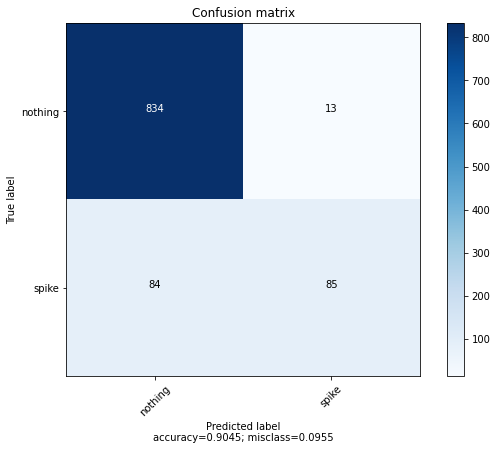


 0.6315789473684211 

 78%|███████▊  | 157/200 [14:24<04:54,  6.84s/it, best loss: -0.6832740213523133]

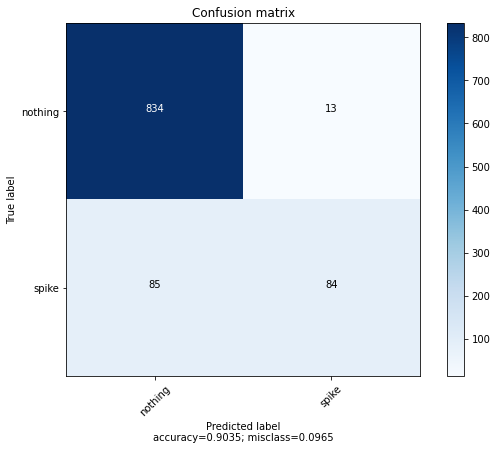


 0.6397058823529412 

 79%|███████▉  | 158/200 [14:30<06:16,  8.97s/it, best loss: -0.6832740213523133]

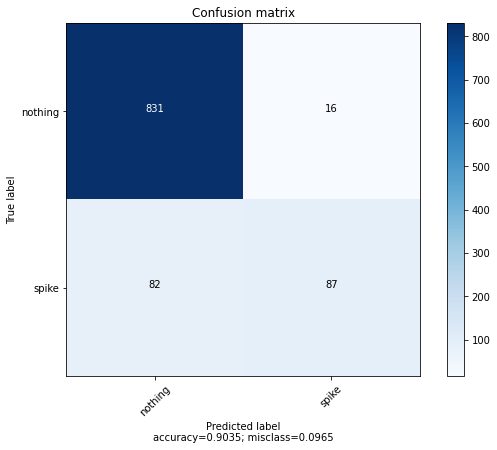


 0.6446886446886446 

 80%|███████▉  | 159/200 [14:36<05:31,  8.09s/it, best loss: -0.6832740213523133]

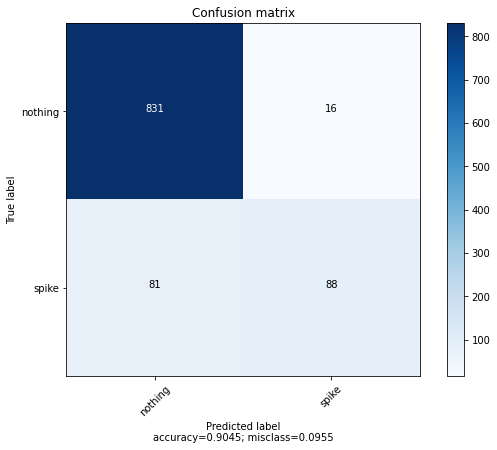


 0.6357142857142858 

 80%|████████  | 160/200 [14:47<05:01,  7.53s/it, best loss: -0.6832740213523133]

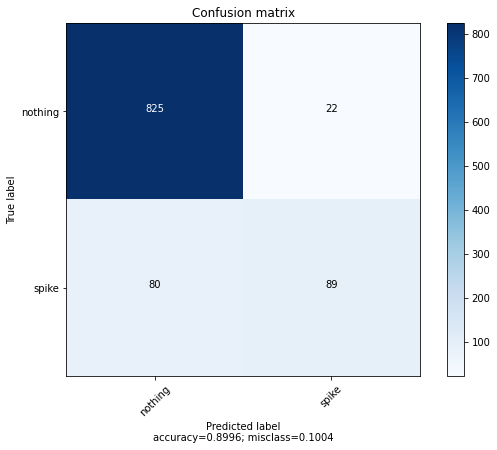


 0.5824561403508772 

 80%|████████  | 161/200 [14:50<05:37,  8.65s/it, best loss: -0.6832740213523133]

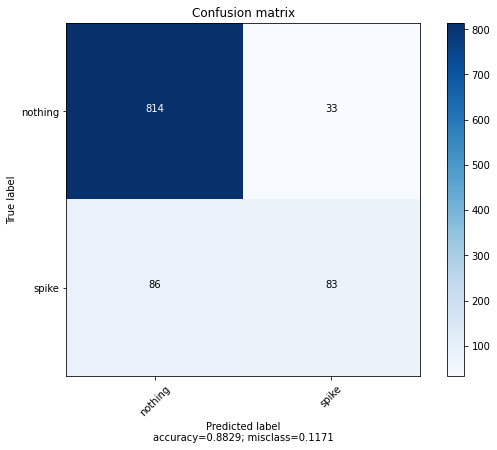


 0.6373626373626374 

 81%|████████  | 162/200 [14:57<04:26,  7.02s/it, best loss: -0.6832740213523133]

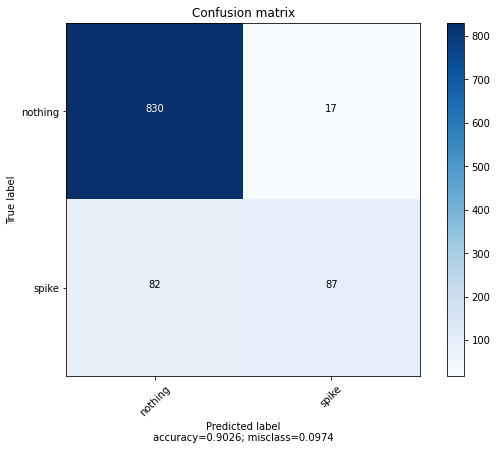


 0.6594202898550725 

 82%|████████▏ | 163/200 [15:03<04:19,  7.02s/it, best loss: -0.6832740213523133]

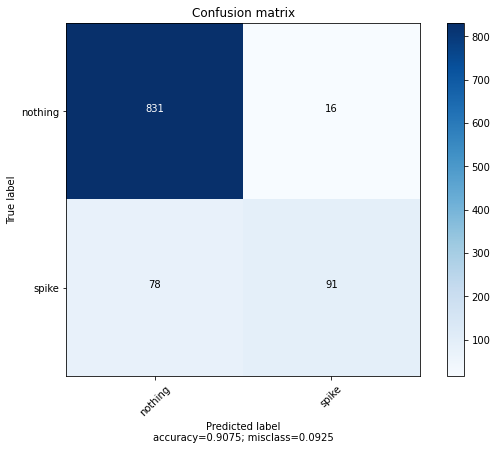


 0.6592592592592592 

 82%|████████▏ | 164/200 [15:08<03:54,  6.52s/it, best loss: -0.6832740213523133]

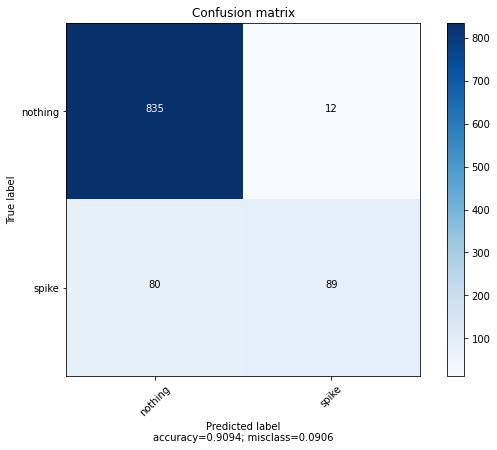


 0.6498194945848376 

 82%|████████▎ | 165/200 [15:14<03:39,  6.27s/it, best loss: -0.6832740213523133]

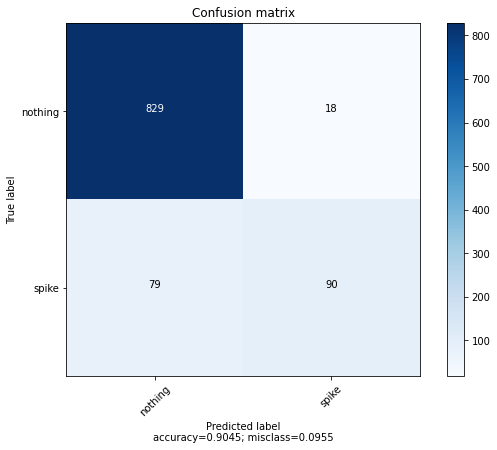


 0.6575342465753424 

 83%|████████▎ | 166/200 [15:21<03:30,  6.19s/it, best loss: -0.6832740213523133]

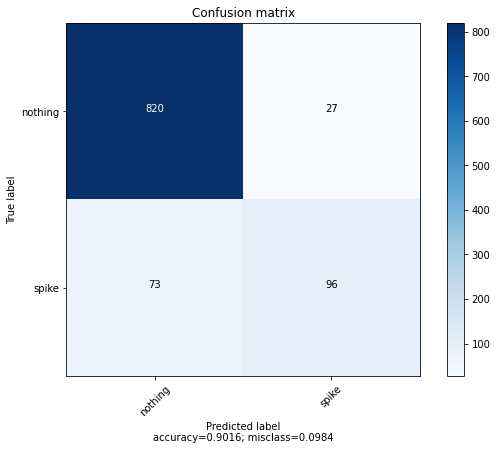


 0.6350364963503651 

 84%|████████▎ | 167/200 [15:26<03:26,  6.26s/it, best loss: -0.6832740213523133]

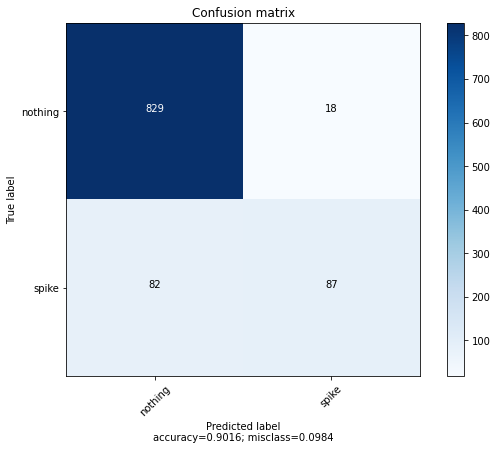


 0.5762711864406781 

 84%|████████▍ | 168/200 [15:28<03:11,  5.99s/it, best loss: -0.6832740213523133]

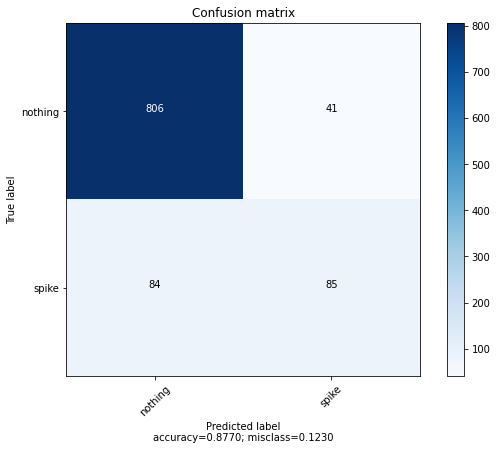


 0.6376811594202898 

 84%|████████▍ | 169/200 [15:33<02:27,  4.75s/it, best loss: -0.6832740213523133]

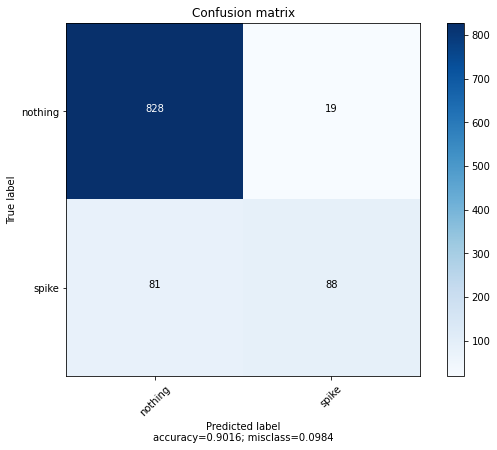


 0.6903914590747332 

 85%|████████▌ | 170/200 [15:38<02:21,  4.72s/it, best loss: -0.6832740213523133]

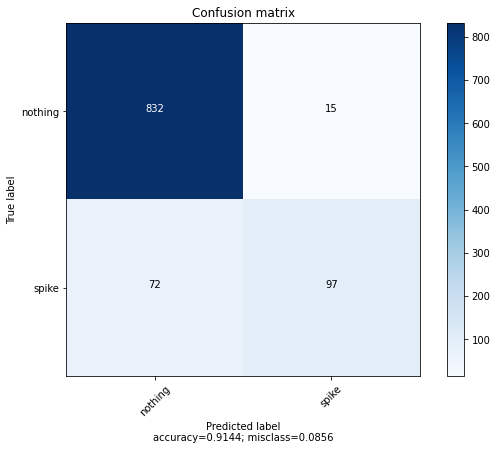


 0.6245614035087719 

 86%|████████▌ | 171/200 [15:41<02:18,  4.76s/it, best loss: -0.6903914590747332]

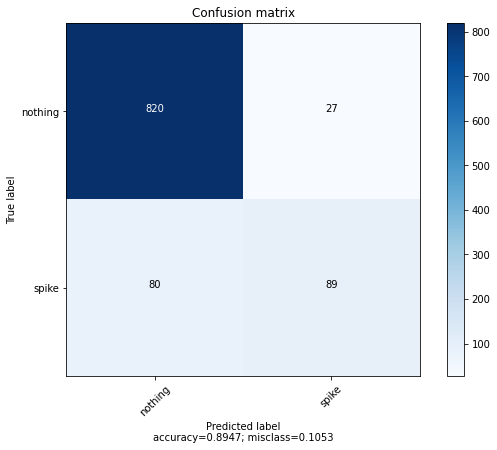


 0.6508474576271186 

 86%|████████▌ | 172/200 [15:43<02:01,  4.36s/it, best loss: -0.6903914590747332]

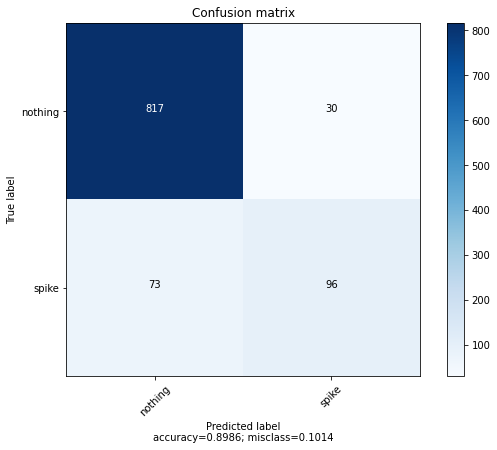


 0.6442953020134228 

 86%|████████▋ | 173/200 [15:49<01:39,  3.68s/it, best loss: -0.6903914590747332]

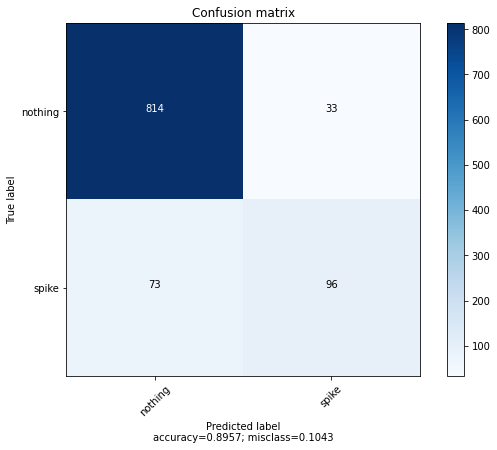


 0.6785714285714285 

 87%|████████▋ | 174/200 [15:53<01:53,  4.35s/it, best loss: -0.6903914590747332]

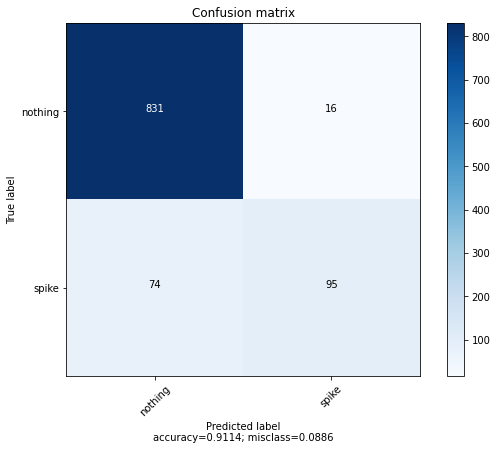


 0.6363636363636364 

 88%|████████▊ | 175/200 [15:56<01:47,  4.30s/it, best loss: -0.6903914590747332]

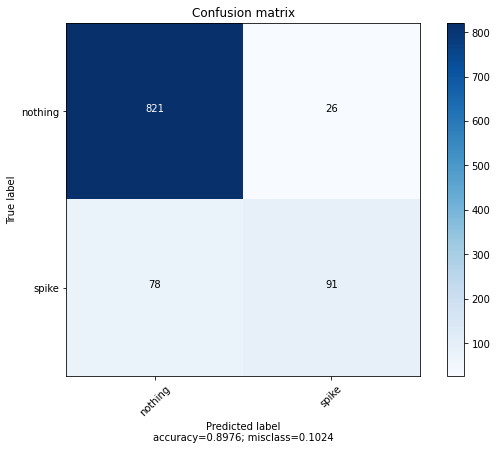


 0.6277372262773723 

 88%|████████▊ | 176/200 [16:00<01:31,  3.83s/it, best loss: -0.6903914590747332]

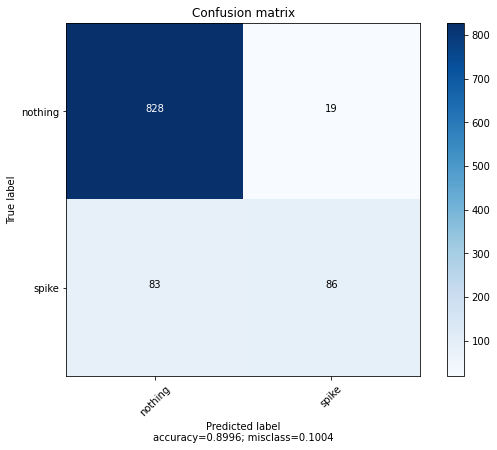


 0.6642857142857144 

 88%|████████▊ | 177/200 [16:05<01:27,  3.81s/it, best loss: -0.6903914590747332]

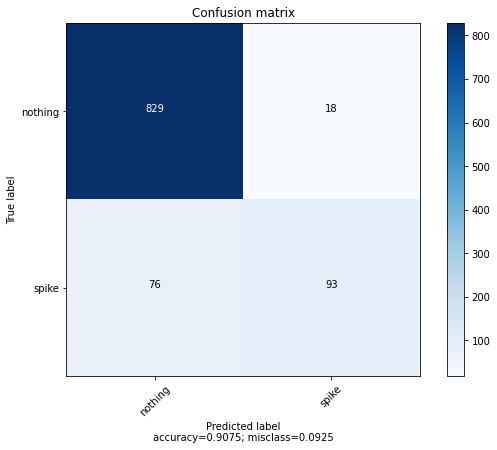


 0.6344827586206897 

 89%|████████▉ | 178/200 [16:07<01:34,  4.28s/it, best loss: -0.6903914590747332]

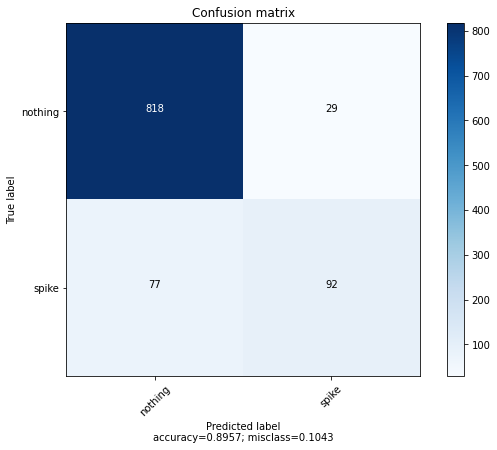


 0.6180555555555556 

 90%|████████▉ | 179/200 [16:10<01:17,  3.68s/it, best loss: -0.6903914590747332]

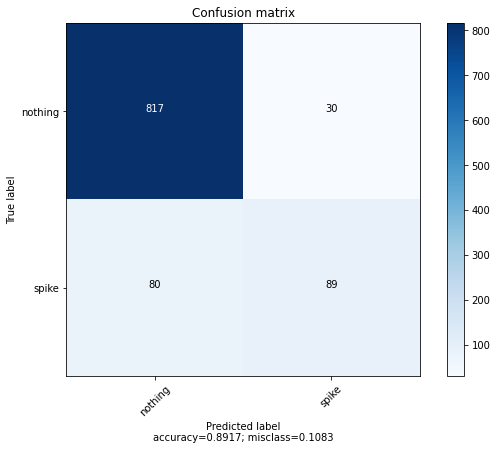


 0.6621621621621622 

 90%|█████████ | 180/200 [16:15<01:06,  3.31s/it, best loss: -0.6903914590747332]

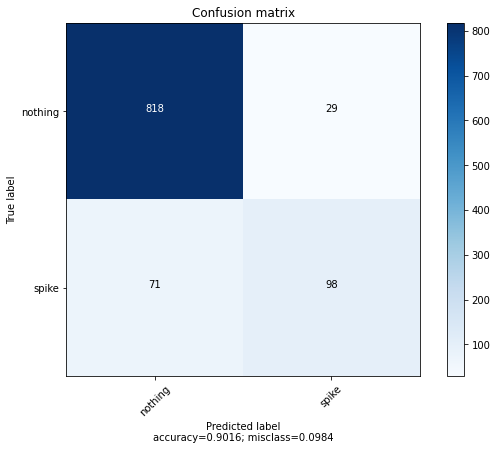


 0.6474820143884894 

 90%|█████████ | 181/200 [16:20<01:13,  3.89s/it, best loss: -0.6903914590747332]

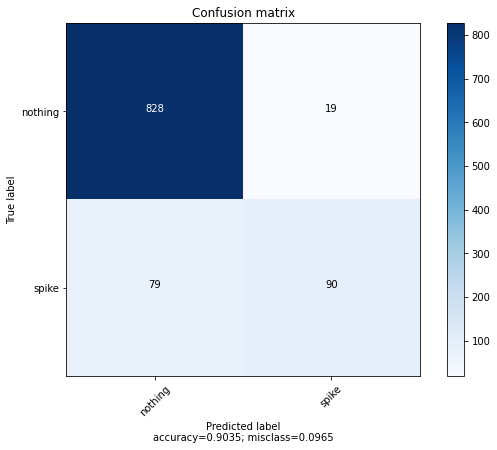


 0.6099290780141844 

 91%|█████████ | 182/200 [16:24<01:15,  4.19s/it, best loss: -0.6903914590747332]

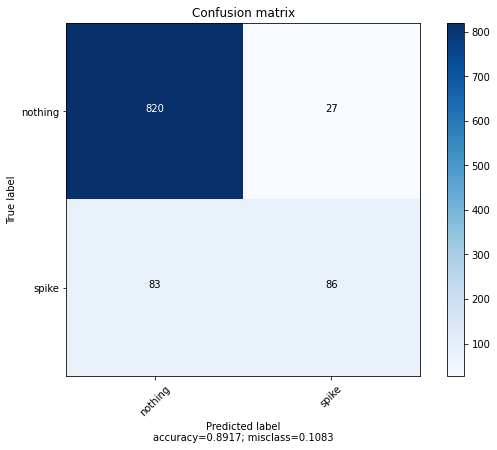


 0.5240963855421688 

 92%|█████████▏| 183/200 [16:24<01:08,  4.02s/it, best loss: -0.6903914590747332]

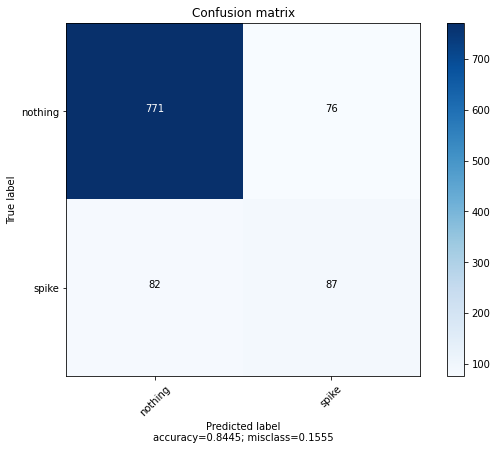


 0.5548780487804879 

 92%|█████████▏| 184/200 [16:25<00:48,  3.04s/it, best loss: -0.6903914590747332]

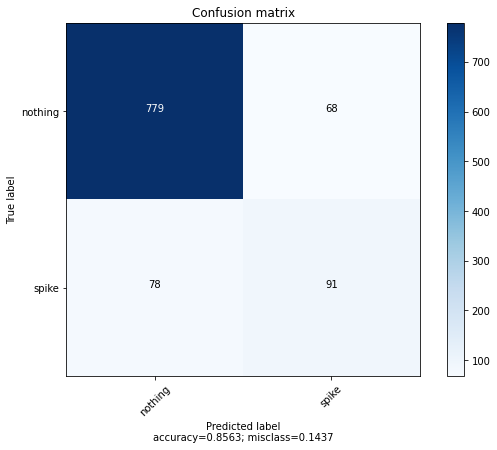


 0.6739926739926739 

 92%|█████████▎| 185/200 [16:29<00:36,  2.40s/it, best loss: -0.6903914590747332]

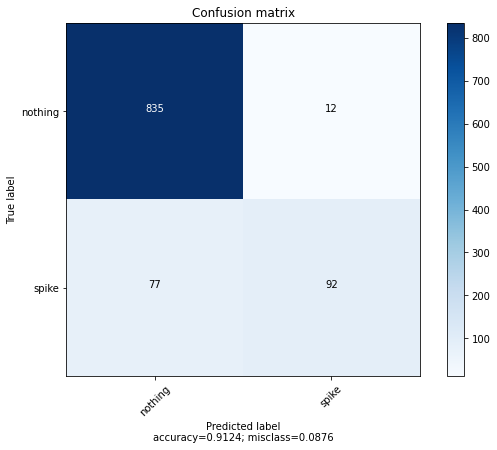


 0.611295681063123 

 93%|█████████▎| 186/200 [16:31<00:39,  2.81s/it, best loss: -0.6903914590747332]

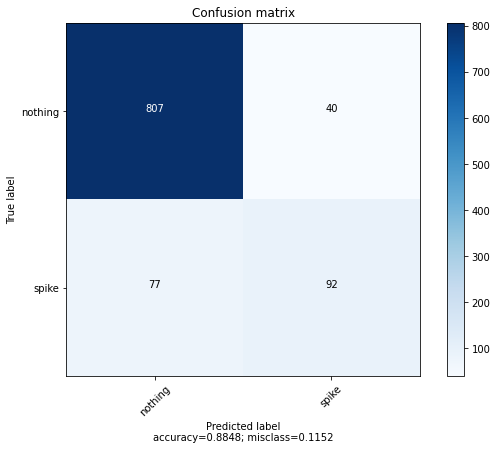


 0.6526315789473685 

 94%|█████████▎| 187/200 [16:39<00:32,  2.50s/it, best loss: -0.6903914590747332]

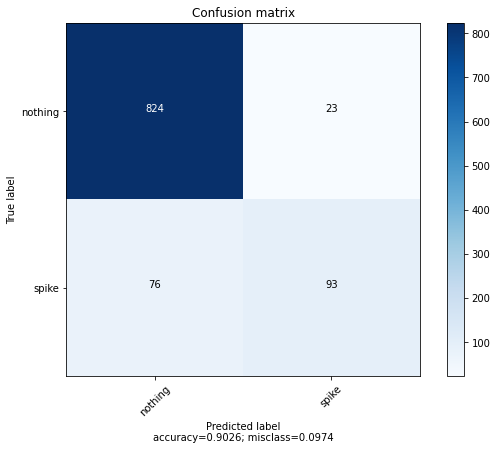


 0.6105263157894737 

 94%|█████████▍| 188/200 [16:42<00:52,  4.34s/it, best loss: -0.6903914590747332]

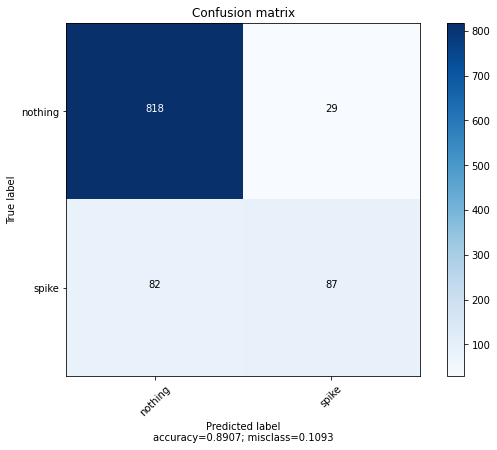


 0.5894736842105264 

 94%|█████████▍| 189/200 [16:46<00:42,  3.90s/it, best loss: -0.6903914590747332]

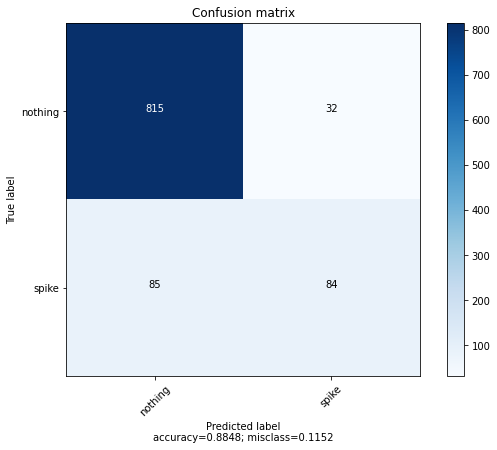


 0.6164874551971327 

 95%|█████████▌| 190/200 [16:50<00:38,  3.84s/it, best loss: -0.6903914590747332]

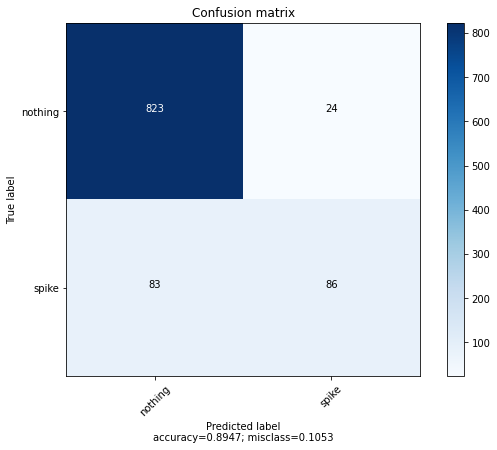


 0.6376811594202898 

 96%|█████████▌| 191/200 [16:55<00:34,  3.86s/it, best loss: -0.6903914590747332]

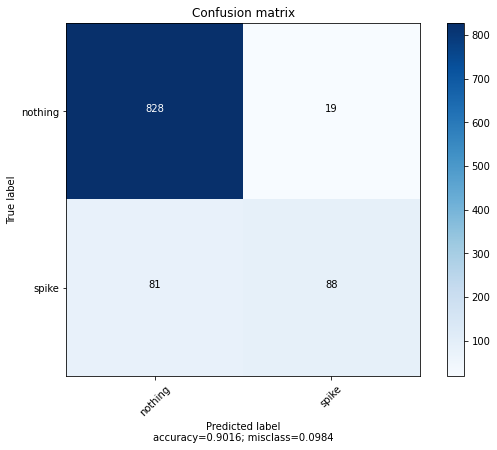


 0.6346863468634687 

 96%|█████████▌| 192/200 [17:01<00:33,  4.13s/it, best loss: -0.6903914590747332]

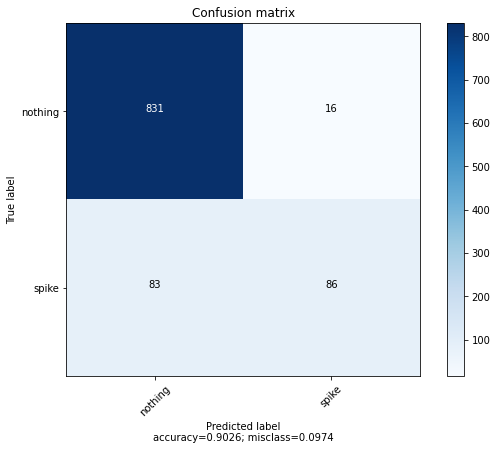


 0.6474820143884894 

 96%|█████████▋| 193/200 [17:09<00:33,  4.84s/it, best loss: -0.6903914590747332]

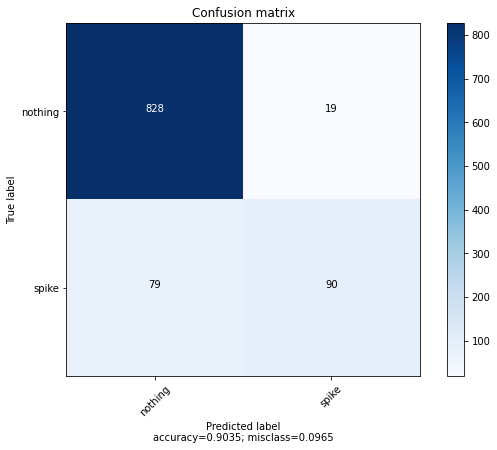


 0.6426229508196721 

 97%|█████████▋| 194/200 [17:11<00:34,  5.77s/it, best loss: -0.6903914590747332]

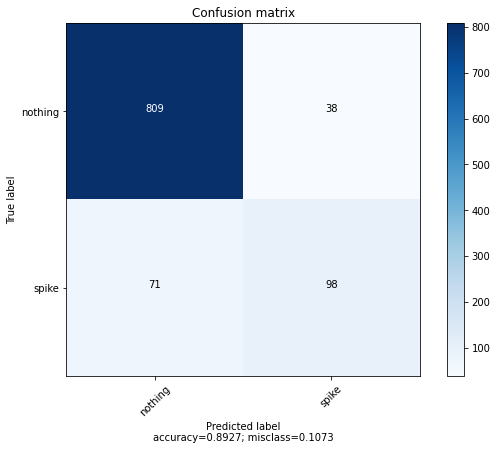


 0.6478873239436621 

 98%|█████████▊| 195/200 [17:14<00:23,  4.67s/it, best loss: -0.6903914590747332]

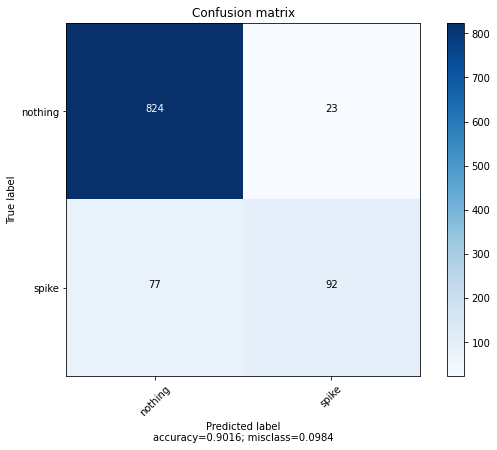


 0.5745454545454546 

 98%|█████████▊| 196/200 [17:17<00:16,  4.12s/it, best loss: -0.6903914590747332]

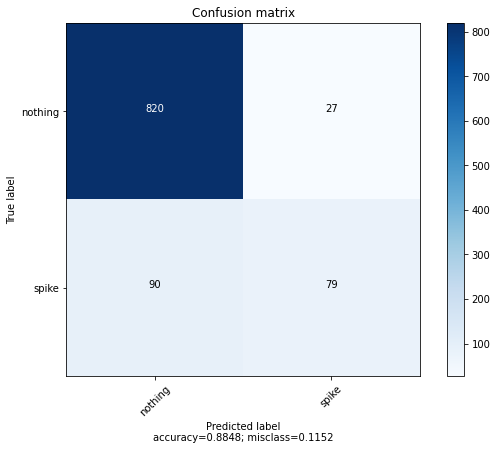


 0.6857142857142857 

 98%|█████████▊| 197/200 [17:24<00:11,  3.90s/it, best loss: -0.6903914590747332]

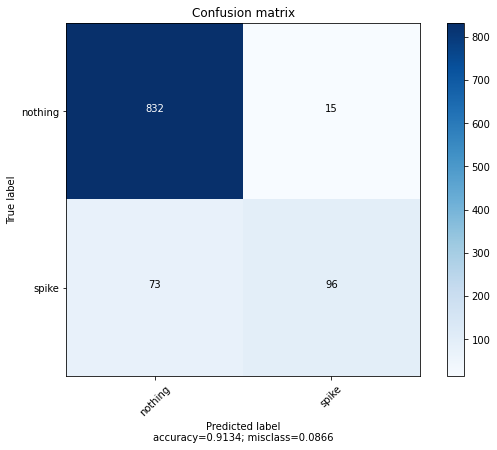


 0.6763636363636364 

 99%|█████████▉| 198/200 [17:32<00:09,  4.73s/it, best loss: -0.6903914590747332]

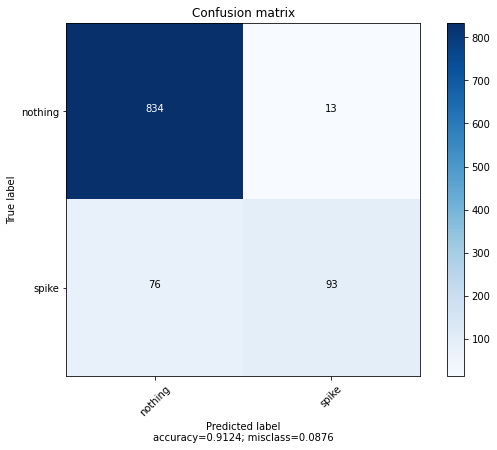


 0.6906474820143885 

100%|█████████▉| 199/200 [17:37<00:05,  5.61s/it, best loss: -0.6903914590747332]

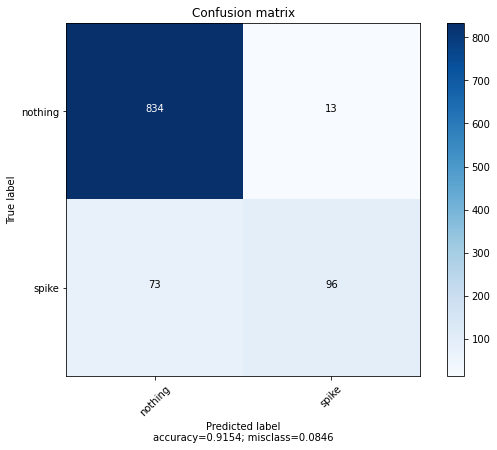

100%|██████████| 200/200 [17:37<00:00,  5.29s/it, best loss: -0.6906474820143885]

 
 1057.9183628559113


In [29]:

hhh = HPOpt( rosemary )
start = time.time()
best_params, trials_obj = hhh.process( fn_name = 'objective', space = SPACE, trials = Trials(), algo = tpe.suggest, max_evals = 200 ) #max_evals will be increased
print( '\n \n {}'.format( time.time() - start ) )


In [ ]:
rosemary = Tuner()
rosemary.choose_classifier( 'LGB' )
rosemary.best_params = best_params 
cash, gt, pred = rosemary.train_tuned( multicollinearity = True )

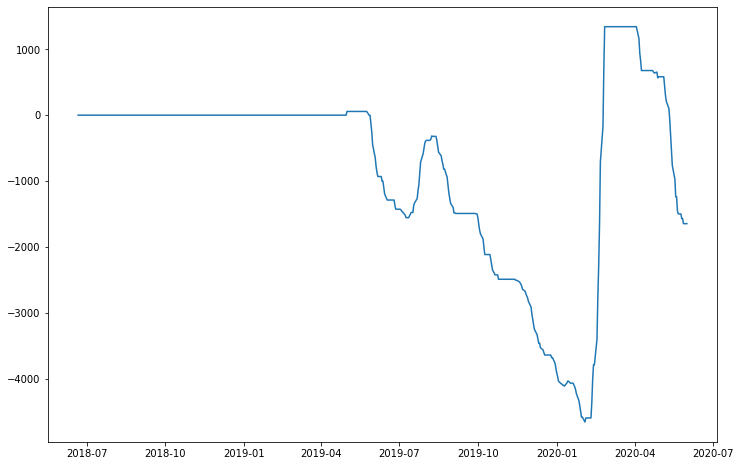

In [35]:
plt.figure( figsize = (12,8) )
plt.plot(rosemary.TEST_DATES, cash[ 13 : ] )

#Son konuştuğumuz gibi, tüm dataya train test split, smotetomek, hyperparameter tuning, train_test split for btest, smotetomek, train with b_params, test

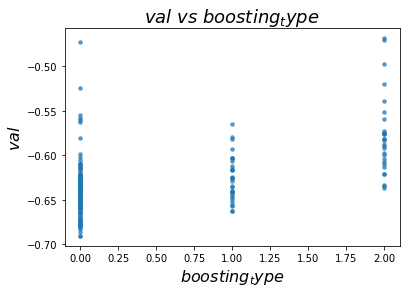

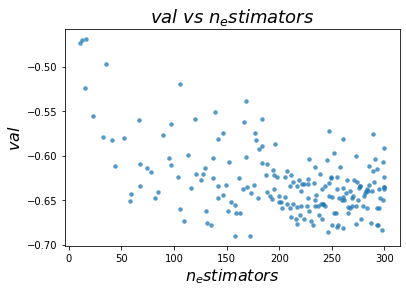

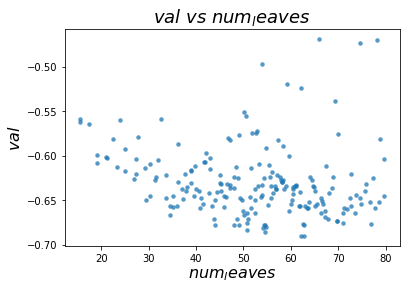

In [36]:
keyz = list(best_params.keys())
for key in keyz:
    plot_loss_vs_param( key )

#LOSS VS HP



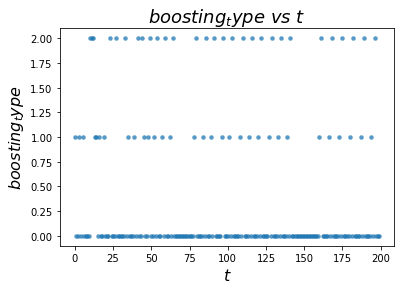

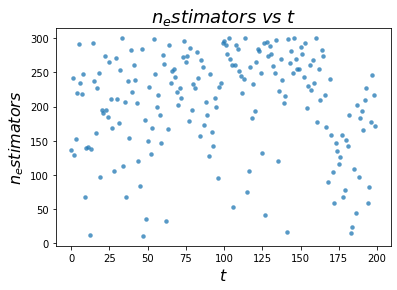

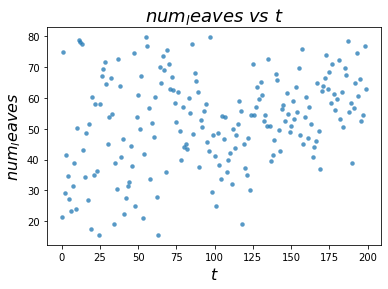

In [37]:

for key in keyz:
    plot_param_vs_time( key )
#HP VS TIME


 PREPROCESSING 


 DEFINING CLASSES 


 0.7924528301886793 

  0%|          | 0/200 [00:04<?, ?it/s, best loss: ?]

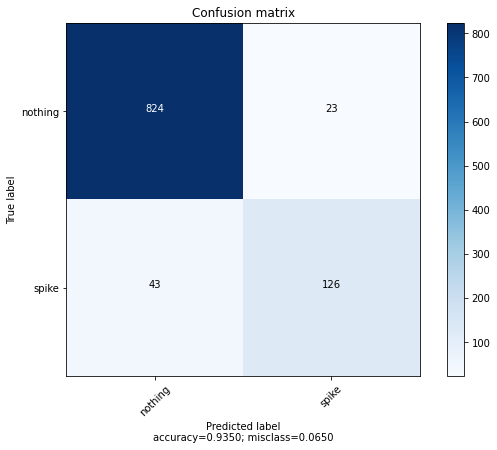


 0.7934426229508197 

  0%|          | 1/200 [00:11<15:32,  4.69s/it, best loss: -0.7924528301886793]

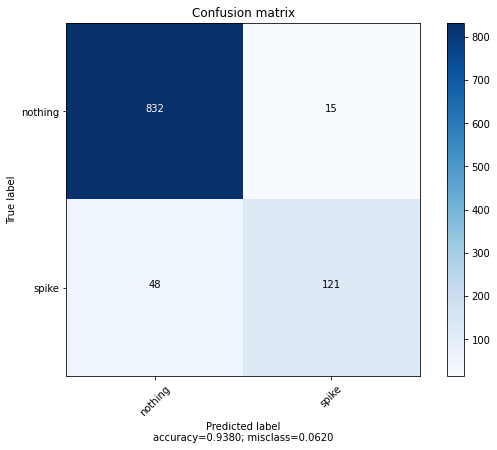


 0.7634069400630916 

  1%|          | 2/200 [00:14<17:32,  5.32s/it, best loss: -0.7934426229508197]

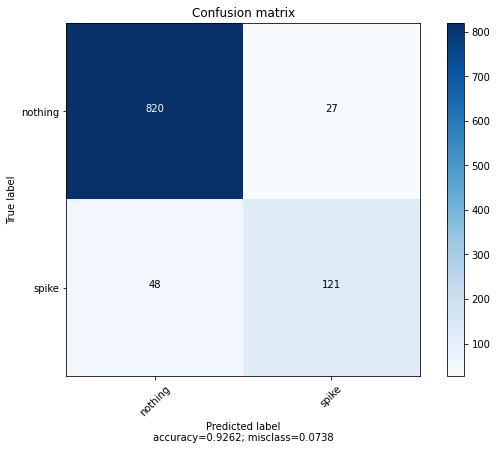


 0.8116883116883117 

  2%|▏         | 3/200 [00:25<15:28,  4.71s/it, best loss: -0.7934426229508197]

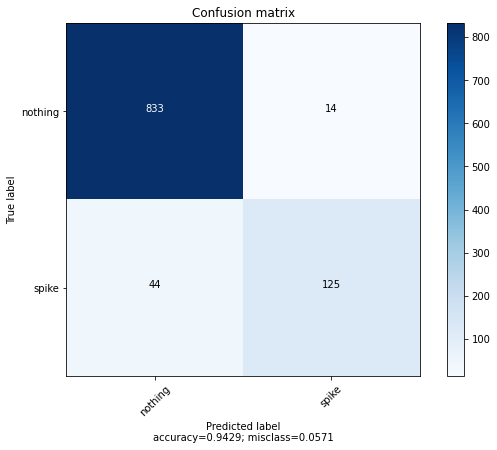


 0.7999999999999999 

  2%|▏         | 4/200 [00:41<21:41,  6.64s/it, best loss: -0.8116883116883117]

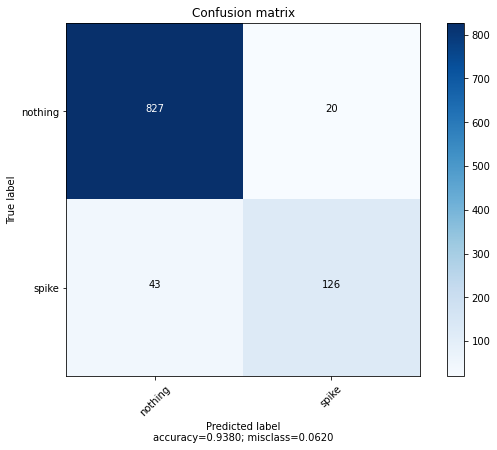


 0.7608069164265131 

  2%|▎         | 5/200 [00:43<30:43,  9.46s/it, best loss: -0.8116883116883117]

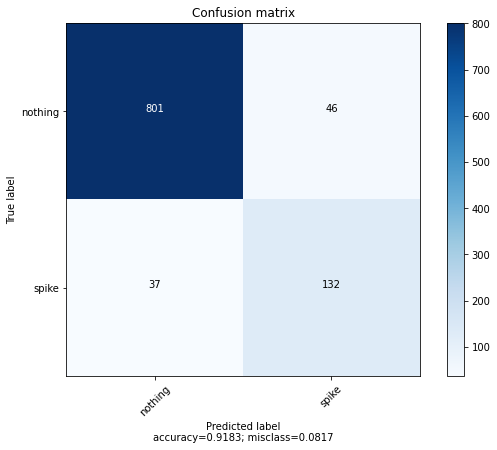


 0.8172757475083057 

  3%|▎         | 6/200 [00:56<23:29,  7.27s/it, best loss: -0.8116883116883117]

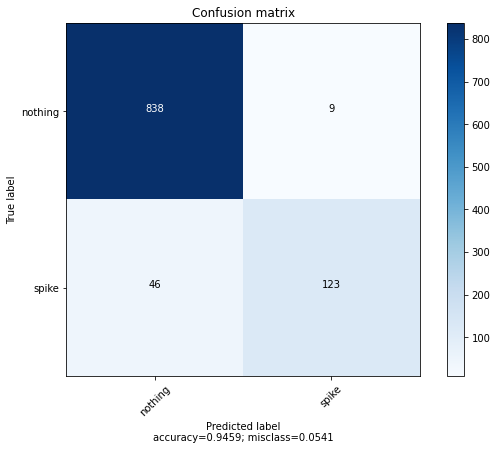


 0.7607361963190183 

  4%|▎         | 7/200 [00:58<28:31,  8.87s/it, best loss: -0.8172757475083057]

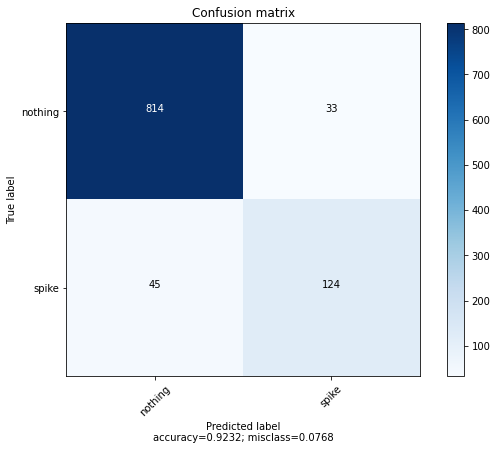


 0.8098159509202454 

  4%|▍         | 8/200 [01:06<22:01,  6.88s/it, best loss: -0.8172757475083057]

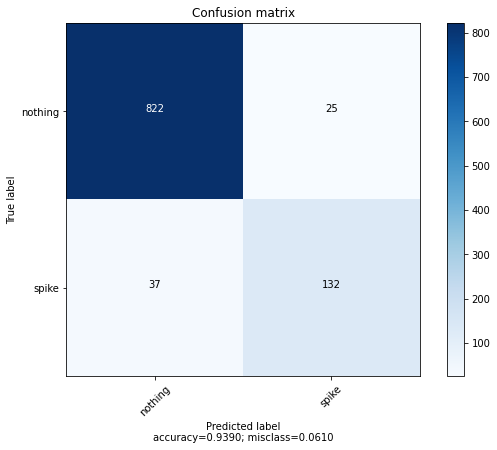


 0.7951070336391437 

  4%|▍         | 9/200 [01:09<22:48,  7.16s/it, best loss: -0.8172757475083057]

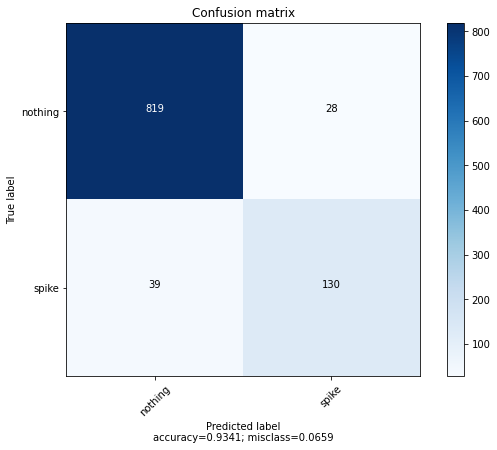


 0.7774086378737541 

  5%|▌         | 10/200 [01:18<18:59,  6.00s/it, best loss: -0.8172757475083057]

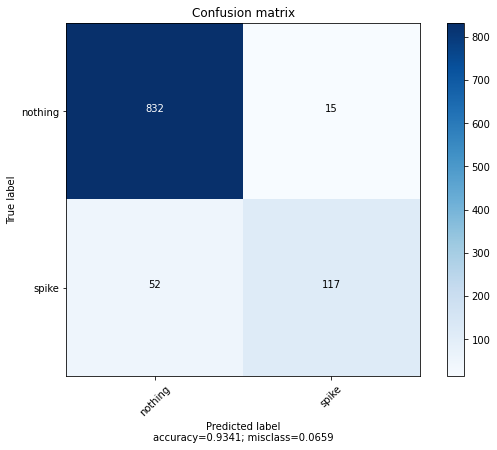


 0.7746031746031747 

  6%|▌         | 11/200 [01:22<21:09,  6.72s/it, best loss: -0.8172757475083057]

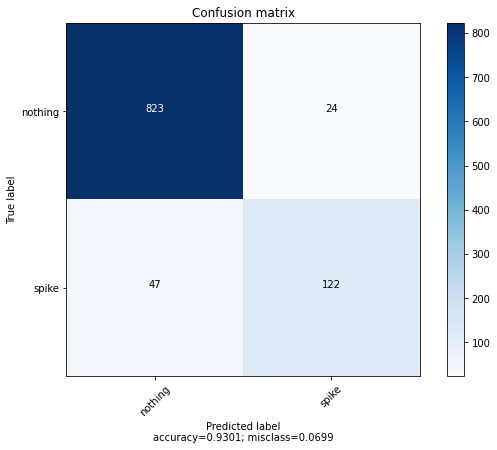


 0.7412140575079872 

  6%|▌         | 12/200 [01:25<18:48,  6.00s/it, best loss: -0.8172757475083057]

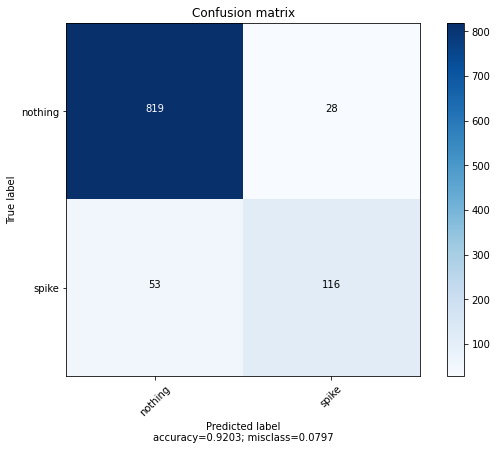


 0.7939393939393938 

  6%|▋         | 13/200 [01:28<15:30,  4.98s/it, best loss: -0.8172757475083057]

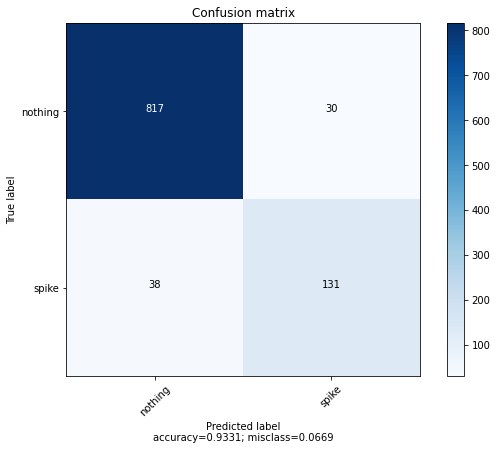


 0.8078175895765473 

  7%|▋         | 14/200 [01:38<13:58,  4.51s/it, best loss: -0.8172757475083057]

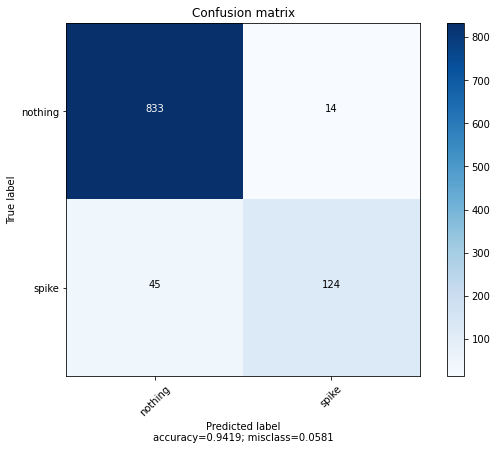


 0.8115015974440896 

  8%|▊         | 15/200 [01:48<18:55,  6.14s/it, best loss: -0.8172757475083057]

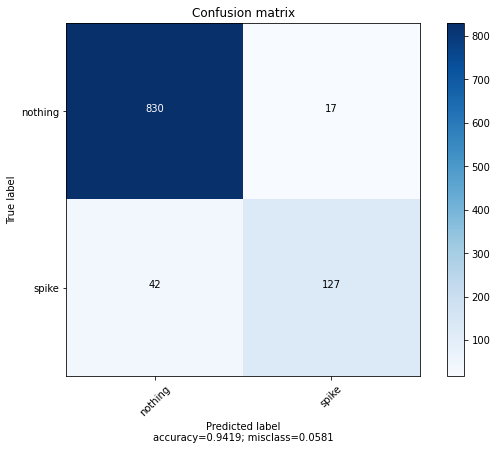


 0.7960526315789473 

  8%|▊         | 16/200 [01:57<22:34,  7.36s/it, best loss: -0.8172757475083057]

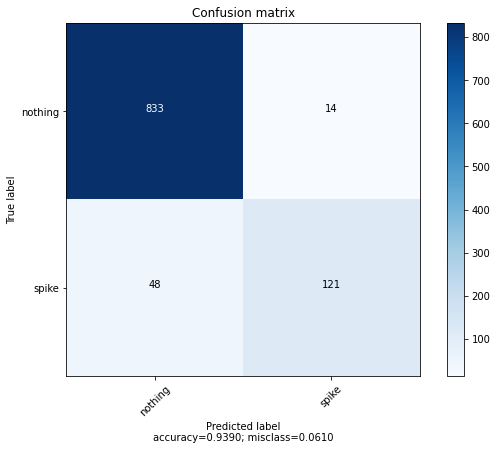


 0.8072289156626506 

  8%|▊         | 17/200 [02:04<23:51,  7.82s/it, best loss: -0.8172757475083057]

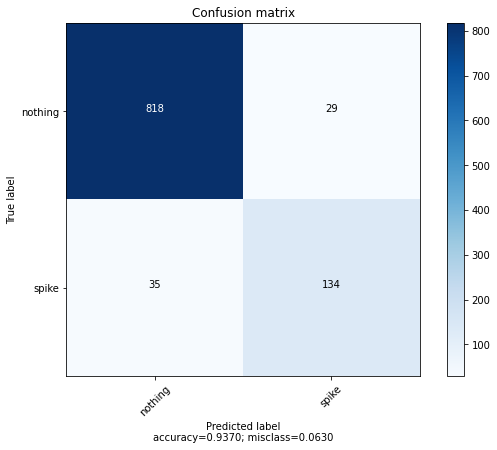


 0.8143322475570032 

  9%|▉         | 18/200 [02:23<22:44,  7.50s/it, best loss: -0.8172757475083057]

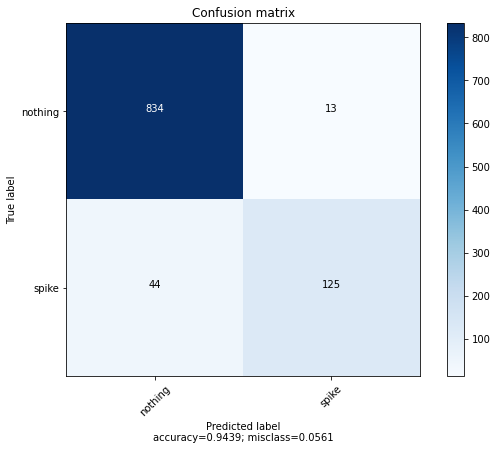


 0.7987421383647797 

 10%|▉         | 19/200 [02:27<33:06, 10.98s/it, best loss: -0.8172757475083057]

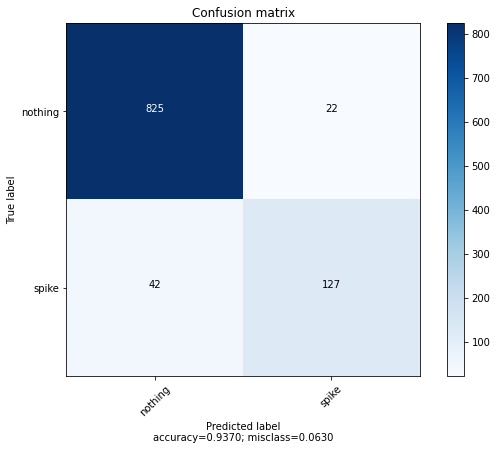


 0.8026315789473685 

 10%|█         | 20/200 [02:40<26:51,  8.95s/it, best loss: -0.8172757475083057]

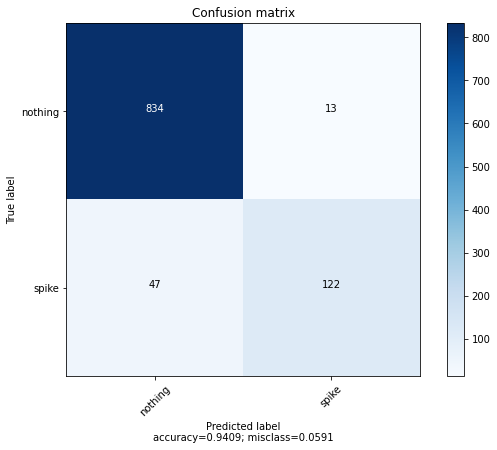


 0.7947019867549668 

 10%|█         | 21/200 [02:51<30:18, 10.16s/it, best loss: -0.8172757475083057]

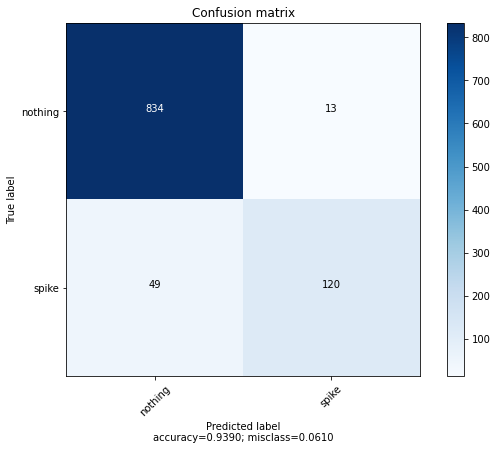


 0.8157894736842105 

 11%|█         | 22/200 [03:05<31:08, 10.50s/it, best loss: -0.8172757475083057]

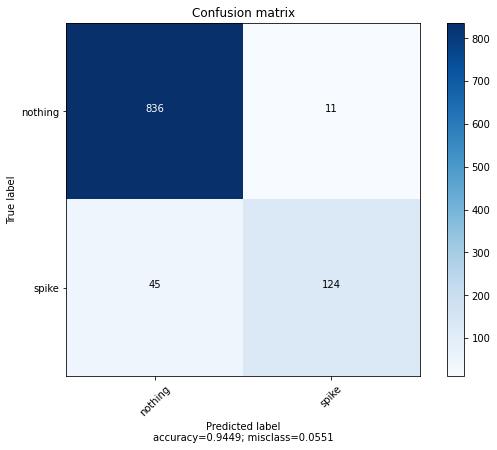


 0.8065573770491804 

 12%|█▏        | 23/200 [03:13<33:32, 11.37s/it, best loss: -0.8172757475083057]

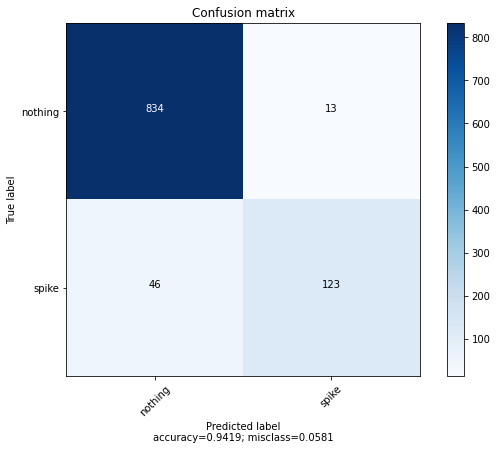


 0.7318435754189943 

 12%|█▏        | 24/200 [03:15<30:54, 10.54s/it, best loss: -0.8172757475083057]

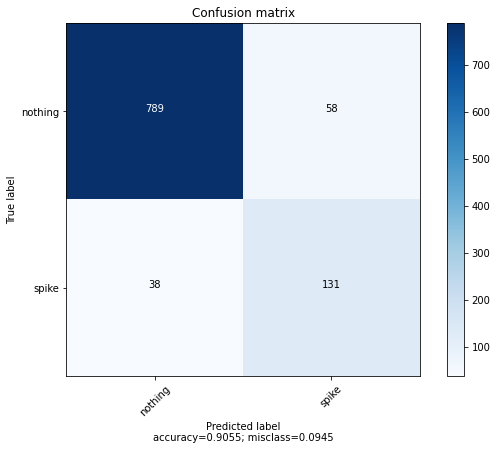


 0.8013029315960913 

 12%|█▎        | 25/200 [03:29<22:35,  7.74s/it, best loss: -0.8172757475083057]

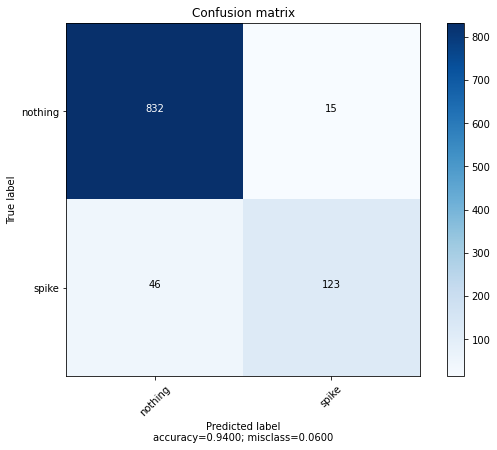


 0.810126582278481 

 13%|█▎        | 26/200 [03:44<28:10,  9.72s/it, best loss: -0.8172757475083057]

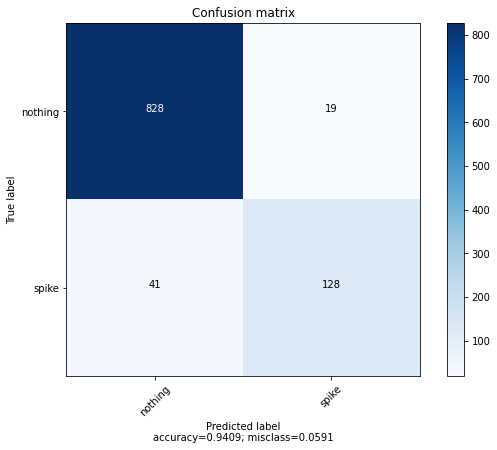


 0.8026315789473685 

 14%|█▎        | 27/200 [03:52<32:43, 11.35s/it, best loss: -0.8172757475083057]

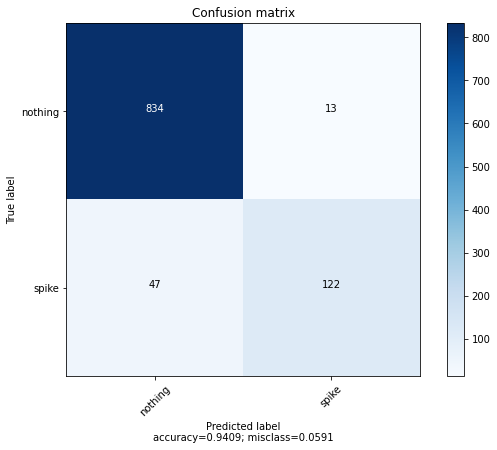


 0.8104575163398693 

 14%|█▍        | 28/200 [04:05<29:38, 10.34s/it, best loss: -0.8172757475083057]

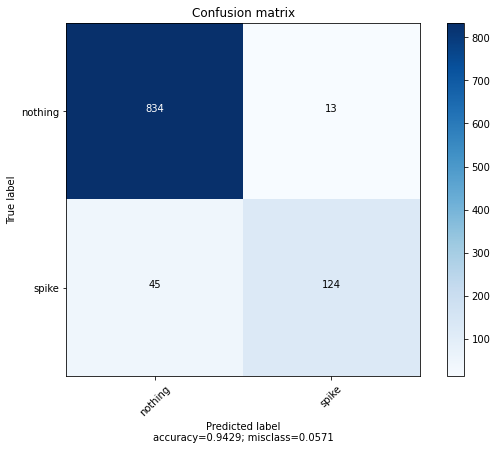


 0.8026315789473685 

 14%|█▍        | 29/200 [04:18<31:18, 10.98s/it, best loss: -0.8172757475083057]

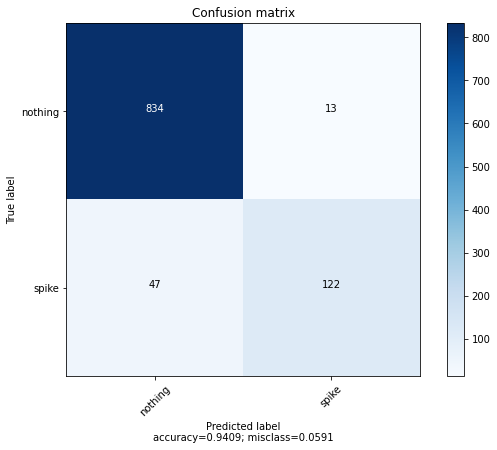


 0.781758957654723 

 15%|█▌        | 30/200 [04:25<33:28, 11.81s/it, best loss: -0.8172757475083057]

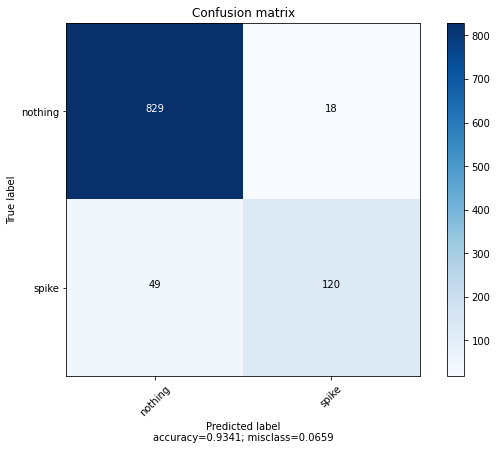


 0.7857142857142857 

 16%|█▌        | 31/200 [04:28<28:32, 10.13s/it, best loss: -0.8172757475083057]

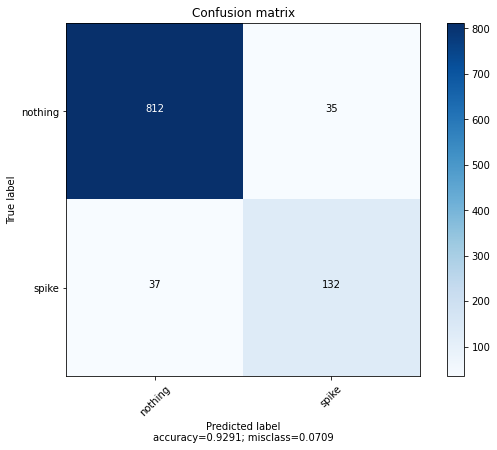


 0.8284789644012944 

 16%|█▌        | 32/200 [04:45<23:03,  8.24s/it, best loss: -0.8172757475083057]

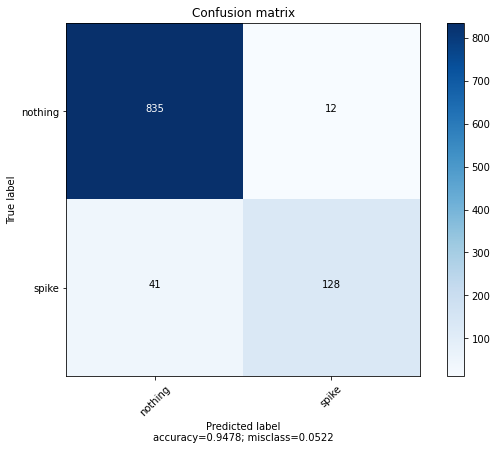


 0.8013245033112582 

 16%|█▋        | 33/200 [04:56<29:46, 10.70s/it, best loss: -0.8284789644012944]

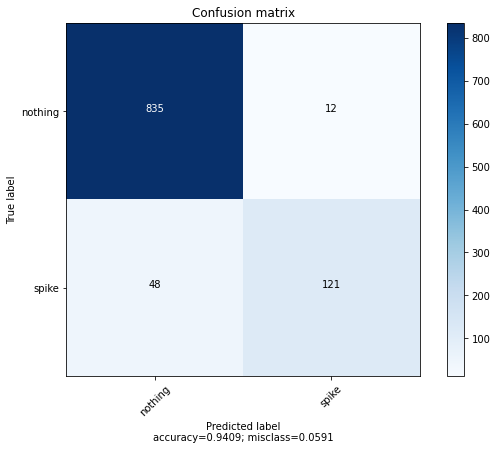


 0.7960526315789473 

 17%|█▋        | 34/200 [05:10<29:51, 10.79s/it, best loss: -0.8284789644012944]

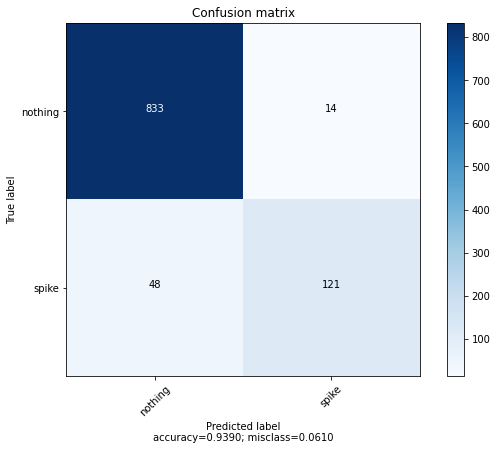


 0.7959866220735786 

 18%|█▊        | 35/200 [05:20<32:37, 11.86s/it, best loss: -0.8284789644012944]

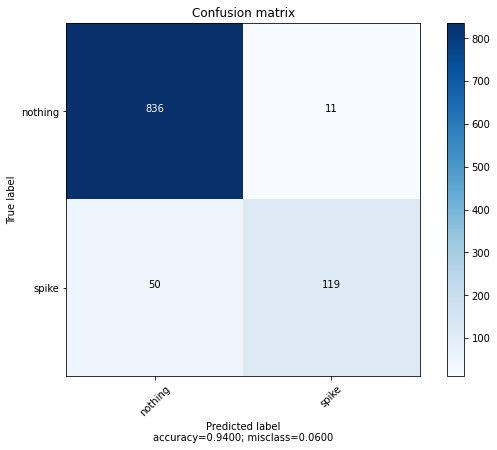


 0.8129032258064516 

 18%|█▊        | 36/200 [05:44<30:41, 11.23s/it, best loss: -0.8284789644012944]

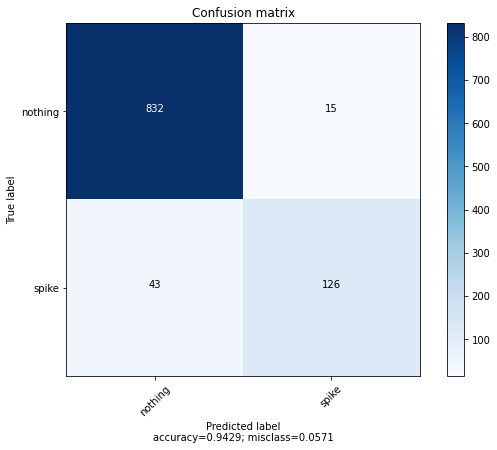


 0.7788778877887789 

 18%|█▊        | 37/200 [05:51<40:36, 14.95s/it, best loss: -0.8284789644012944]

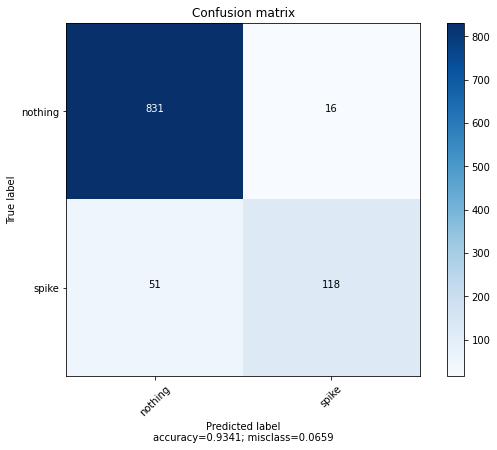


 0.8092105263157896 

 19%|█▉        | 38/200 [06:05<34:09, 12.65s/it, best loss: -0.8284789644012944]

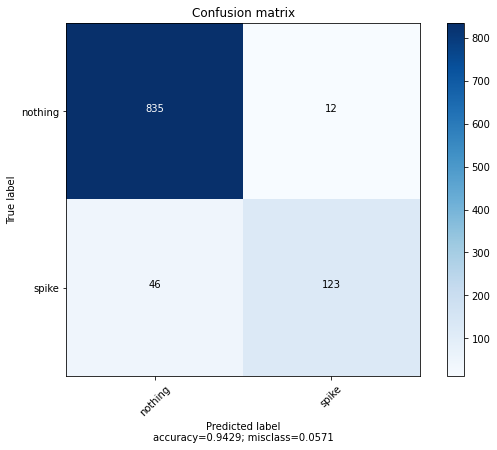


 0.7987220447284344 

 20%|█▉        | 39/200 [06:22<35:10, 13.11s/it, best loss: -0.8284789644012944]

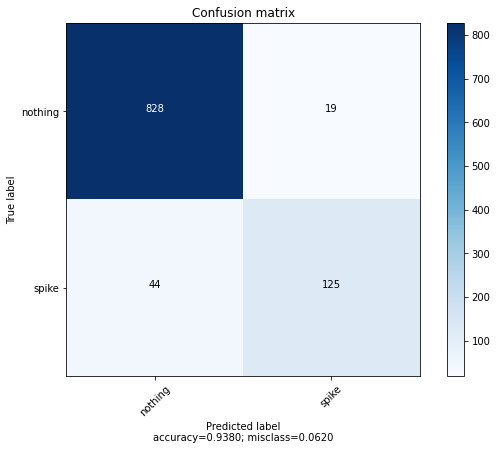


 0.8026315789473685 

 20%|██        | 40/200 [06:36<37:39, 14.12s/it, best loss: -0.8284789644012944]

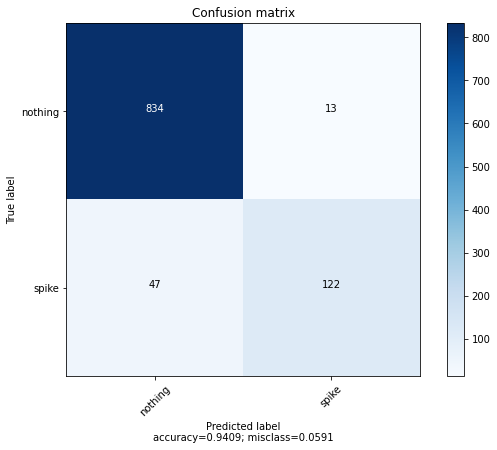


 0.7987012987012987 

 20%|██        | 41/200 [06:44<37:34, 14.18s/it, best loss: -0.8284789644012944]

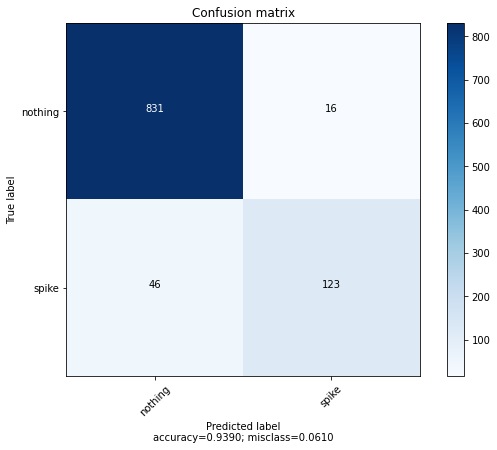


 0.8167202572347266 

 21%|██        | 42/200 [06:59<32:12, 12.23s/it, best loss: -0.8284789644012944]

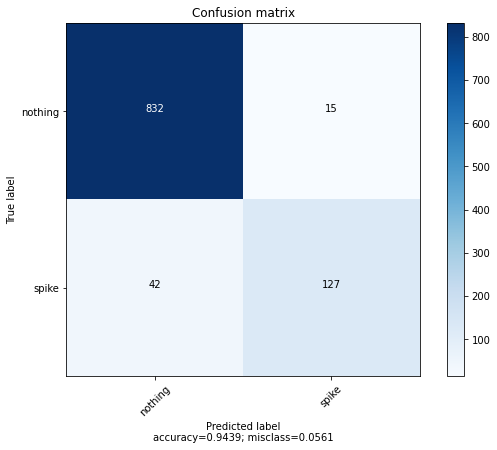


 0.8306709265175719 

 22%|██▏       | 43/200 [07:18<34:43, 13.27s/it, best loss: -0.8284789644012944]

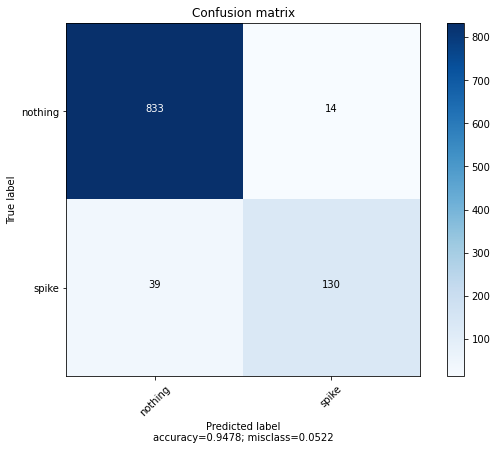


 0.8201892744479496 

 22%|██▏       | 44/200 [07:31<38:57, 14.98s/it, best loss: -0.8306709265175719]

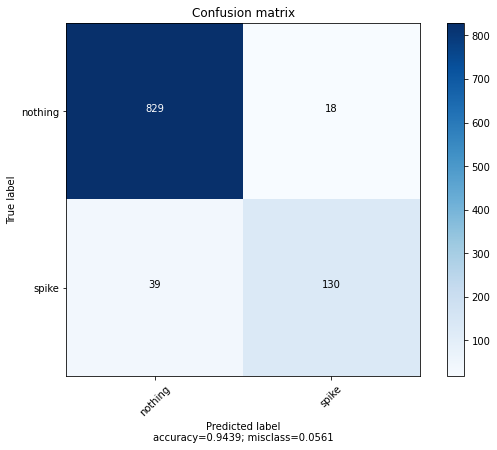


 0.8073394495412844 

 22%|██▎       | 45/200 [07:36<36:51, 14.27s/it, best loss: -0.8306709265175719]

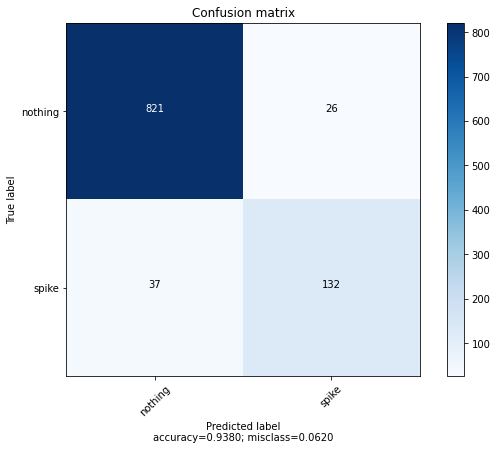


 0.7999999999999999 

 23%|██▎       | 46/200 [07:53<29:45, 11.59s/it, best loss: -0.8306709265175719]

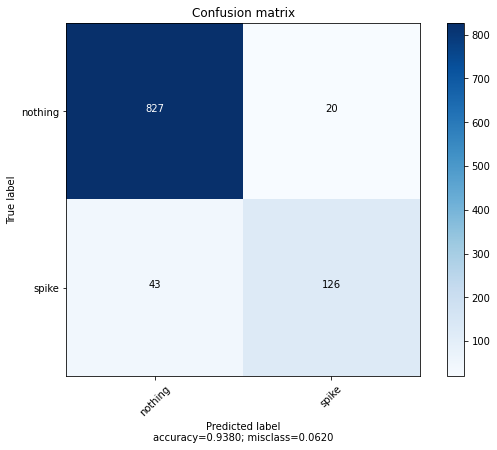


 0.8173374613003095 

 24%|██▎       | 47/200 [07:59<33:41, 13.21s/it, best loss: -0.8306709265175719]

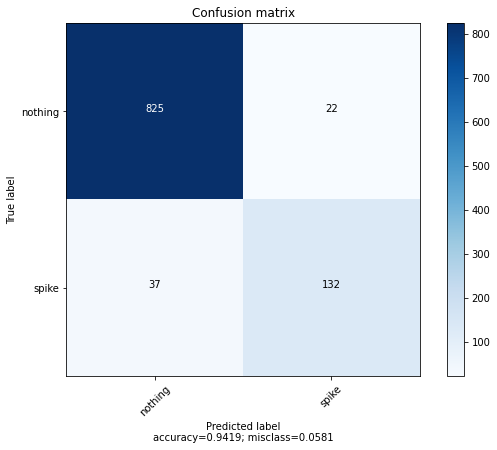


 0.8284789644012944 

 24%|██▍       | 48/200 [08:17<27:36, 10.90s/it, best loss: -0.8306709265175719]

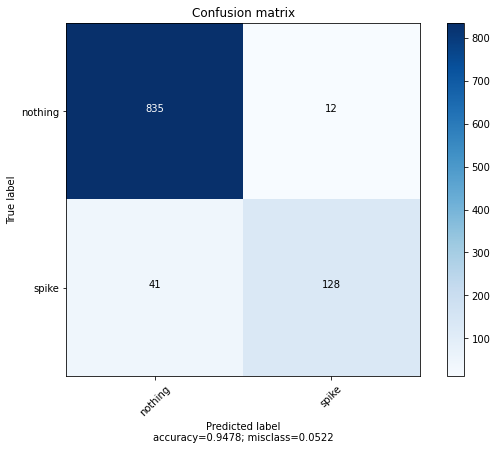


 0.7736389684813755 

 24%|██▍       | 49/200 [08:21<33:03, 13.13s/it, best loss: -0.8306709265175719]

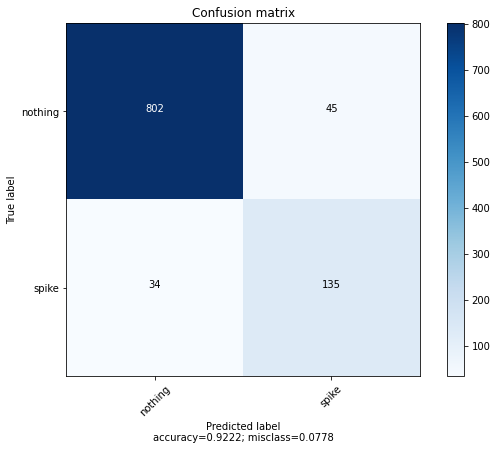


 0.7923322683706071 

 25%|██▌       | 50/200 [08:31<26:11, 10.48s/it, best loss: -0.8306709265175719]

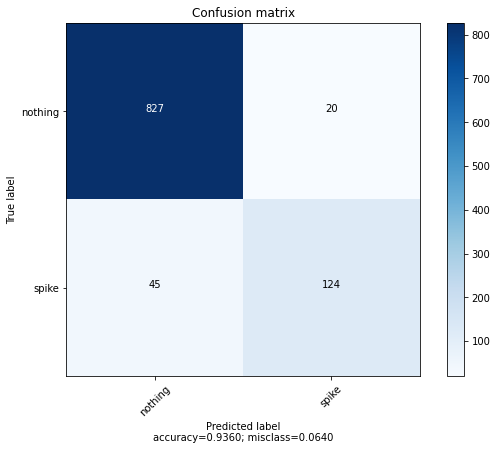


 0.7752442996742672 

 26%|██▌       | 51/200 [08:41<25:38, 10.33s/it, best loss: -0.8306709265175719]

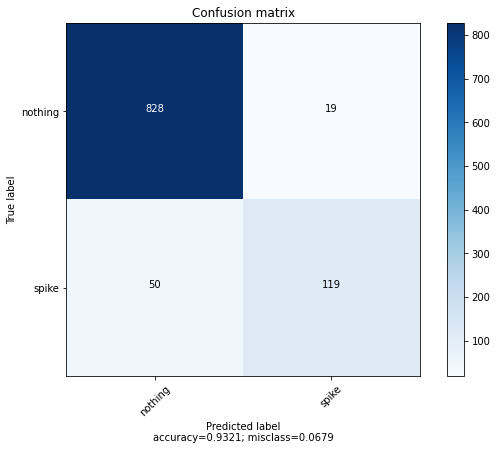


 0.7898089171974522 

 26%|██▌       | 52/200 [08:54<25:07, 10.19s/it, best loss: -0.8306709265175719]

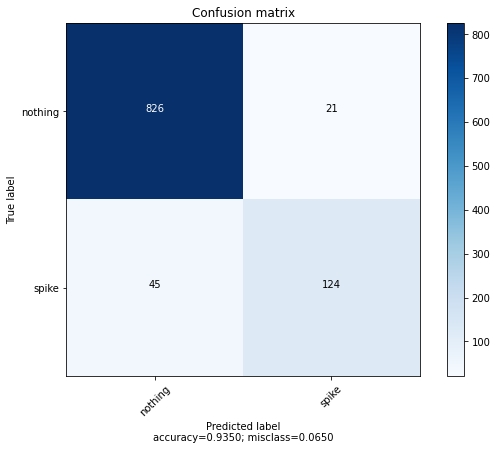


 0.8181818181818182 

 26%|██▋       | 53/200 [09:05<27:00, 11.03s/it, best loss: -0.8306709265175719]

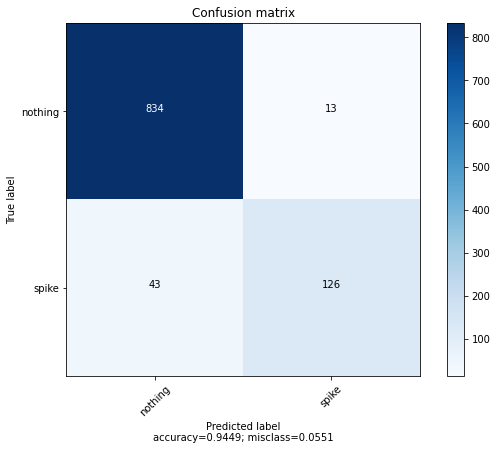


 0.8258064516129032 

 27%|██▋       | 54/200 [09:23<26:29, 10.89s/it, best loss: -0.8306709265175719]

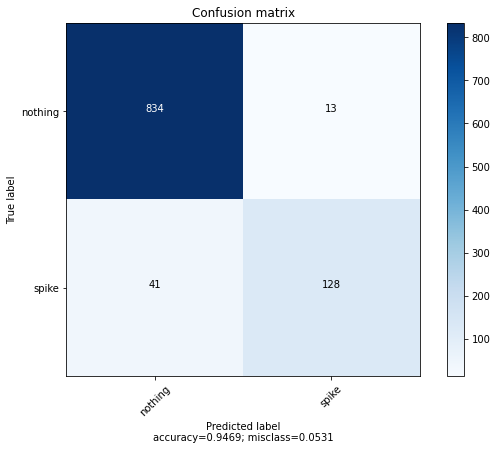


 0.8348909657320872 

 28%|██▊       | 55/200 [09:36<31:52, 13.19s/it, best loss: -0.8306709265175719]

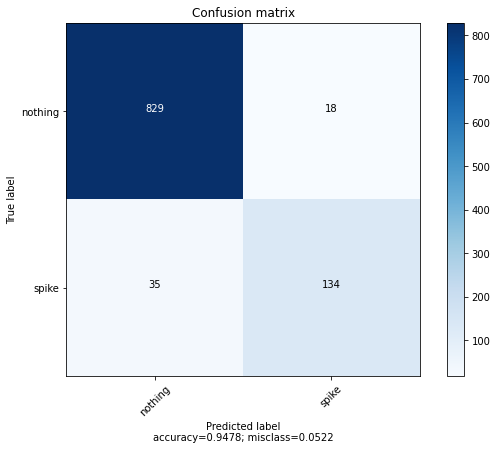


 0.7633136094674556 

 28%|██▊       | 56/200 [09:39<31:14, 13.02s/it, best loss: -0.8348909657320872]

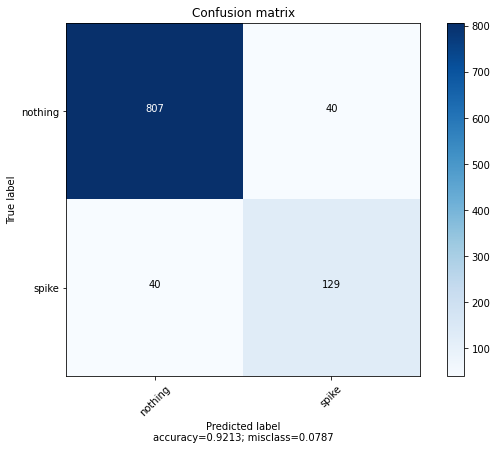


 0.7852760736196318 

 28%|██▊       | 57/200 [09:44<23:44,  9.96s/it, best loss: -0.8348909657320872]

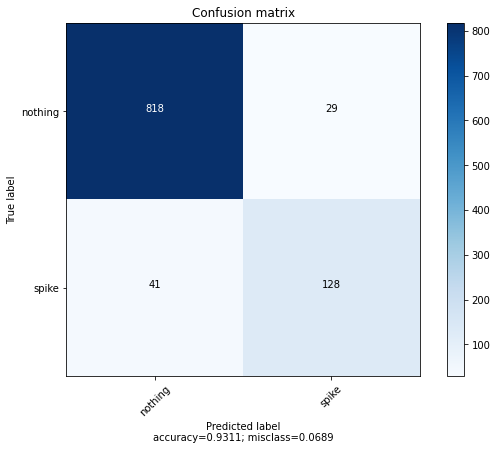


 0.8074534161490683 

 29%|██▉       | 58/200 [09:53<20:19,  8.59s/it, best loss: -0.8348909657320872]

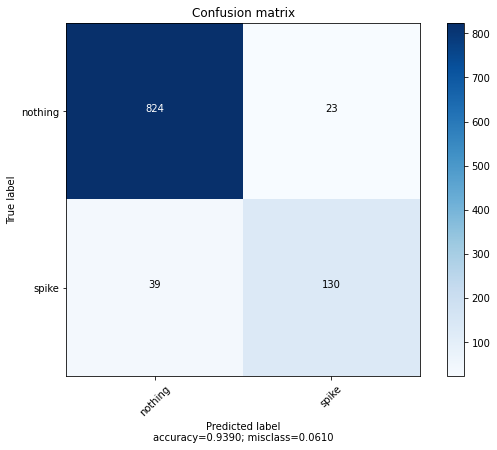


 0.8148148148148149 

 30%|██▉       | 59/200 [10:13<20:34,  8.76s/it, best loss: -0.8348909657320872]

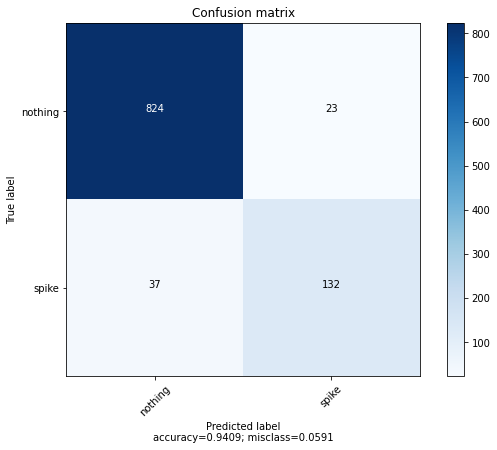


 0.8048780487804879 

 30%|███       | 60/200 [10:20<28:20, 12.14s/it, best loss: -0.8348909657320872]

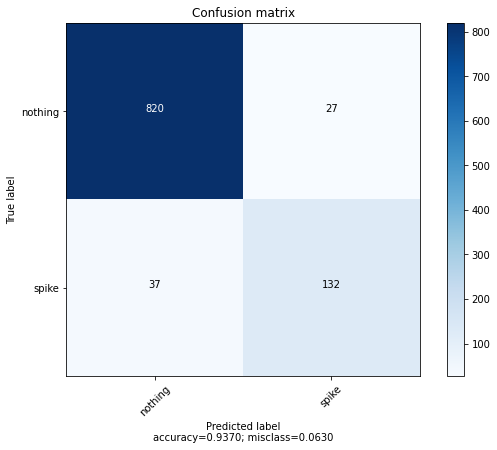


 0.7391304347826088 

 30%|███       | 61/200 [10:21<24:21, 10.52s/it, best loss: -0.8348909657320872]

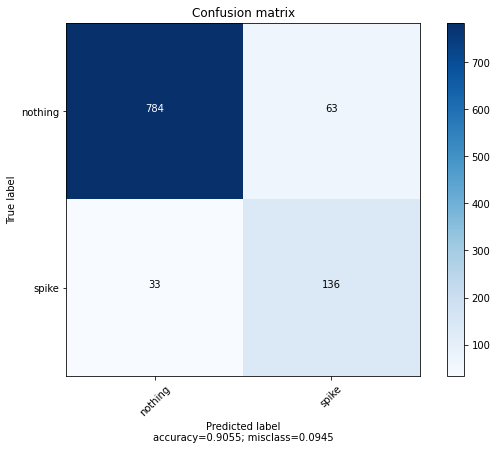


 0.8048048048048049 

 31%|███       | 62/200 [10:29<17:53,  7.78s/it, best loss: -0.8348909657320872]

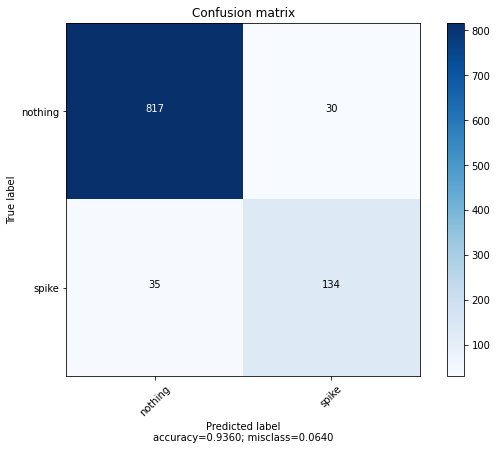


 0.7318435754189943 

 32%|███▏      | 63/200 [10:32<17:53,  7.83s/it, best loss: -0.8348909657320872]

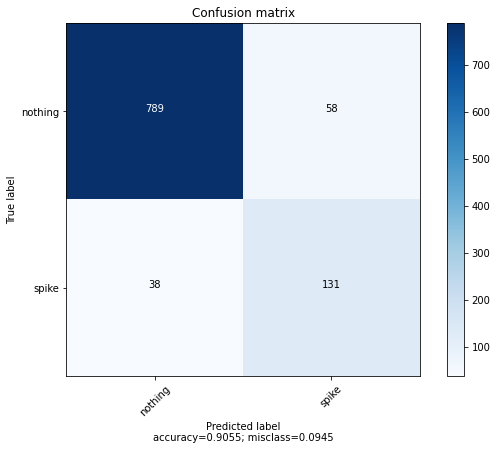


 0.8213166144200627 

 32%|███▏      | 64/200 [10:43<13:56,  6.15s/it, best loss: -0.8348909657320872]

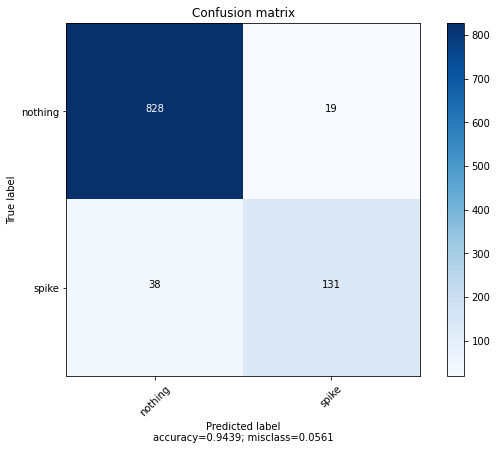


 0.8157894736842105 

 32%|███▎      | 65/200 [11:00<17:26,  7.75s/it, best loss: -0.8348909657320872]

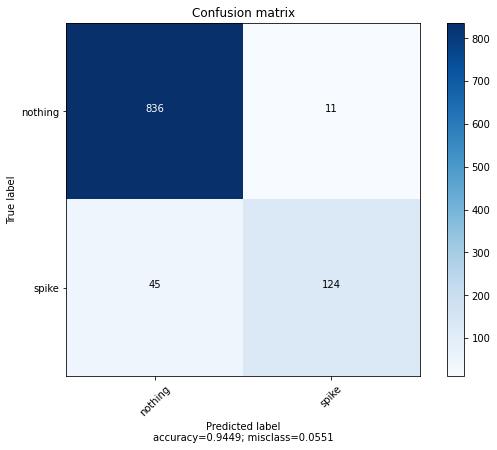


 0.8246753246753247 

 33%|███▎      | 66/200 [11:18<23:47, 10.65s/it, best loss: -0.8348909657320872]

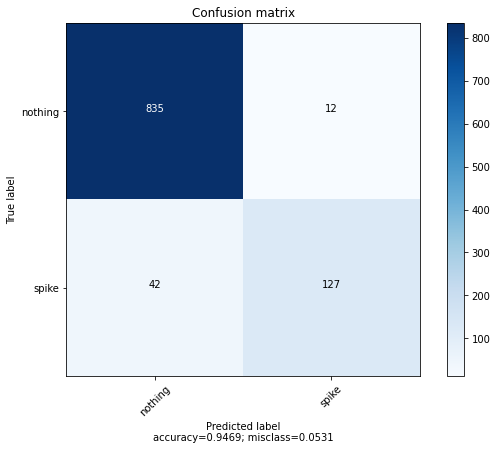


 0.7973856209150326 

 34%|███▎      | 67/200 [11:29<28:10, 12.71s/it, best loss: -0.8348909657320872]

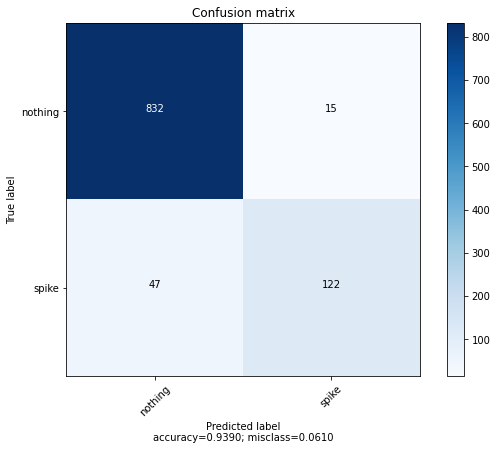


 0.8178913738019169 

 34%|███▍      | 68/200 [11:44<26:52, 12.22s/it, best loss: -0.8348909657320872]

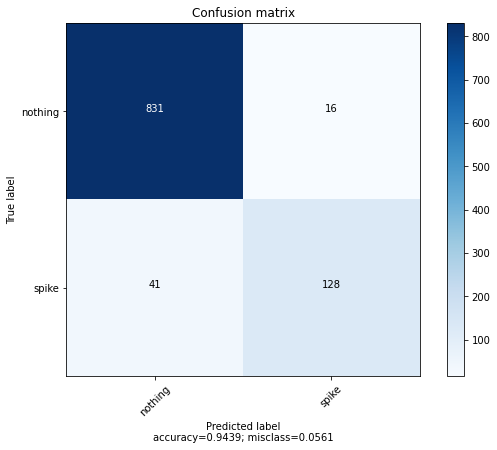


 0.8178913738019169 

 34%|███▍      | 69/200 [12:00<28:18, 12.96s/it, best loss: -0.8348909657320872]

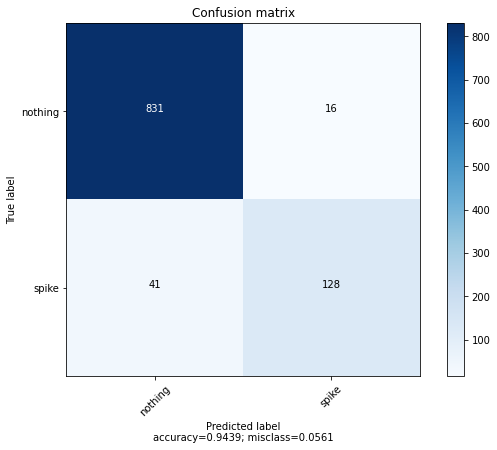


 0.8051948051948051 

 35%|███▌      | 70/200 [12:14<30:19, 13.99s/it, best loss: -0.8348909657320872]

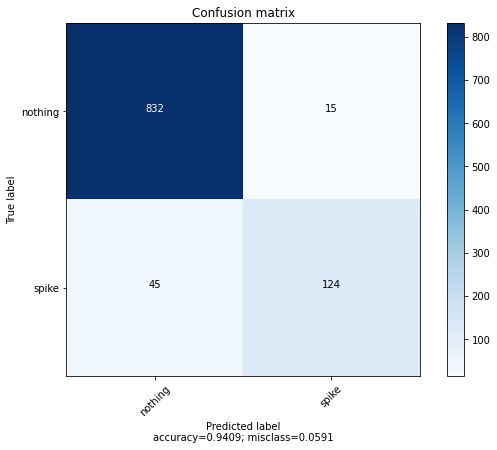


 0.8284789644012944 

 36%|███▌      | 71/200 [12:33<29:59, 13.95s/it, best loss: -0.8348909657320872]

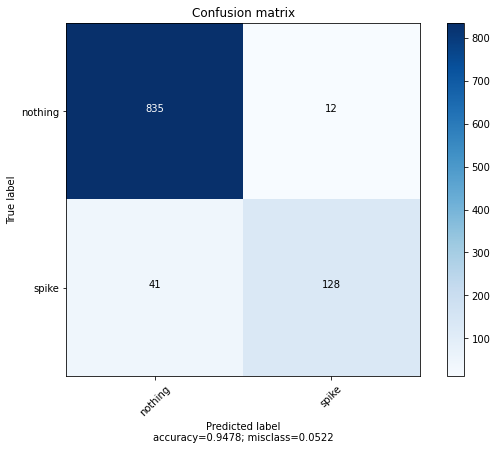


 0.8074534161490683 

 36%|███▌      | 72/200 [12:44<32:45, 15.36s/it, best loss: -0.8348909657320872]

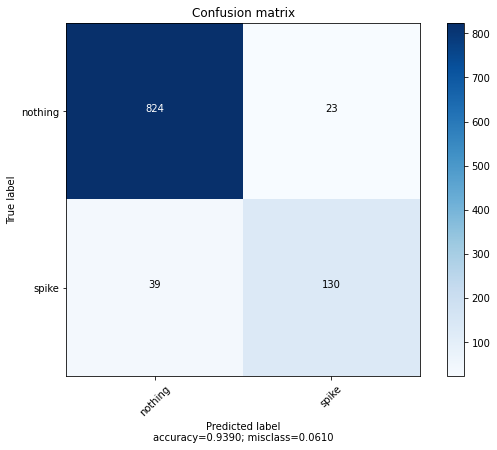


 0.8078175895765473 

 36%|███▋      | 73/200 [13:01<29:45, 14.06s/it, best loss: -0.8348909657320872]

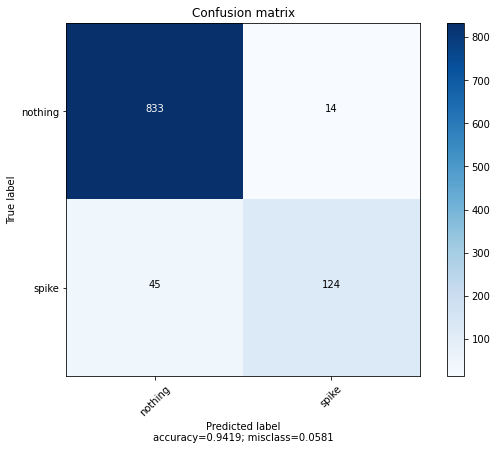


 0.8201892744479496 

 37%|███▋      | 74/200 [13:13<31:23, 14.95s/it, best loss: -0.8348909657320872]

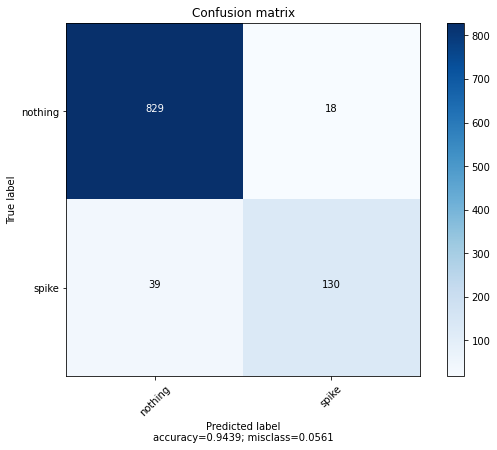


 0.8115015974440896 

 38%|███▊      | 75/200 [13:30<29:41, 14.25s/it, best loss: -0.8348909657320872]

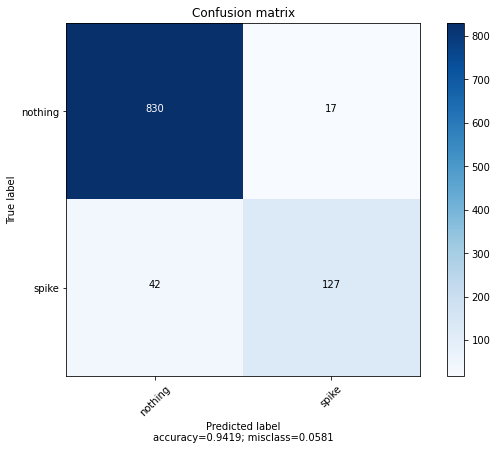


 0.8131147540983605 

 38%|███▊      | 76/200 [13:50<31:00, 15.01s/it, best loss: -0.8348909657320872]

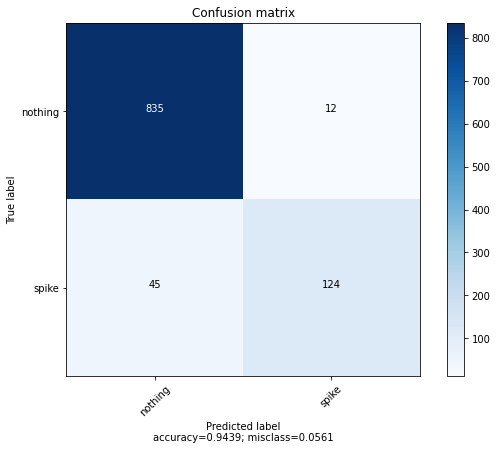


 0.8126984126984127 

 38%|███▊      | 77/200 [14:03<33:35, 16.39s/it, best loss: -0.8348909657320872]

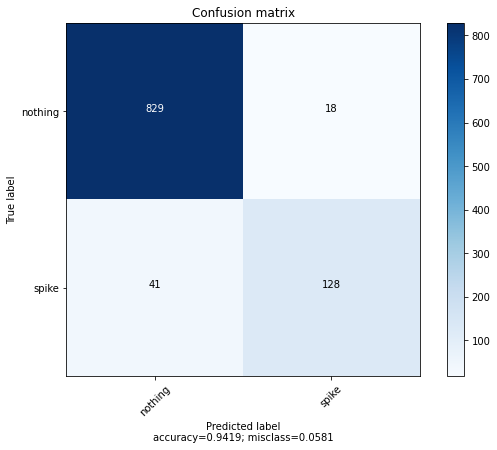


 0.8076923076923078 

 39%|███▉      | 78/200 [14:19<31:40, 15.57s/it, best loss: -0.8348909657320872]

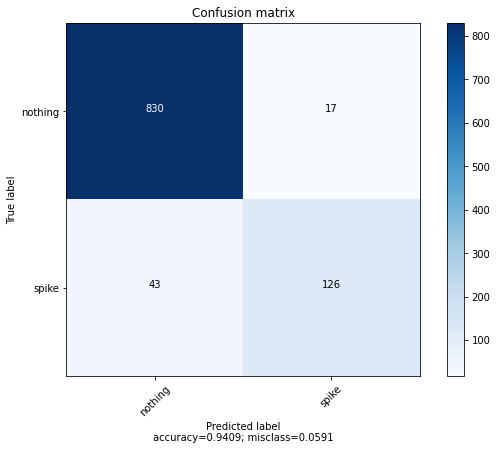


 0.8013245033112582 

 40%|███▉      | 79/200 [14:37<31:11, 15.47s/it, best loss: -0.8348909657320872]

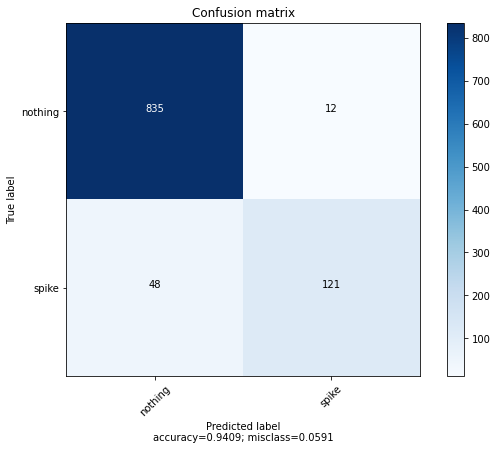


 0.7908496732026143 

 40%|████      | 80/200 [14:54<32:49, 16.42s/it, best loss: -0.8348909657320872]

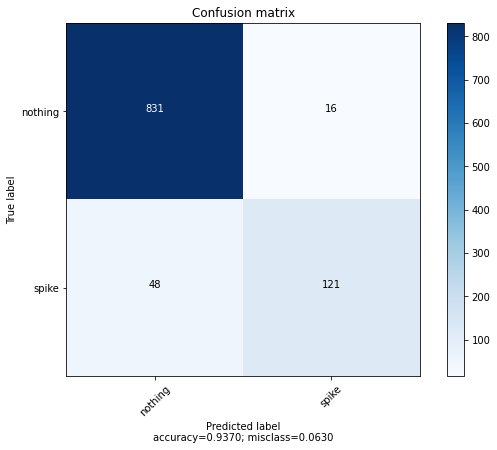


 0.8201892744479496 

 40%|████      | 81/200 [15:10<32:44, 16.51s/it, best loss: -0.8348909657320872]

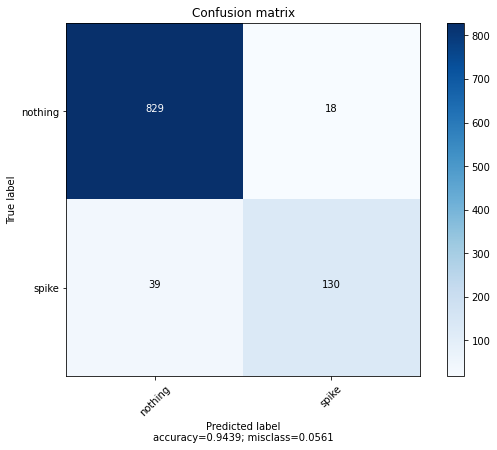


 0.8150470219435738 

 41%|████      | 82/200 [15:27<32:19, 16.44s/it, best loss: -0.8348909657320872]

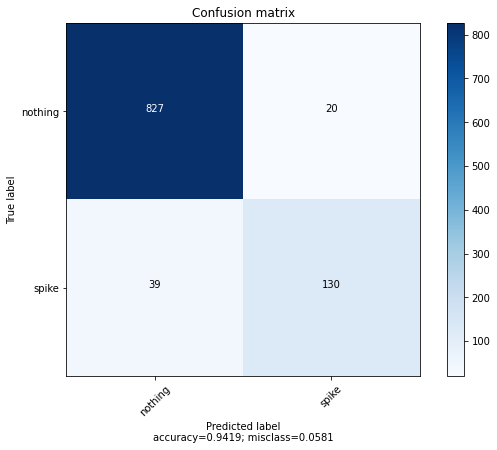


 0.7774086378737541 

 42%|████▏     | 83/200 [15:34<32:16, 16.55s/it, best loss: -0.8348909657320872]

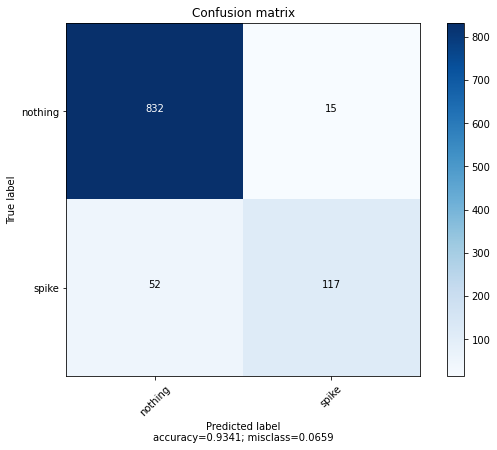


 0.81875 

 42%|████▏     | 84/200 [15:46<26:37, 13.77s/it, best loss: -0.8348909657320872]

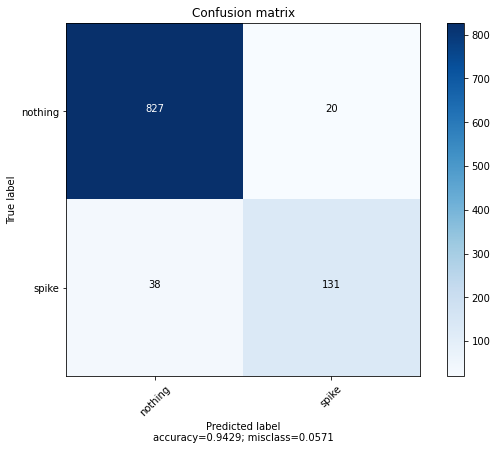


 0.7541899441340781 

 42%|████▎     | 85/200 [15:47<24:57, 13.02s/it, best loss: -0.8348909657320872]

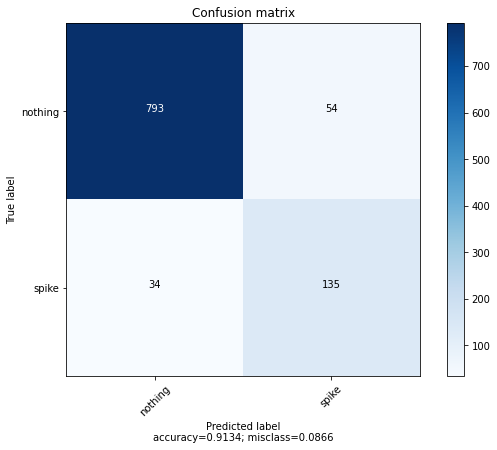


 0.8126984126984127 

 43%|████▎     | 86/200 [16:03<18:20,  9.65s/it, best loss: -0.8348909657320872]

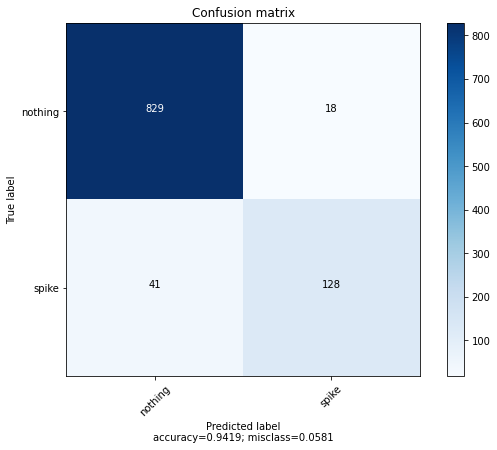


 0.8123076923076922 

 44%|████▎     | 87/200 [16:12<21:47, 11.57s/it, best loss: -0.8348909657320872]

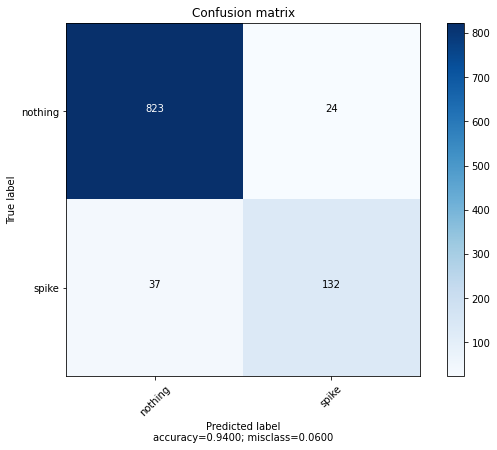


 0.7974683544303799 

 44%|████▍     | 88/200 [16:15<19:56, 10.68s/it, best loss: -0.8348909657320872]

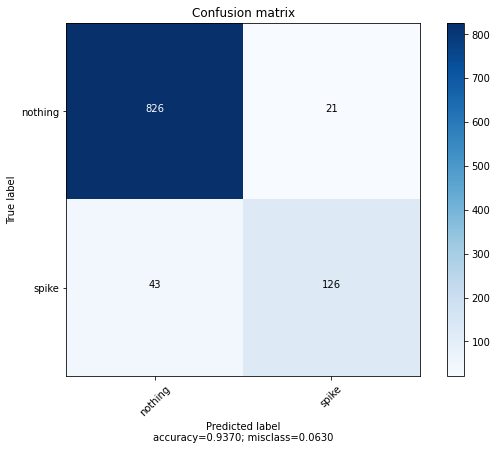


 0.8060606060606061 

 44%|████▍     | 89/200 [16:22<15:40,  8.47s/it, best loss: -0.8348909657320872]

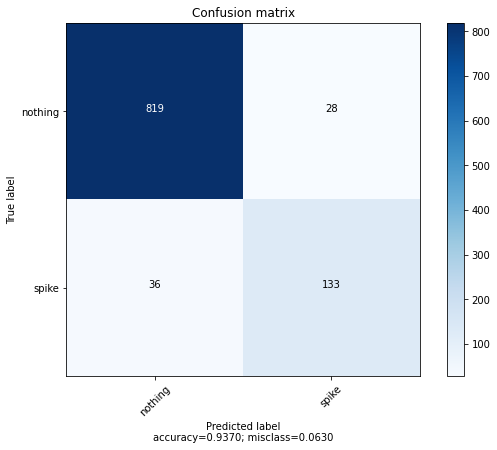


 0.7987220447284344 

 45%|████▌     | 90/200 [16:41<14:24,  7.86s/it, best loss: -0.8348909657320872]

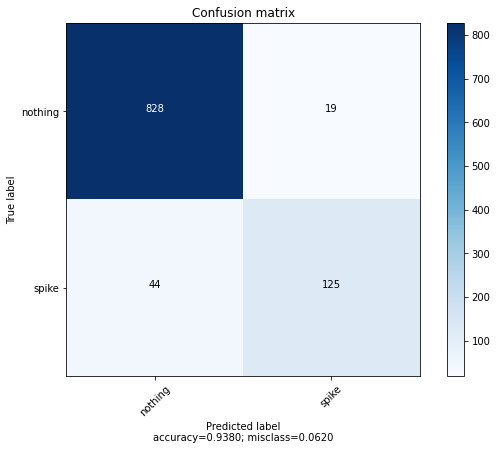


 0.8193548387096774 

 46%|████▌     | 91/200 [16:58<20:40, 11.38s/it, best loss: -0.8348909657320872]

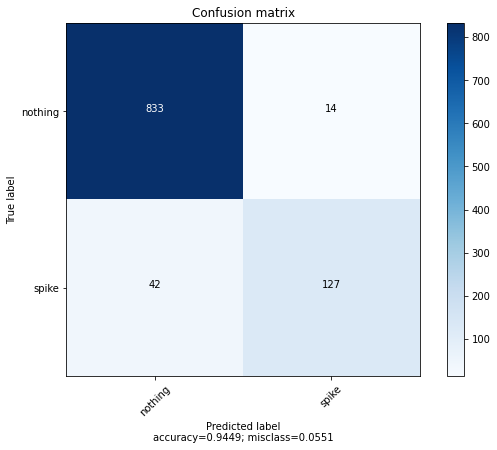


 0.77602523659306 

 46%|████▌     | 92/200 [17:10<23:22, 12.99s/it, best loss: -0.8348909657320872]

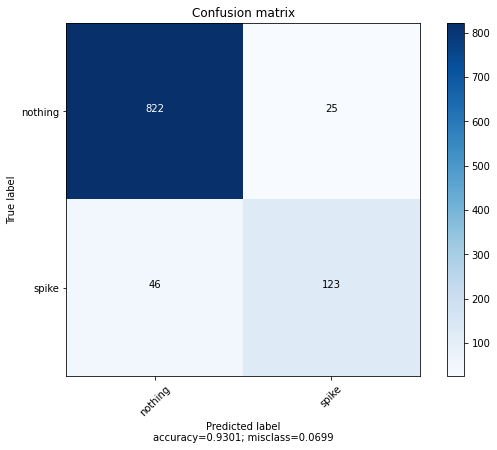


 0.8280254777070064 

 46%|████▋     | 93/200 [17:23<22:39, 12.70s/it, best loss: -0.8348909657320872]

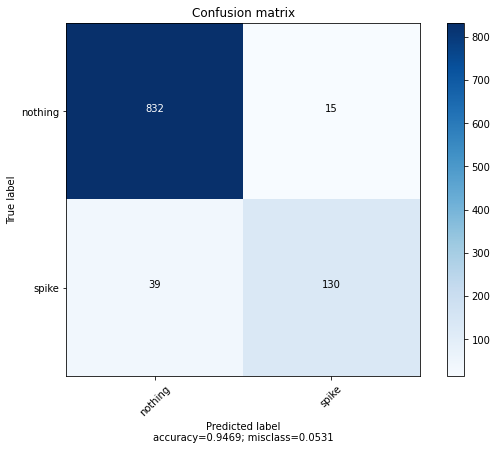


 0.7894736842105262 

 47%|████▋     | 94/200 [17:28<22:44, 12.88s/it, best loss: -0.8348909657320872]

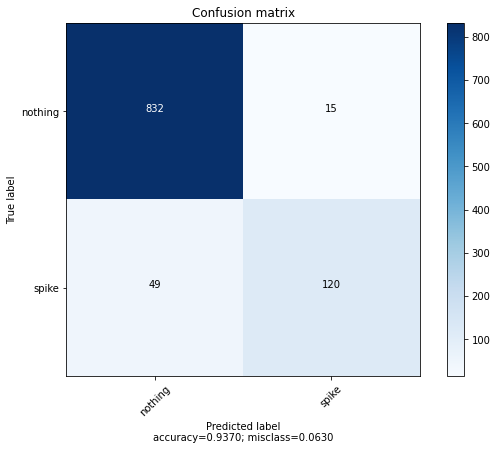


 0.8026315789473685 

 48%|████▊     | 95/200 [17:45<18:25, 10.53s/it, best loss: -0.8348909657320872]

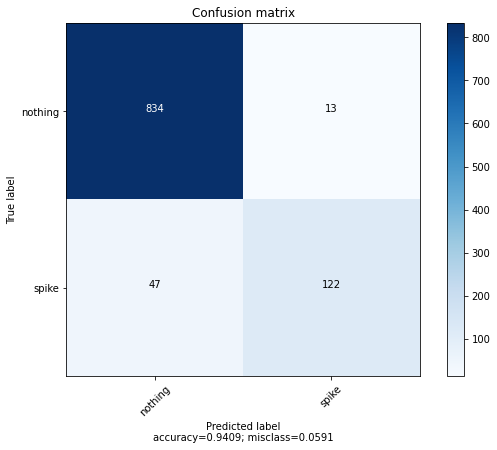


 0.7868852459016392 

 48%|████▊     | 96/200 [18:04<21:23, 12.34s/it, best loss: -0.8348909657320872]

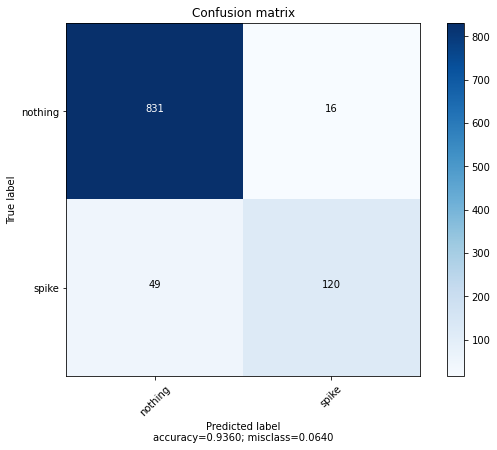


 0.8076923076923078 

 48%|████▊     | 97/200 [18:20<24:37, 14.35s/it, best loss: -0.8348909657320872]

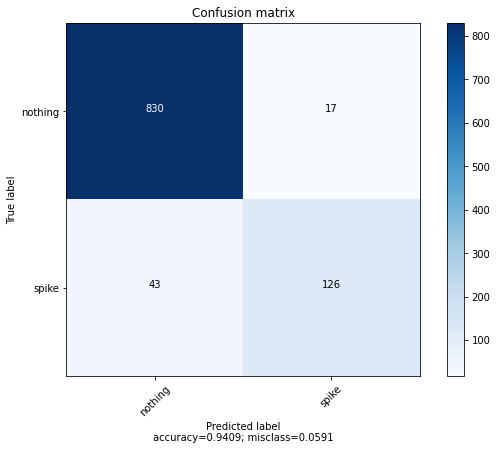


 0.8113207547169812 

 49%|████▉     | 98/200 [18:32<25:17, 14.88s/it, best loss: -0.8348909657320872]

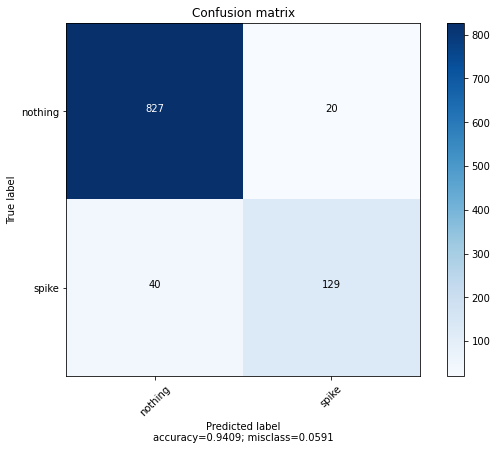


 0.8013245033112582 

 50%|████▉     | 99/200 [18:48<23:38, 14.04s/it, best loss: -0.8348909657320872]

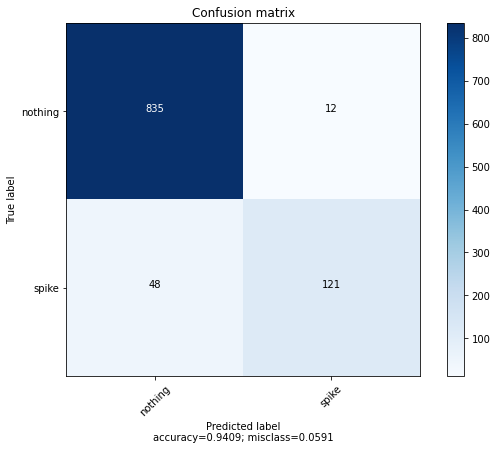


 0.779220779220779 

 50%|█████     | 100/200 [18:55<24:13, 14.54s/it, best loss: -0.8348909657320872]

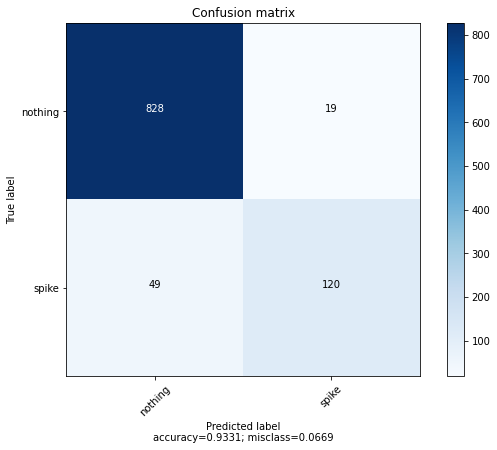


 0.8152866242038217 

 50%|█████     | 101/200 [19:06<20:25, 12.38s/it, best loss: -0.8348909657320872]

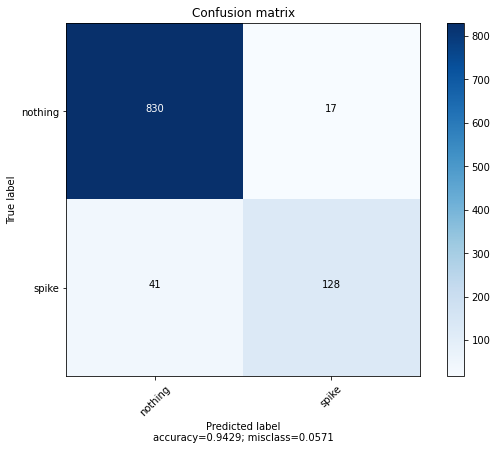


 0.7863777089783281 

 51%|█████     | 102/200 [19:10<19:31, 11.96s/it, best loss: -0.8348909657320872]

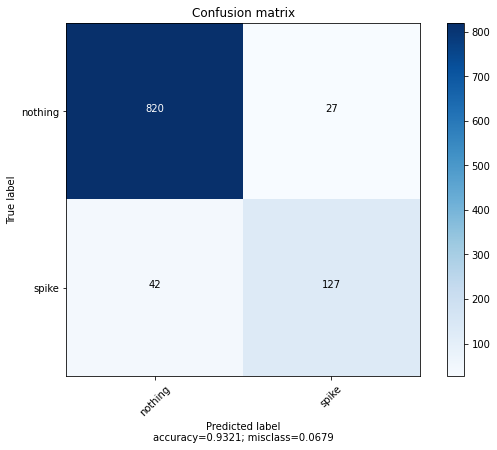


 0.8269230769230769 

 52%|█████▏    | 103/200 [19:32<15:11,  9.40s/it, best loss: -0.8348909657320872]

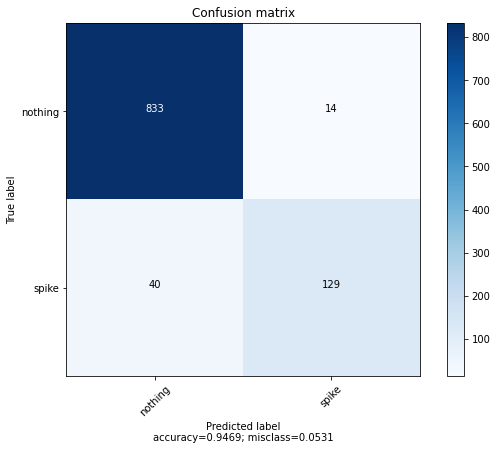


 0.809968847352025 

 52%|█████▏    | 104/200 [19:43<21:19, 13.33s/it, best loss: -0.8348909657320872]

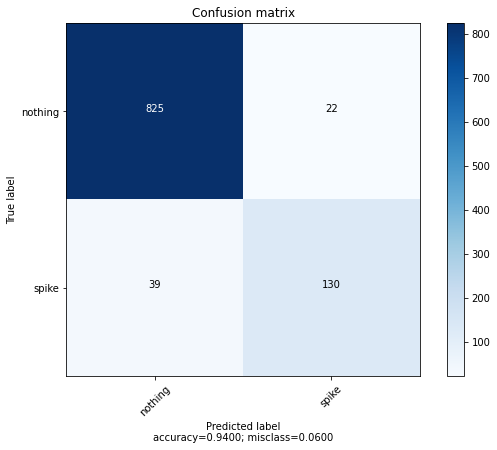


 0.7619047619047619 

 52%|█████▎    | 105/200 [19:50<20:02, 12.65s/it, best loss: -0.8348909657320872]

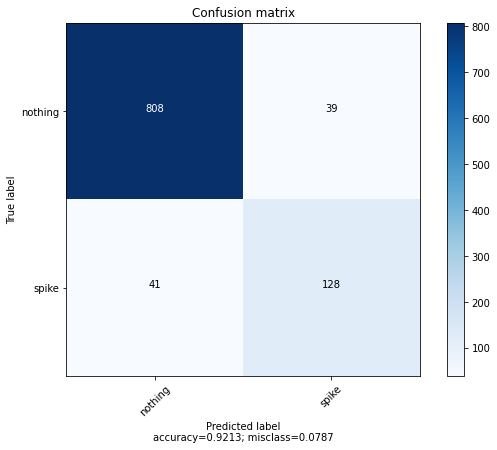


 0.8065573770491804 

 53%|█████▎    | 106/200 [20:00<16:54, 10.80s/it, best loss: -0.8348909657320872]

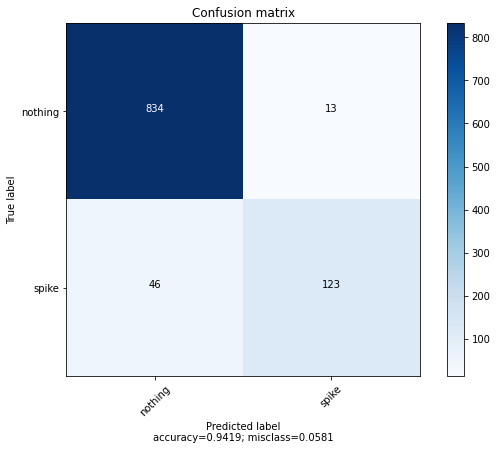


 0.7922077922077922 

 54%|█████▎    | 107/200 [20:13<16:37, 10.72s/it, best loss: -0.8348909657320872]

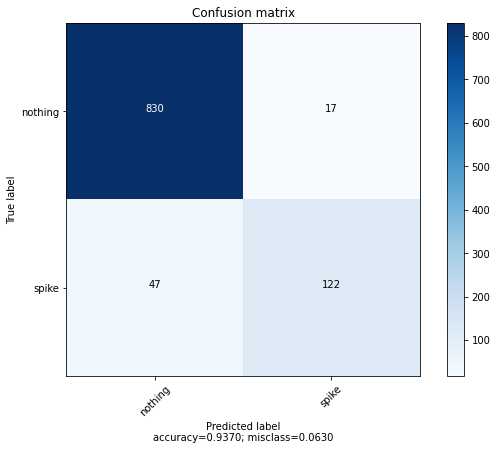


 0.8 

 54%|█████▍    | 108/200 [20:21<17:28, 11.40s/it, best loss: -0.8348909657320872]

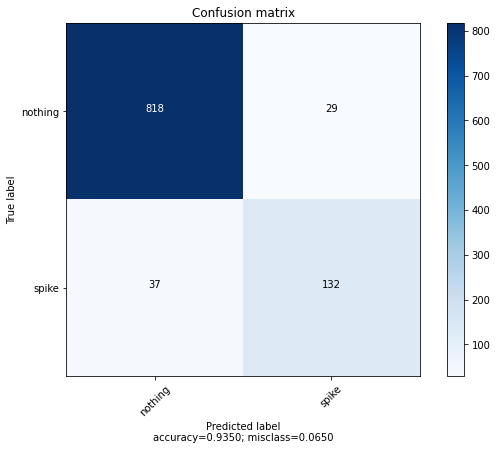


 0.8148148148148149 

 55%|█████▍    | 109/200 [20:27<15:39, 10.33s/it, best loss: -0.8348909657320872]

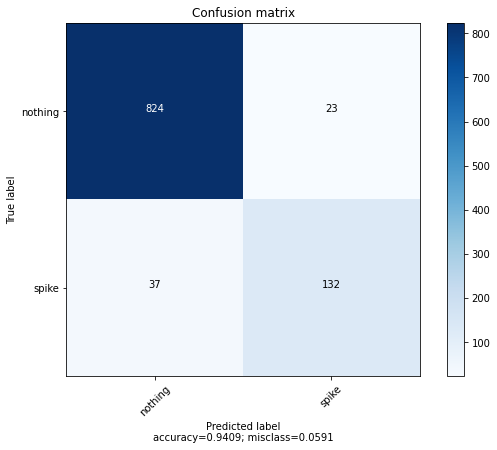


 0.8220064724919094 

 55%|█████▌    | 110/200 [20:45<13:33,  9.03s/it, best loss: -0.8348909657320872]

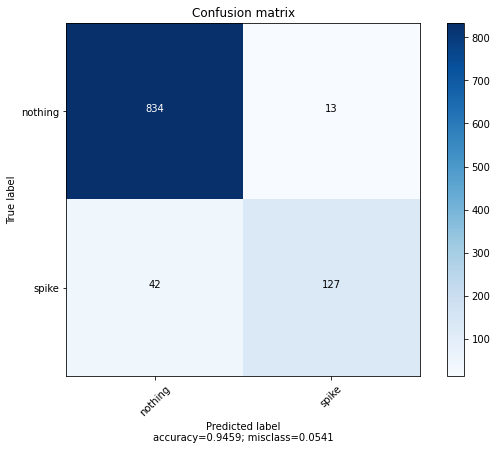


 0.8025078369905957 

 56%|█████▌    | 111/200 [20:57<17:11, 11.59s/it, best loss: -0.8348909657320872]

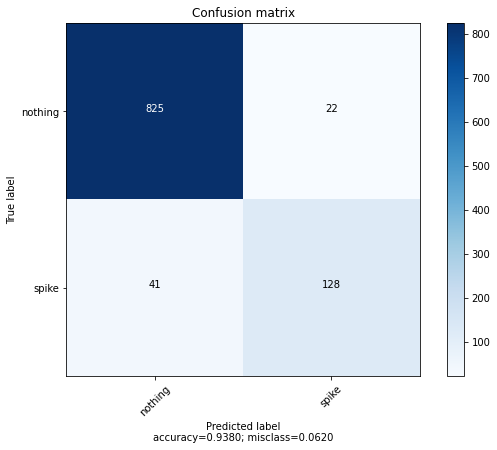


 0.7804878048780487 

 56%|█████▌    | 112/200 [21:03<17:30, 11.94s/it, best loss: -0.8348909657320872]

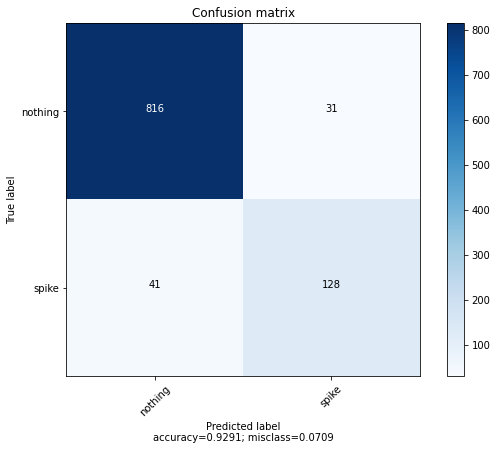


 0.7975460122699387 

 56%|█████▋    | 113/200 [21:12<14:38, 10.10s/it, best loss: -0.8348909657320872]

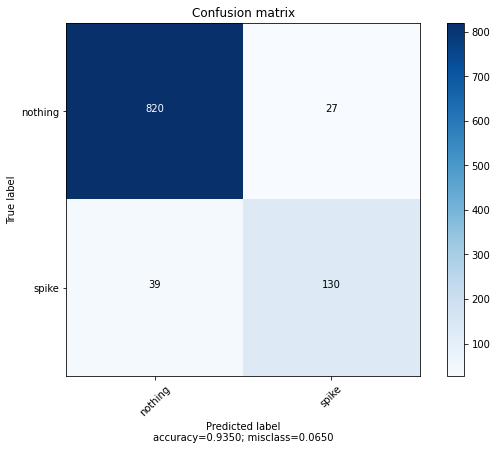


 0.8104575163398693 

 57%|█████▋    | 114/200 [21:22<14:00,  9.78s/it, best loss: -0.8348909657320872]

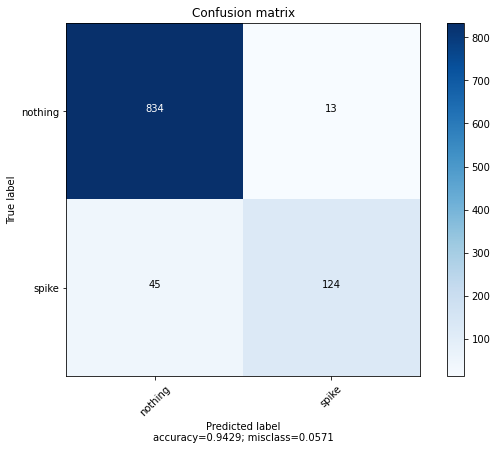


 0.8064516129032259 

 57%|█████▊    | 115/200 [21:41<13:42,  9.68s/it, best loss: -0.8348909657320872]

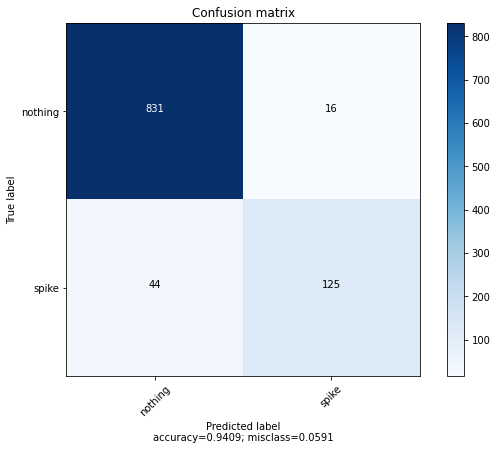


 0.8075709779179812 

 58%|█████▊    | 116/200 [21:58<17:38, 12.60s/it, best loss: -0.8348909657320872]

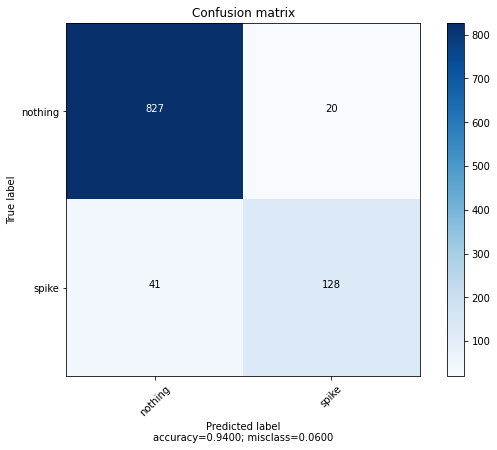


 0.8 

 58%|█████▊    | 117/200 [22:15<19:22, 14.01s/it, best loss: -0.8348909657320872]

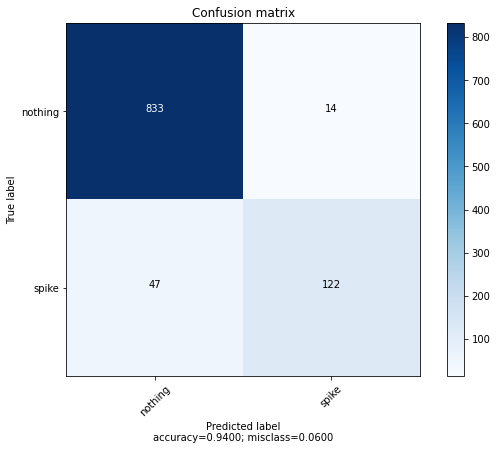


 0.8190476190476191 

 59%|█████▉    | 118/200 [22:30<20:20, 14.88s/it, best loss: -0.8348909657320872]

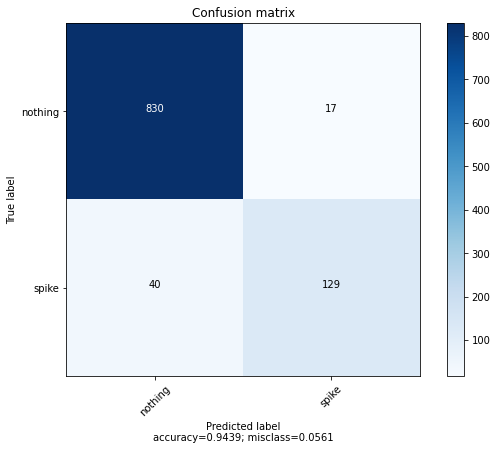


 0.8026315789473685 

 60%|█████▉    | 119/200 [22:49<19:58, 14.80s/it, best loss: -0.8348909657320872]

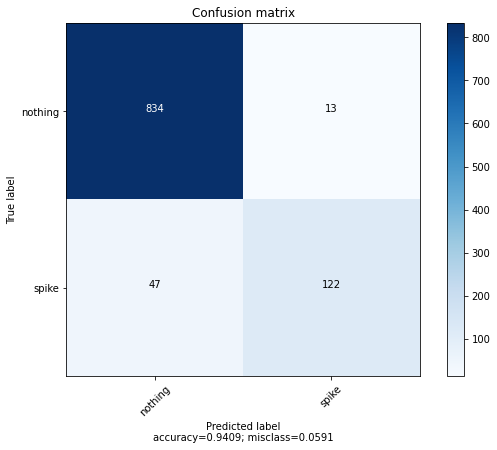


 0.8208469055374593 

 60%|██████    | 120/200 [23:05<21:30, 16.13s/it, best loss: -0.8348909657320872]

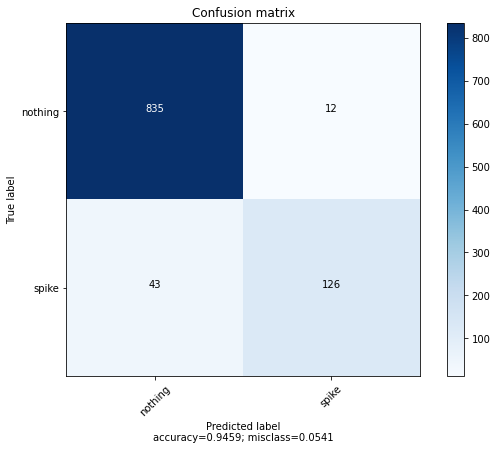


 0.8198757763975155 

 60%|██████    | 121/200 [23:19<20:56, 15.91s/it, best loss: -0.8348909657320872]

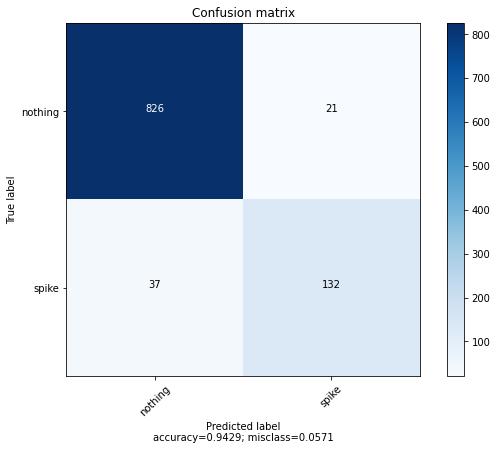


 0.7934426229508197 

 61%|██████    | 122/200 [23:29<20:11, 15.53s/it, best loss: -0.8348909657320872]

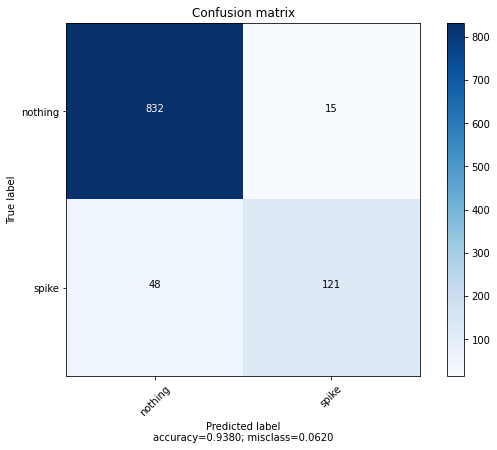


 0.7908496732026143 

 62%|██████▏   | 123/200 [23:46<17:37, 13.73s/it, best loss: -0.8348909657320872]

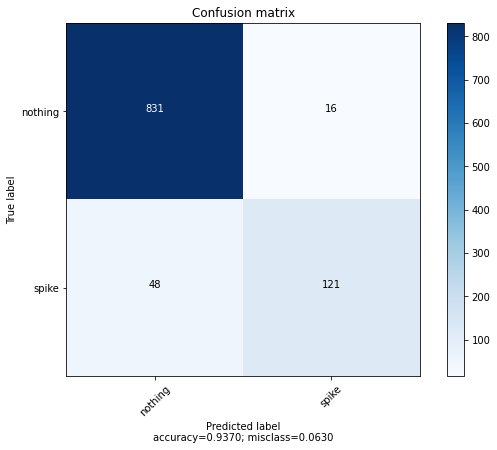


 0.7880794701986755 

 62%|██████▏   | 124/200 [24:00<18:53, 14.91s/it, best loss: -0.8348909657320872]

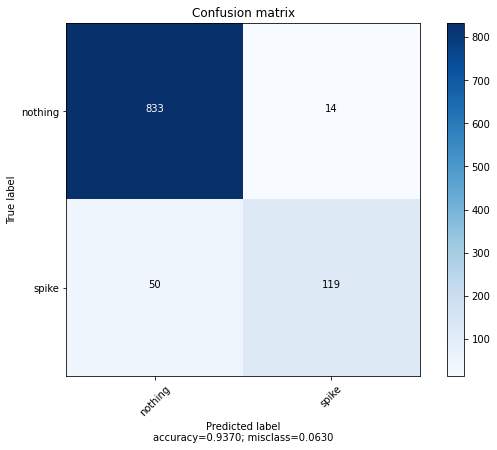


 0.8129032258064516 

 62%|██████▎   | 125/200 [24:12<18:19, 14.67s/it, best loss: -0.8348909657320872]

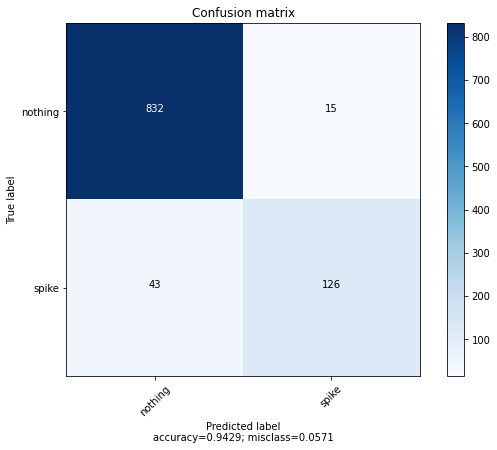


 0.8125000000000001 

 63%|██████▎   | 126/200 [24:21<16:50, 13.65s/it, best loss: -0.8348909657320872]

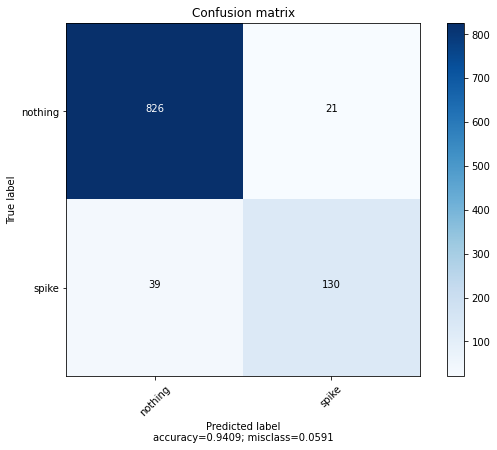


 0.7987012987012987 

 64%|██████▎   | 127/200 [24:40<14:53, 12.24s/it, best loss: -0.8348909657320872]

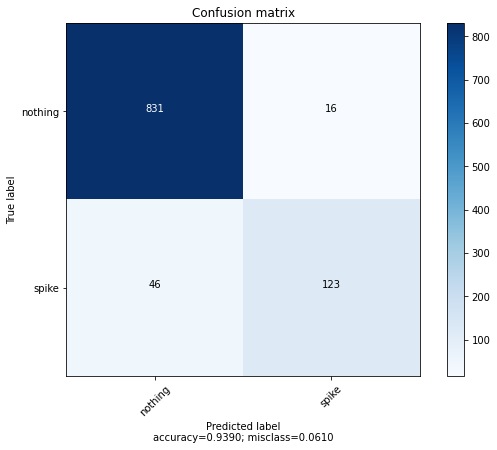


 0.7652173913043478 

 64%|██████▍   | 128/200 [24:43<17:22, 14.48s/it, best loss: -0.8348909657320872]

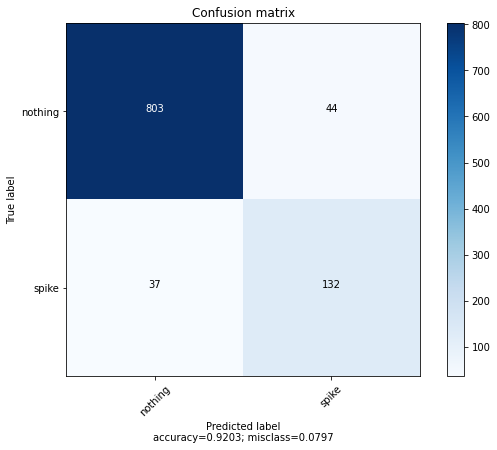


 0.7933333333333332 

 64%|██████▍   | 129/200 [24:52<12:48, 10.82s/it, best loss: -0.8348909657320872]

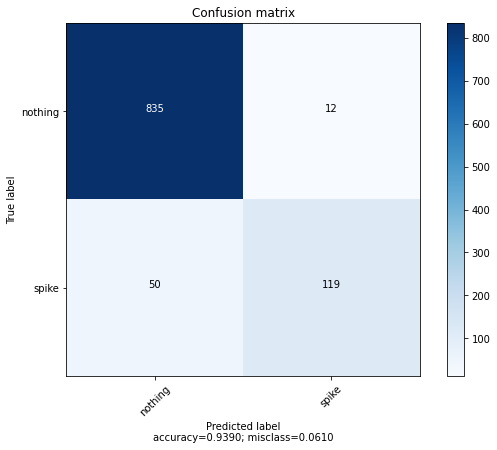


 0.8087774294670846 

 65%|██████▌   | 130/200 [25:02<12:00, 10.30s/it, best loss: -0.8348909657320872]

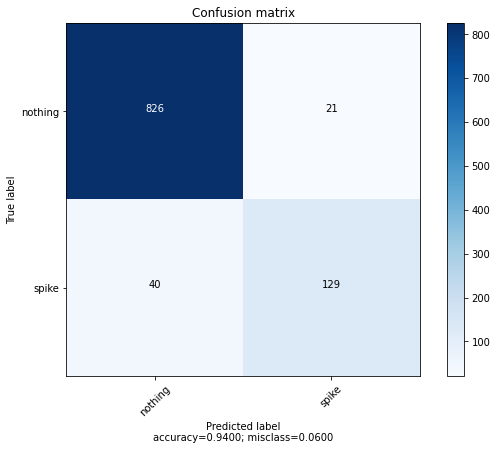


 0.801261829652997 

 66%|██████▌   | 131/200 [25:09<11:45, 10.22s/it, best loss: -0.8348909657320872]

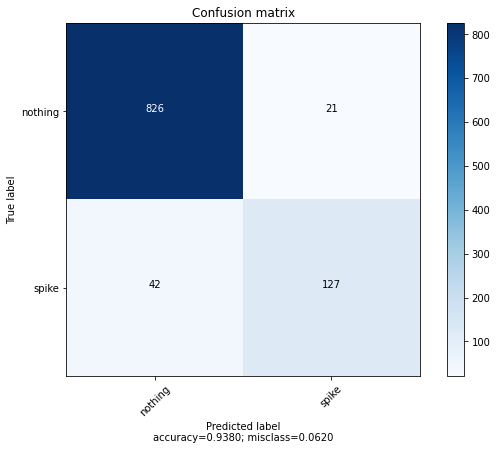


 0.8242811501597445 

 66%|██████▌   | 132/200 [25:23<10:38,  9.38s/it, best loss: -0.8348909657320872]

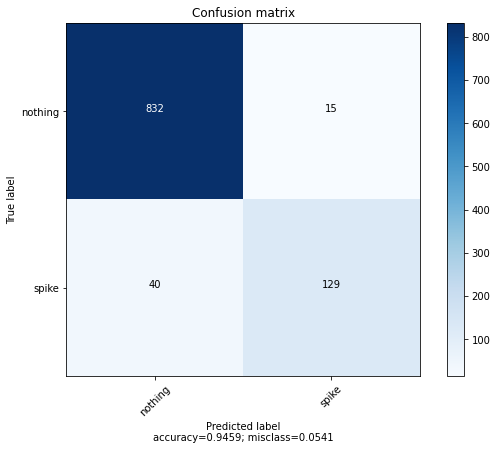


 0.8025078369905957 

 66%|██████▋   | 133/200 [25:33<11:46, 10.54s/it, best loss: -0.8348909657320872]

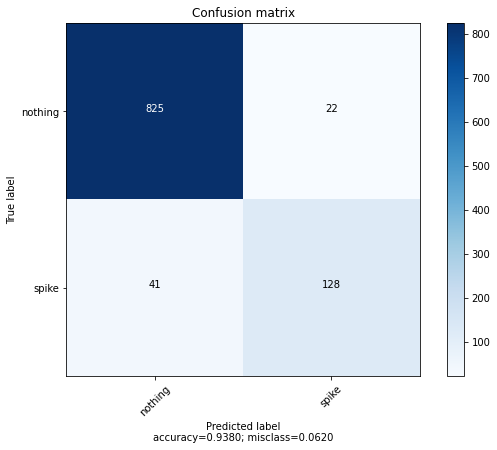


 0.7707006369426751 

 67%|██████▋   | 134/200 [25:38<11:27, 10.42s/it, best loss: -0.8348909657320872]

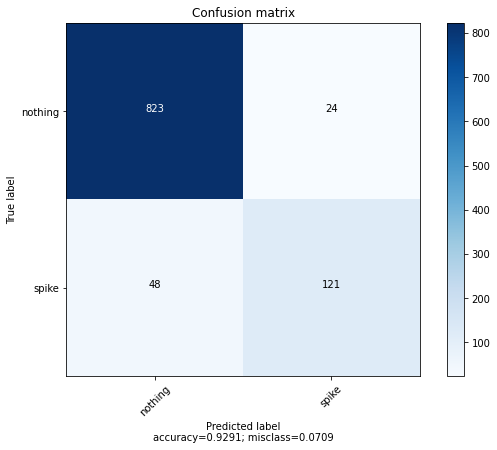


 0.8178913738019169 

 68%|██████▊   | 135/200 [25:58<09:42,  8.96s/it, best loss: -0.8348909657320872]

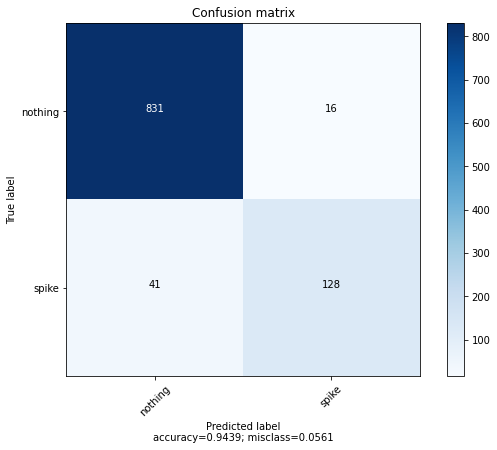


 0.8098159509202454 

 68%|██████▊   | 136/200 [26:02<13:05, 12.27s/it, best loss: -0.8348909657320872]

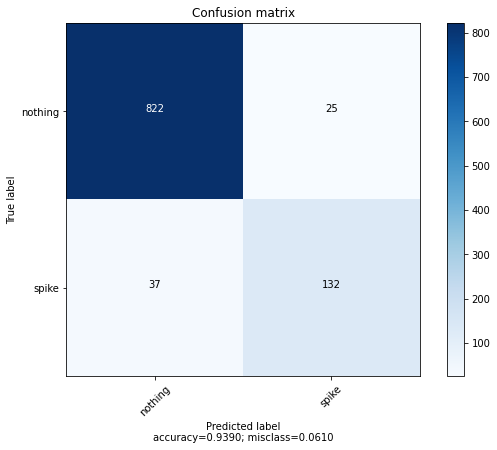


 0.8102893890675241 

 68%|██████▊   | 137/200 [26:23<10:17,  9.79s/it, best loss: -0.8348909657320872]

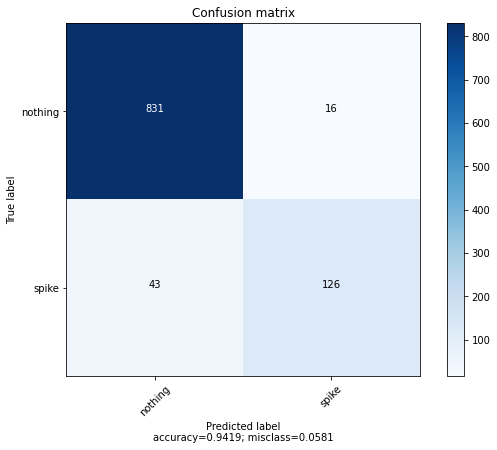


 0.8220064724919094 

 69%|██████▉   | 138/200 [26:39<13:24, 12.97s/it, best loss: -0.8348909657320872]

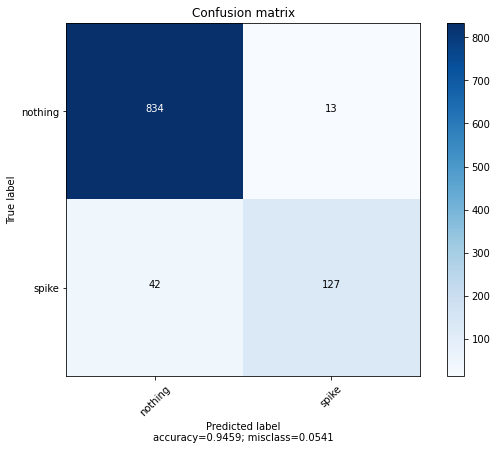


 0.8246753246753247 

 70%|██████▉   | 139/200 [26:55<14:06, 13.87s/it, best loss: -0.8348909657320872]

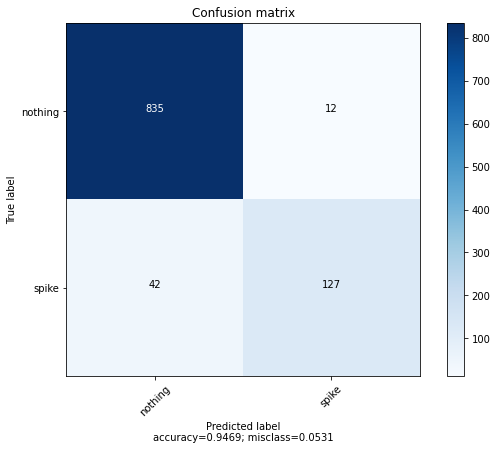


 0.803921568627451 

 70%|███████   | 140/200 [27:12<14:41, 14.69s/it, best loss: -0.8348909657320872]

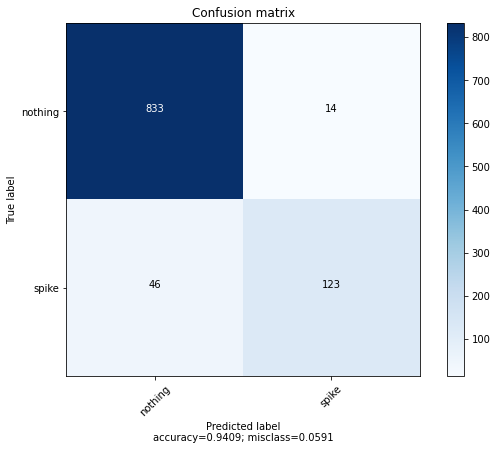


 0.8063492063492064 

 70%|███████   | 141/200 [27:27<14:58, 15.23s/it, best loss: -0.8348909657320872]

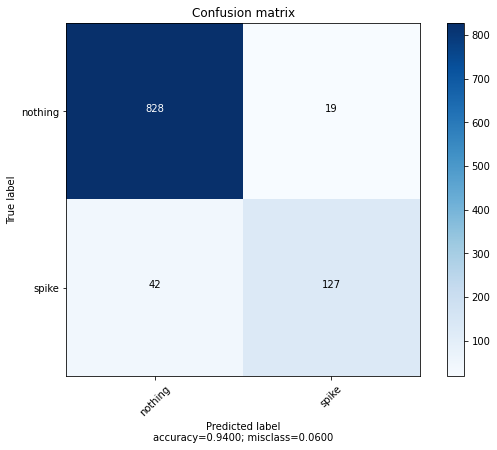


 0.7908496732026143 

 71%|███████   | 142/200 [27:42<14:48, 15.32s/it, best loss: -0.8348909657320872]

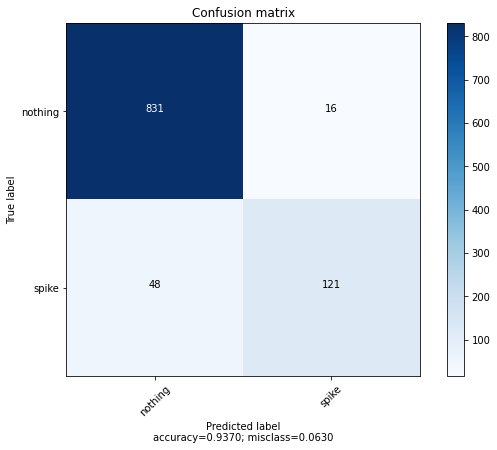


 0.7419354838709676 

 72%|███████▏  | 143/200 [27:45<14:16, 15.03s/it, best loss: -0.8348909657320872]

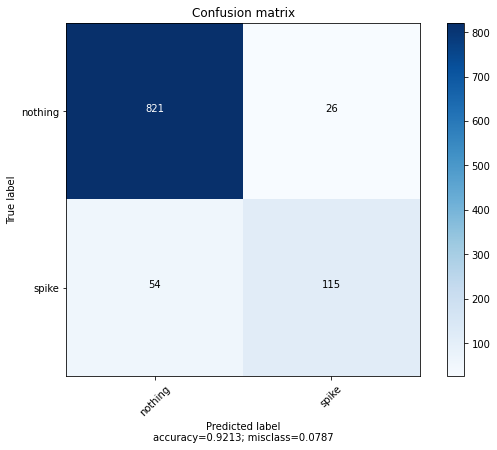


 0.8282208588957056 

 72%|███████▏  | 144/200 [27:57<10:45, 11.52s/it, best loss: -0.8348909657320872]

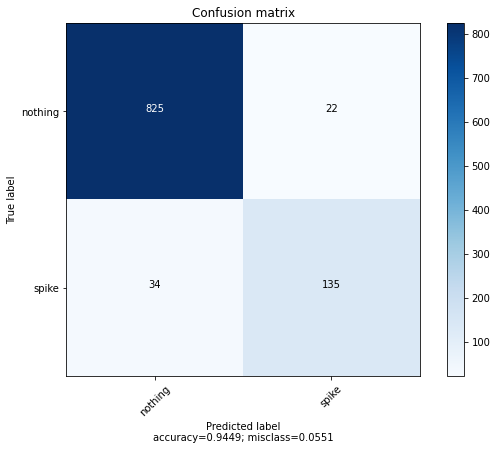


 0.8284789644012944 

 72%|███████▎  | 145/200 [28:15<10:43, 11.71s/it, best loss: -0.8348909657320872]

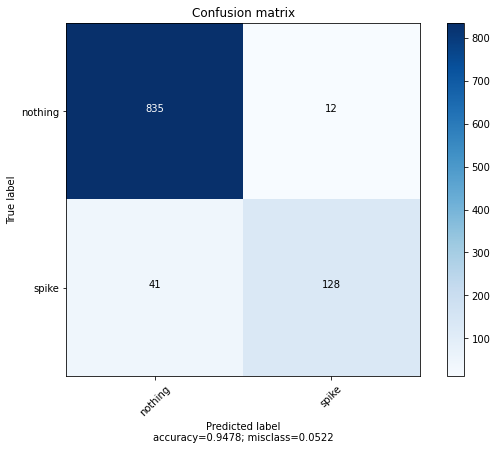


 0.8115015974440896 

 73%|███████▎  | 146/200 [28:32<12:15, 13.62s/it, best loss: -0.8348909657320872]

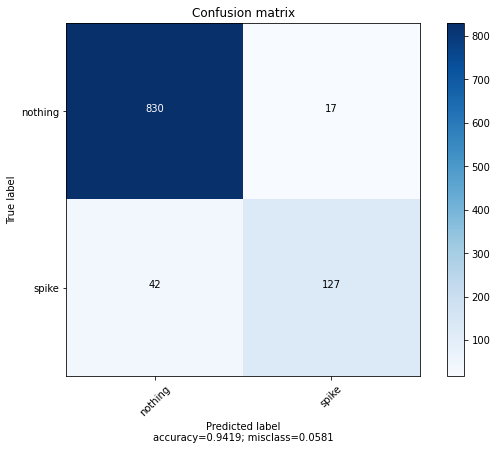


 0.80625 

 74%|███████▎  | 147/200 [28:50<12:57, 14.67s/it, best loss: -0.8348909657320872]

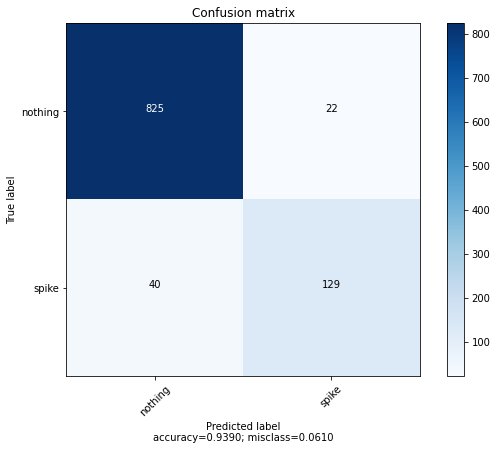


 0.8064516129032259 

 74%|███████▍  | 148/200 [29:08<13:28, 15.56s/it, best loss: -0.8348909657320872]

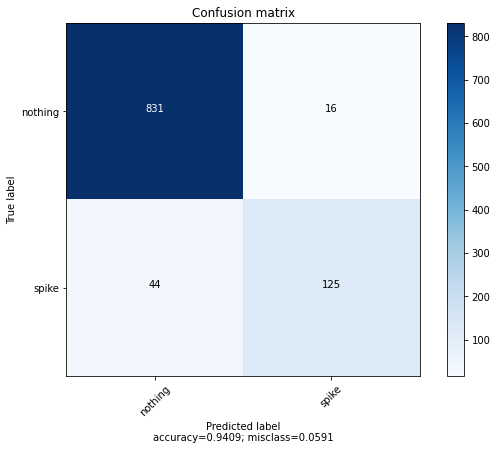


 0.8269230769230769 

 74%|███████▍  | 149/200 [29:23<13:57, 16.43s/it, best loss: -0.8348909657320872]

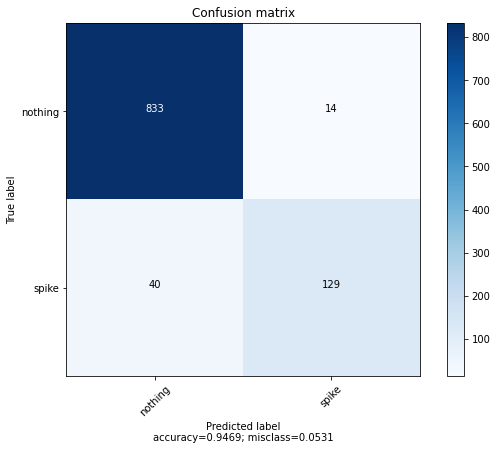


 0.8104575163398693 

 75%|███████▌  | 150/200 [29:40<13:17, 15.95s/it, best loss: -0.8348909657320872]

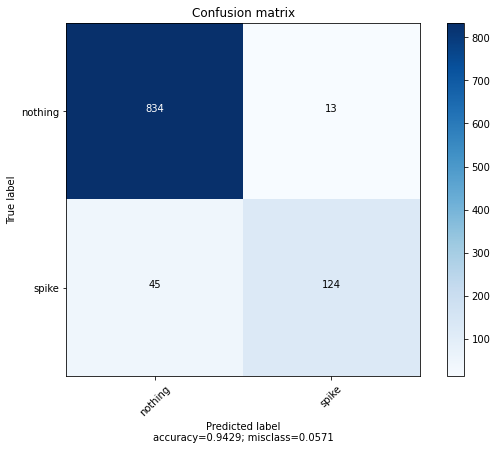


 0.8013029315960913 

 76%|███████▌  | 151/200 [29:56<13:12, 16.16s/it, best loss: -0.8348909657320872]

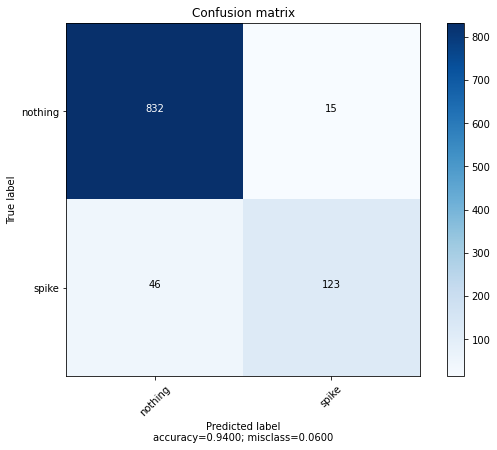


 0.8013029315960913 

 76%|███████▌  | 152/200 [30:23<12:51, 16.07s/it, best loss: -0.8348909657320872]

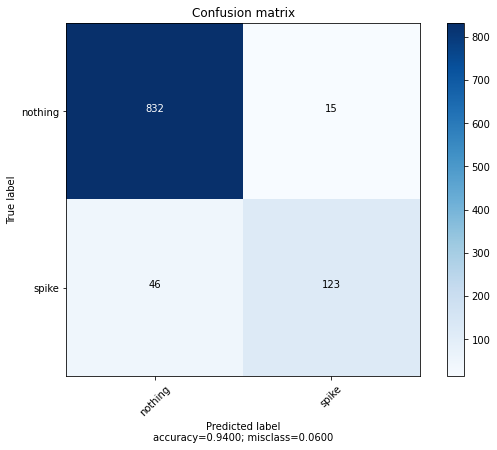


 0.8169934640522875 

 76%|███████▋  | 153/200 [30:41<15:09, 19.36s/it, best loss: -0.8348909657320872]

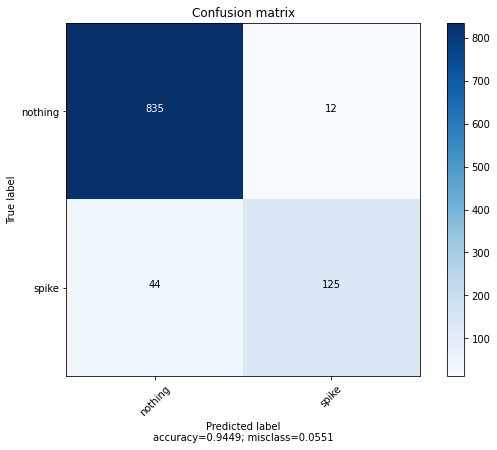


 0.8131147540983605 

 77%|███████▋  | 154/200 [31:00<14:34, 19.01s/it, best loss: -0.8348909657320872]

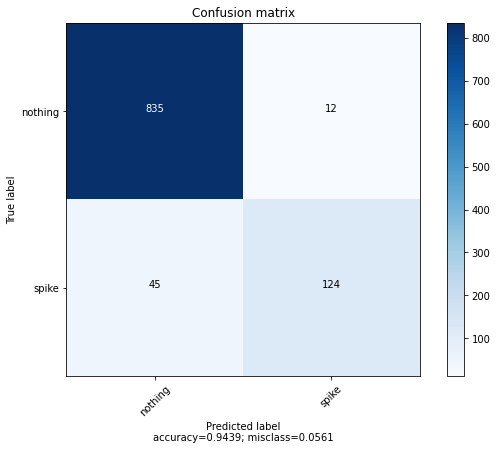


 0.8205128205128205 

 78%|███████▊  | 155/200 [31:19<14:12, 18.94s/it, best loss: -0.8348909657320872]

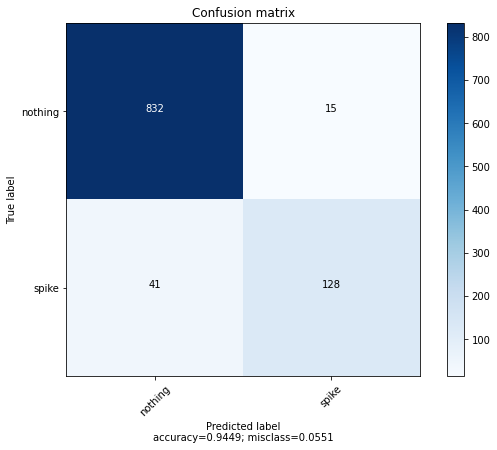


 0.8178913738019169 

 78%|███████▊  | 156/200 [31:37<13:58, 19.06s/it, best loss: -0.8348909657320872]

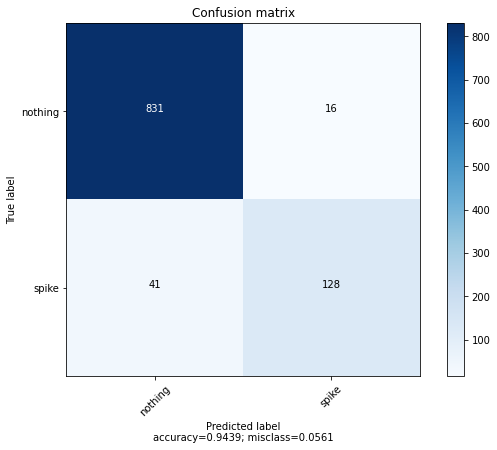


 0.79375 

 78%|███████▊  | 157/200 [31:51<13:21, 18.64s/it, best loss: -0.8348909657320872]

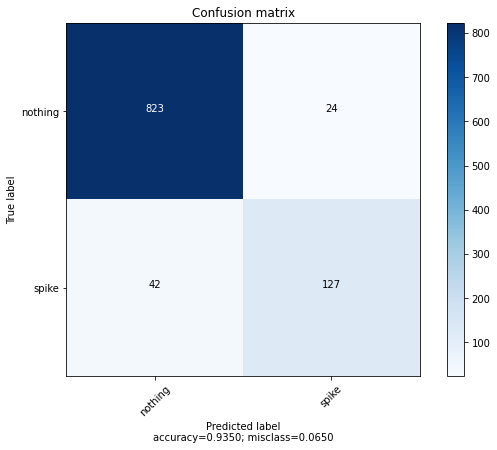


 0.8090614886731392 

 79%|███████▉  | 158/200 [32:00<12:07, 17.32s/it, best loss: -0.8348909657320872]

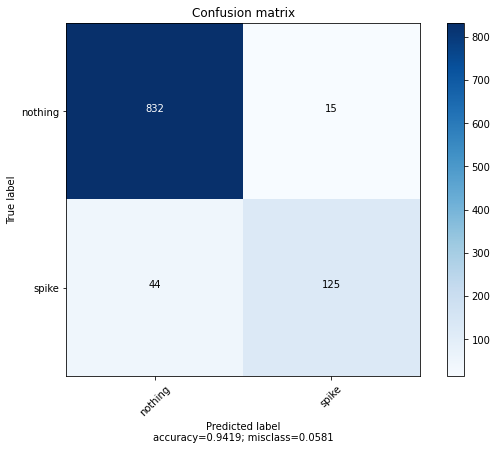


 0.8253968253968255 

 80%|███████▉  | 159/200 [32:19<10:10, 14.88s/it, best loss: -0.8348909657320872]

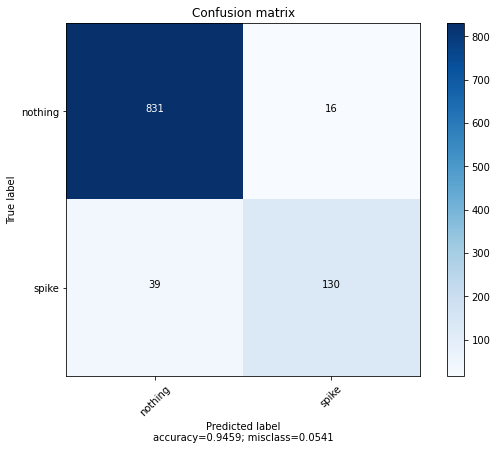


 0.8051948051948051 

 80%|████████  | 160/200 [32:36<10:45, 16.13s/it, best loss: -0.8348909657320872]

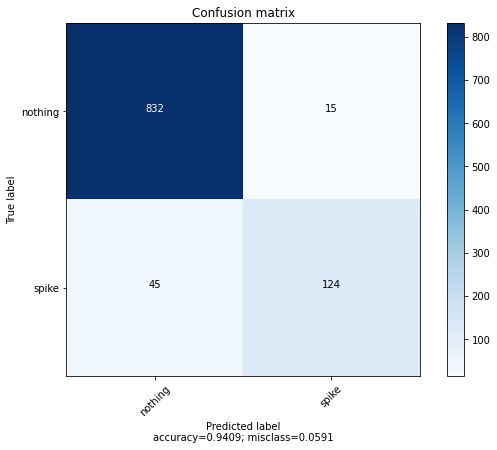


 0.803921568627451 

 80%|████████  | 161/200 [32:51<10:38, 16.37s/it, best loss: -0.8348909657320872]

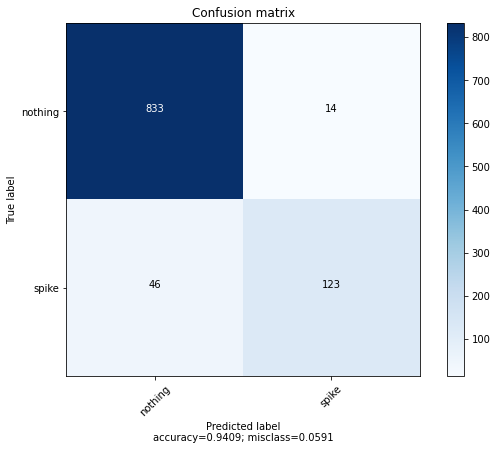


 0.8133333333333332 

 81%|████████  | 162/200 [33:02<10:07, 15.97s/it, best loss: -0.8348909657320872]

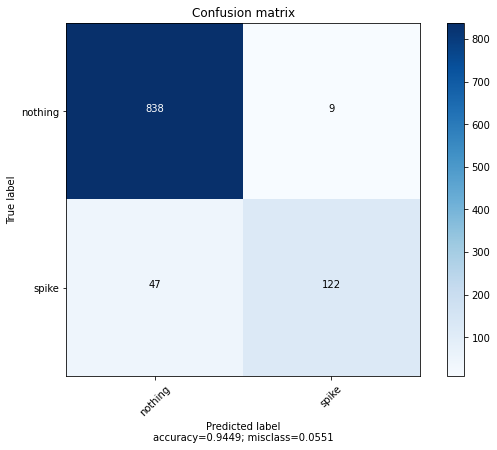


 0.802547770700637 

 82%|████████▏ | 163/200 [33:09<08:56, 14.49s/it, best loss: -0.8348909657320872]

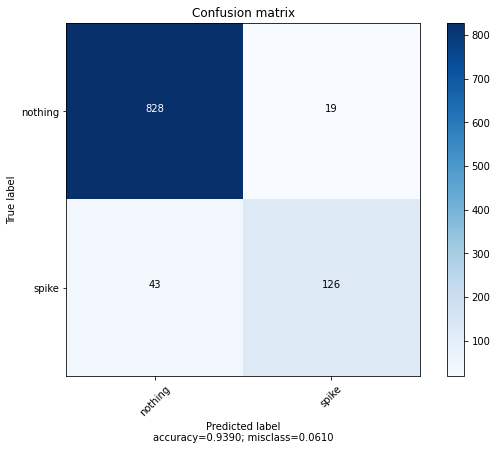


 0.8198757763975155 

 82%|████████▏ | 164/200 [33:24<07:19, 12.22s/it, best loss: -0.8348909657320872]

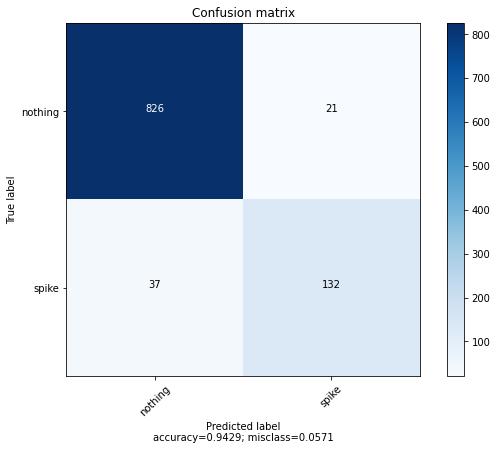


 0.8143322475570032 

 82%|████████▎ | 165/200 [33:42<07:40, 13.16s/it, best loss: -0.8348909657320872]

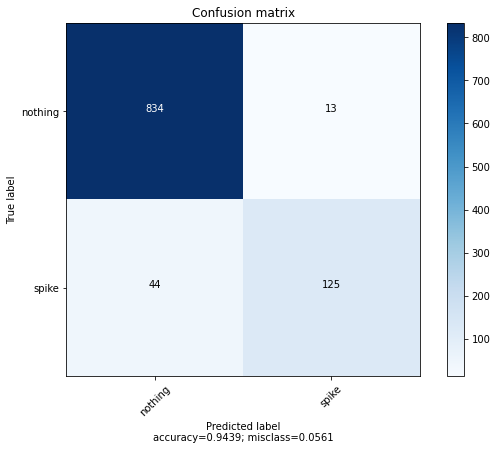


 0.8115015974440896 

 83%|████████▎ | 166/200 [34:00<08:07, 14.35s/it, best loss: -0.8348909657320872]

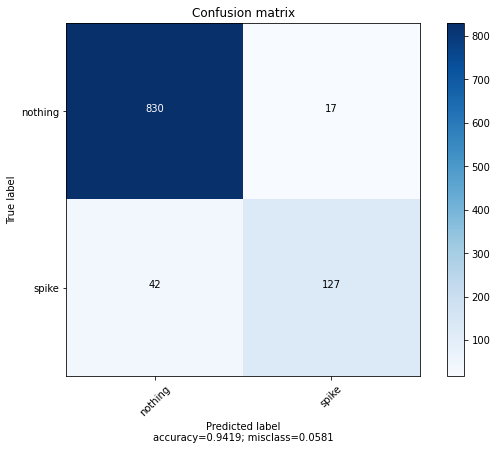


 0.802675585284281 

 84%|████████▎ | 167/200 [34:11<08:36, 15.67s/it, best loss: -0.8348909657320872]

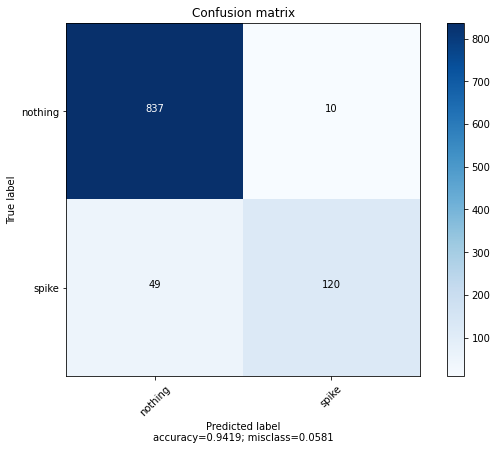


 0.8026315789473685 

 84%|████████▍ | 168/200 [34:30<07:32, 14.15s/it, best loss: -0.8348909657320872]

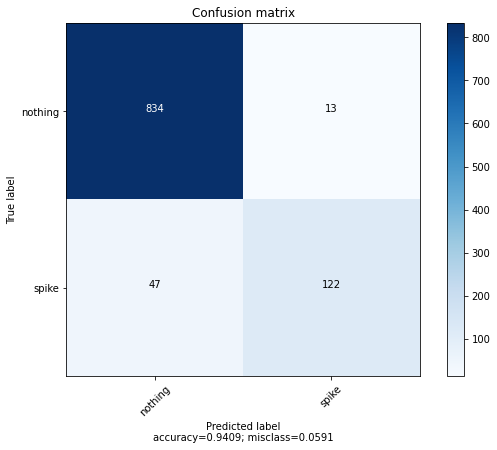


 0.7834394904458598 

 84%|████████▍ | 169/200 [34:42<08:01, 15.54s/it, best loss: -0.8348909657320872]

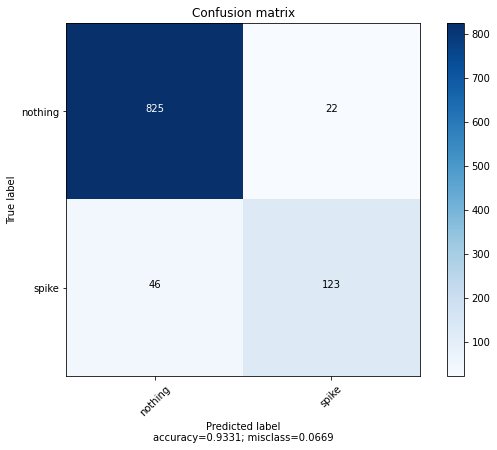


 0.8173374613003095 

 85%|████████▌ | 170/200 [34:53<07:16, 14.55s/it, best loss: -0.8348909657320872]

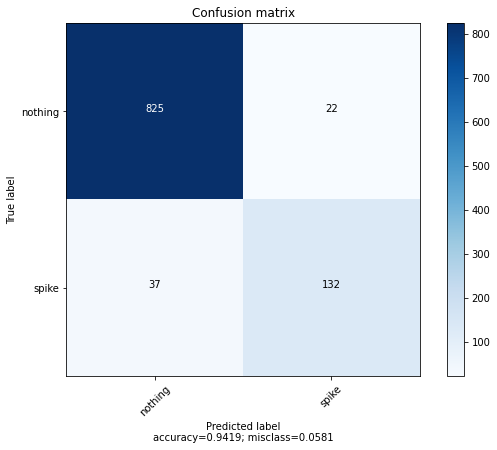


 0.8253968253968255 

 86%|████████▌ | 171/200 [35:07<06:28, 13.39s/it, best loss: -0.8348909657320872]

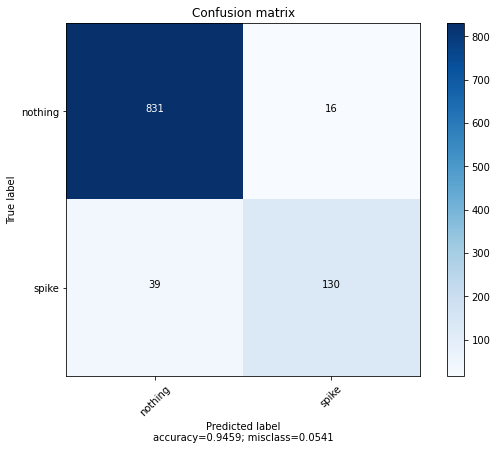


 0.805111821086262 

 86%|████████▌ | 172/200 [35:13<06:27, 13.85s/it, best loss: -0.8348909657320872]

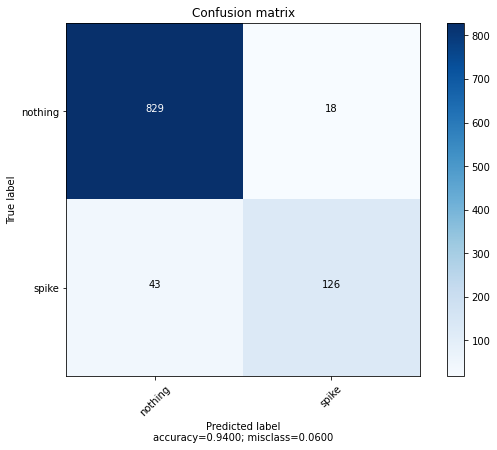


 0.7962382445141065 

 86%|████████▋ | 173/200 [35:30<05:05, 11.32s/it, best loss: -0.8348909657320872]

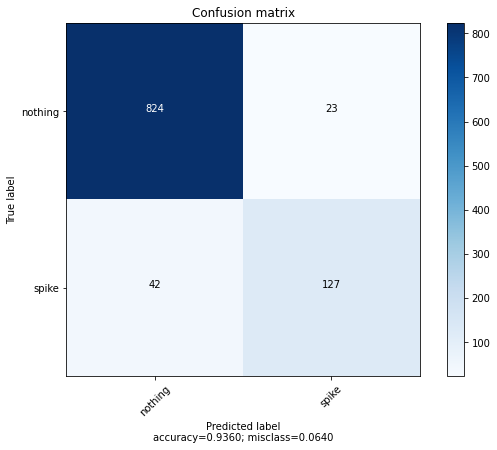


 0.810126582278481 

 87%|████████▋ | 174/200 [35:47<05:37, 12.99s/it, best loss: -0.8348909657320872]

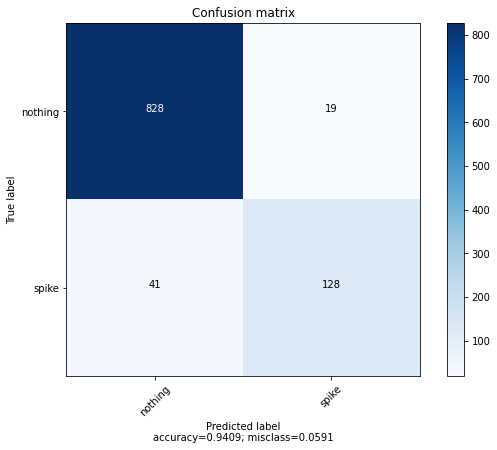


 0.7986798679867988 

 88%|████████▊ | 175/200 [35:58<05:55, 14.21s/it, best loss: -0.8348909657320872]

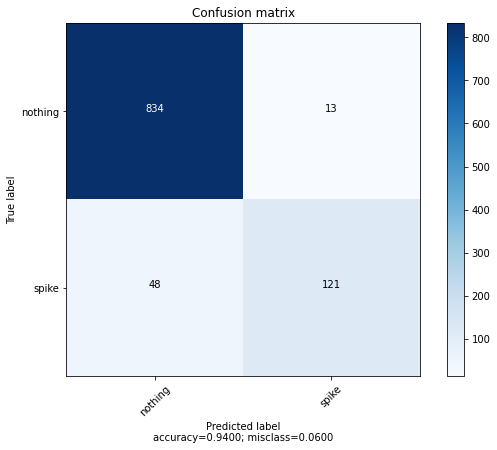


 0.8227848101265822 

 88%|████████▊ | 176/200 [36:05<05:16, 13.18s/it, best loss: -0.8348909657320872]

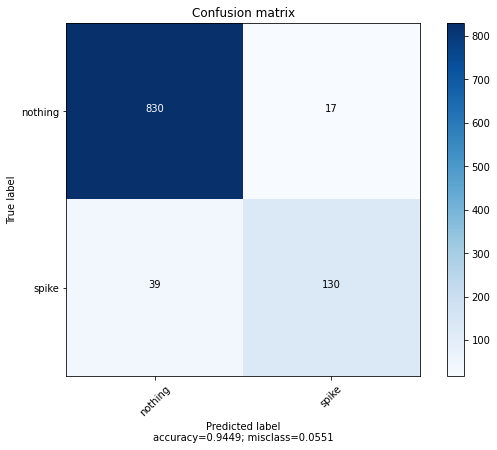


 0.8126984126984127 

 88%|████████▊ | 177/200 [36:20<04:26, 11.58s/it, best loss: -0.8348909657320872]

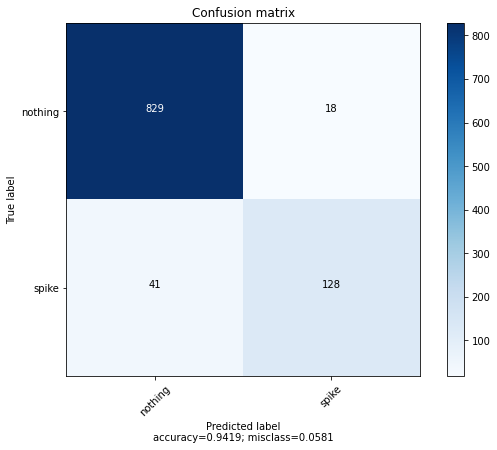


 0.7257617728531854 

 89%|████████▉ | 178/200 [36:23<04:33, 12.41s/it, best loss: -0.8348909657320872]

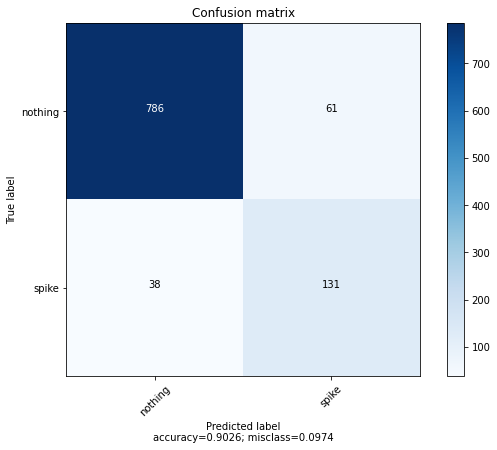


 0.8172757475083057 

 90%|████████▉ | 179/200 [36:34<03:22,  9.65s/it, best loss: -0.8348909657320872]

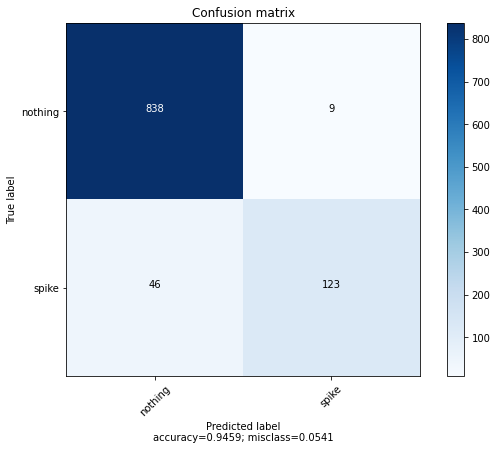


 0.821656050955414 

 90%|█████████ | 180/200 [36:48<03:21, 10.08s/it, best loss: -0.8348909657320872]

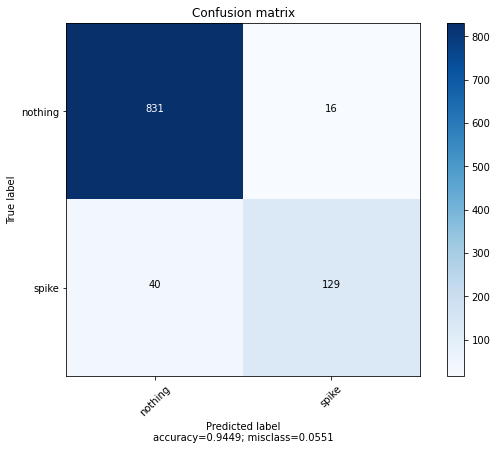


 0.8098159509202454 

 90%|█████████ | 181/200 [36:53<03:31, 11.14s/it, best loss: -0.8348909657320872]

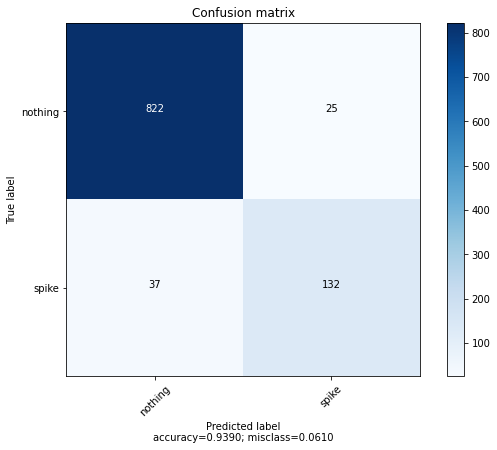


 0.7875000000000001 

 91%|█████████ | 182/200 [37:03<02:48,  9.38s/it, best loss: -0.8348909657320872]

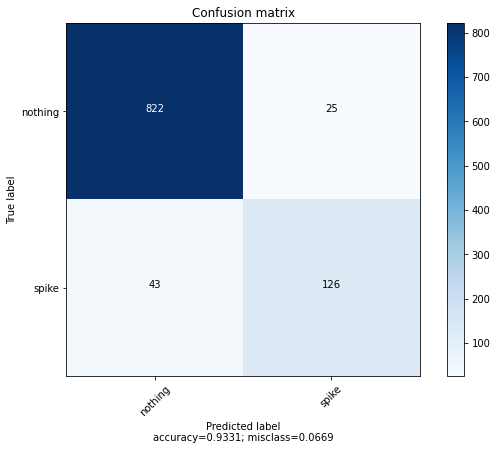


 0.8063492063492064 

 92%|█████████▏| 183/200 [37:16<02:41,  9.49s/it, best loss: -0.8348909657320872]

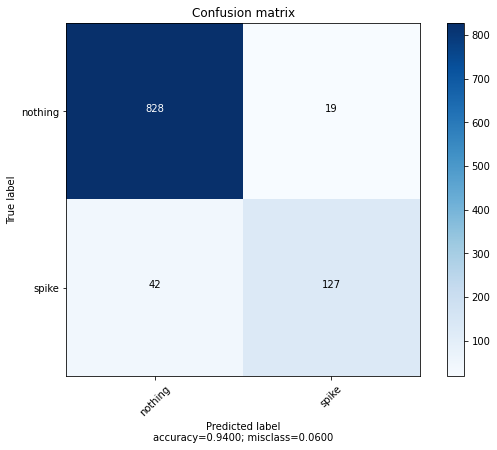


 0.813664596273292 

 92%|█████████▏| 184/200 [37:26<02:49, 10.57s/it, best loss: -0.8348909657320872]

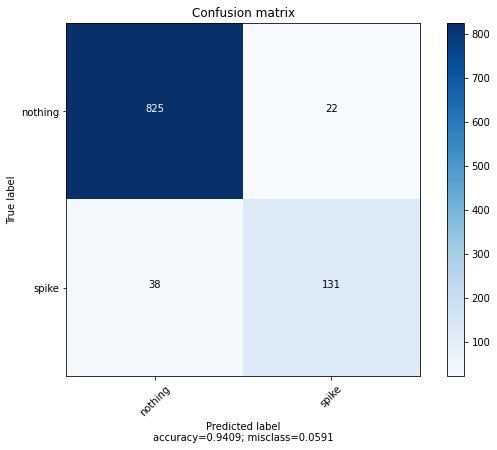


 0.8026315789473685 

 92%|█████████▎| 185/200 [37:45<02:37, 10.49s/it, best loss: -0.8348909657320872]

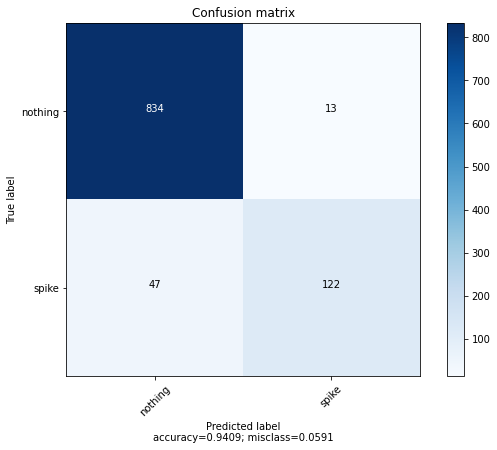


 0.8078175895765473 

 93%|█████████▎| 186/200 [37:59<03:01, 12.99s/it, best loss: -0.8348909657320872]

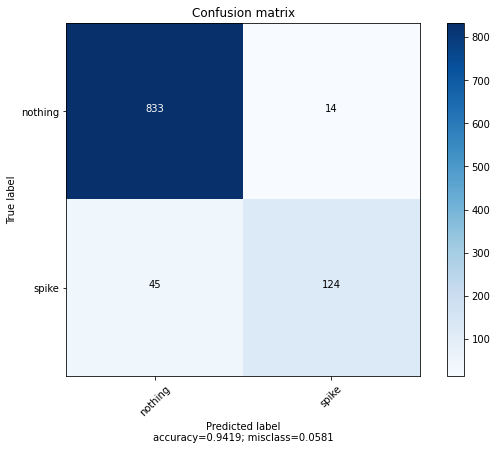


 0.7928994082840237 

 94%|█████████▎| 187/200 [38:06<02:54, 13.45s/it, best loss: -0.8348909657320872]

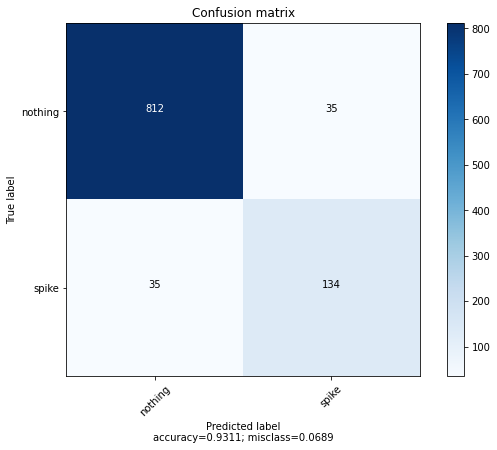


 0.801261829652997 

 94%|█████████▍| 188/200 [38:21<02:15, 11.27s/it, best loss: -0.8348909657320872]

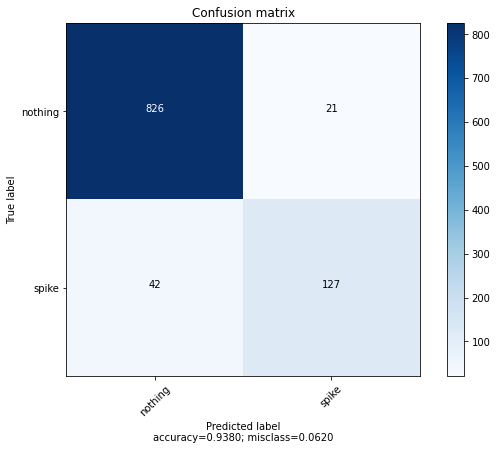


 0.8317460317460317 

 94%|█████████▍| 189/200 [38:33<02:17, 12.53s/it, best loss: -0.8348909657320872]

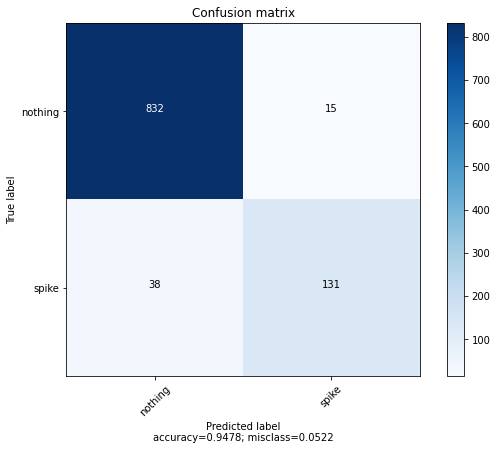


 0.8121212121212121 

 95%|█████████▌| 190/200 [38:41<02:02, 12.23s/it, best loss: -0.8348909657320872]

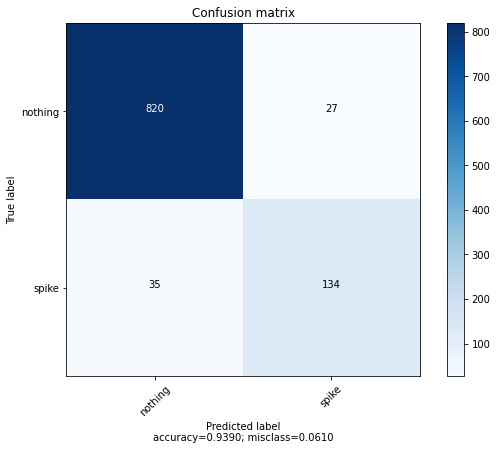


 0.8111455108359134 

 96%|█████████▌| 191/200 [38:48<01:38, 10.92s/it, best loss: -0.8348909657320872]

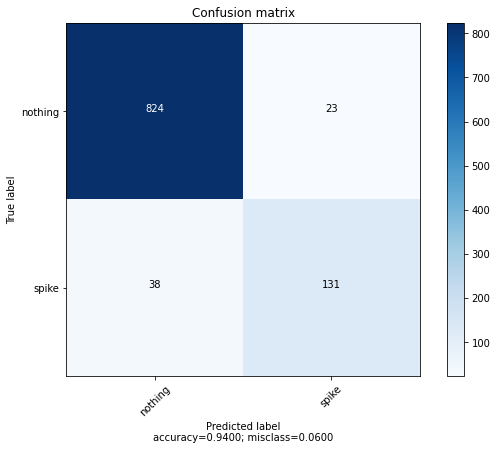


 0.7987421383647797 

 96%|█████████▌| 192/200 [38:59<01:19,  9.99s/it, best loss: -0.8348909657320872]

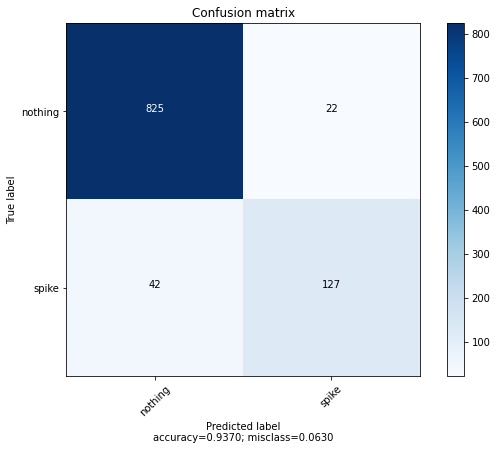


 0.7926829268292683 

 96%|█████████▋| 193/200 [39:05<01:10, 10.04s/it, best loss: -0.8348909657320872]

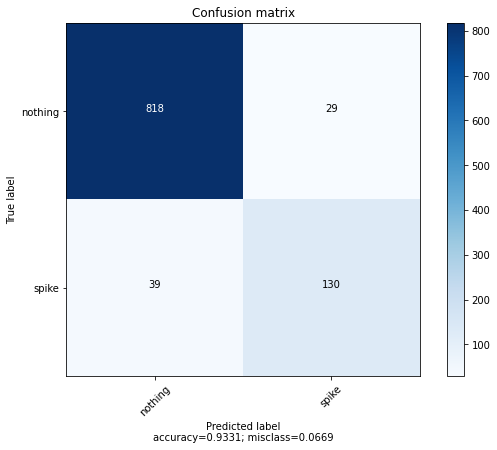


 0.8075709779179812 

 97%|█████████▋| 194/200 [39:16<00:53,  9.00s/it, best loss: -0.8348909657320872]

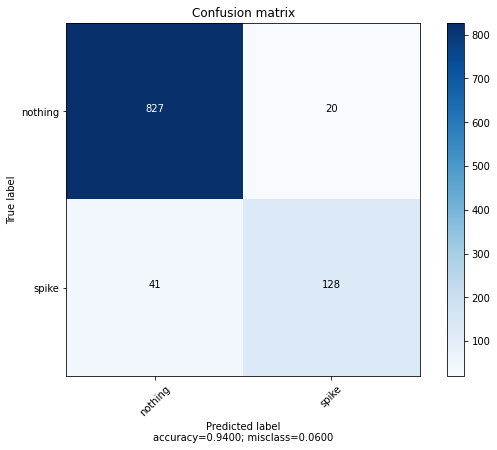


 0.80625 

 98%|█████████▊| 195/200 [39:25<00:48,  9.63s/it, best loss: -0.8348909657320872]

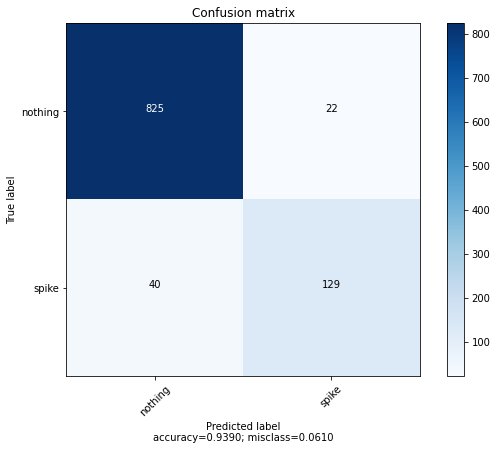


 0.7857142857142857 

 98%|█████████▊| 196/200 [39:29<00:38,  9.52s/it, best loss: -0.8348909657320872]

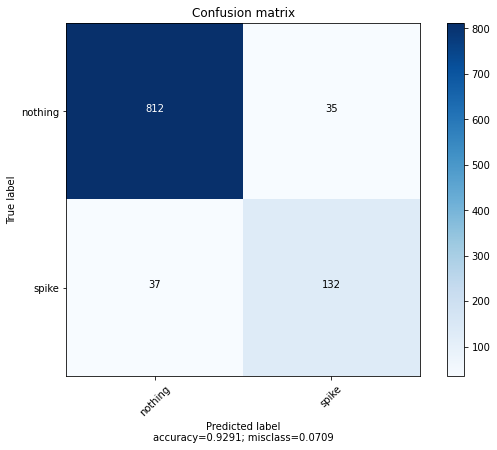


 0.821656050955414 

 98%|█████████▊| 197/200 [39:36<00:23,  7.69s/it, best loss: -0.8348909657320872]

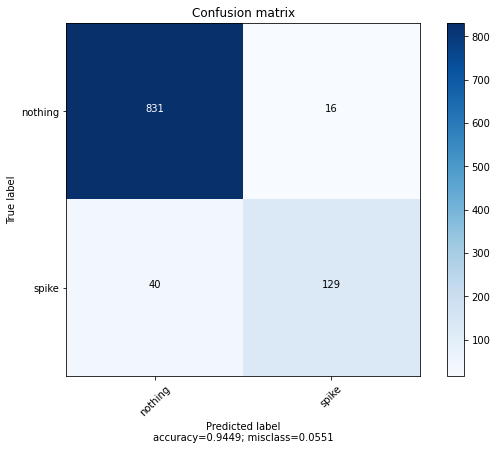


 0.8076923076923078 

 99%|█████████▉| 198/200 [39:42<00:15,  7.62s/it, best loss: -0.8348909657320872]

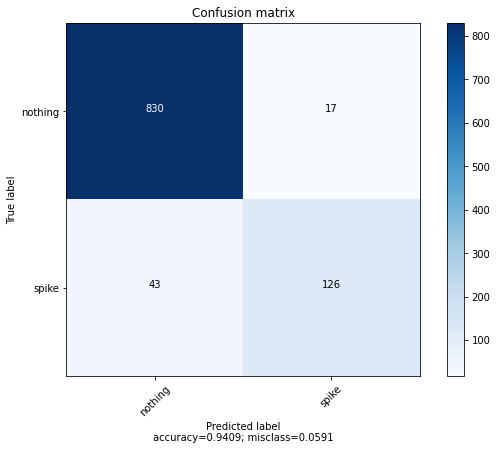


 0.7999999999999999 

100%|█████████▉| 199/200 [39:46<00:06,  6.99s/it, best loss: -0.8348909657320872]

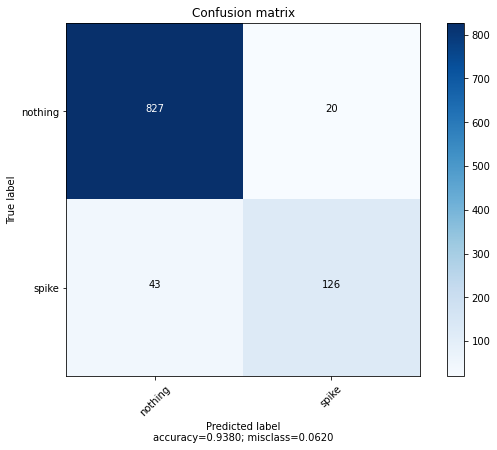

100%|██████████| 200/200 [39:47<00:00, 11.94s/it, best loss: -0.8348909657320872]

 
 2387.0355298519135


In [38]:
rosemary = Tuner()
rosemary.process_data( )
rosemary.classifier_to_tune( 'LGB' )

hhh = HPOpt( rosemary )
start = time.time()
best_params, trials_obj = hhh.process( fn_name = 'objective', space = SPACE, trials = Trials(), algo = tpe.suggest, max_evals = 200 ) #max_evals will be increased
print( '\n \n {}'.format( time.time() - start ) )


In [39]:
rosemary = Tuner()
rosemary.choose_classifier( 'LGB' )
rosemary.best_params = best_params 
cash, gt, pred = rosemary.train_tuned()


 PREPROCESSING 


 DEFINING CLASSES 

 
 ============SCORE============ 
 0.16666666666666669


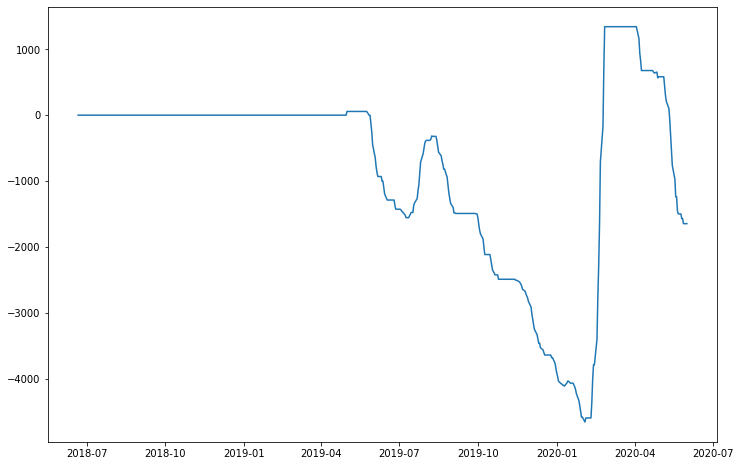

In [40]:
plt.figure( figsize = (12,8) )
plt.plot(rosemary.TEST_DATES, cash[ 13 : ] )

#Son konuştuğumuz gibi, tüm dataya train test split, smotetomek, hyperparameter tuning, train_test split for btest, smotetomek, train with b_params, test

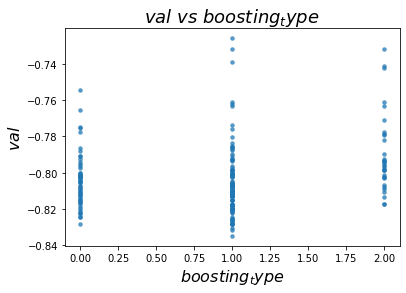

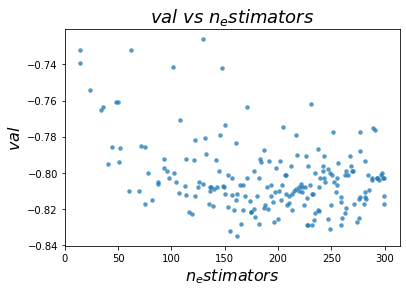

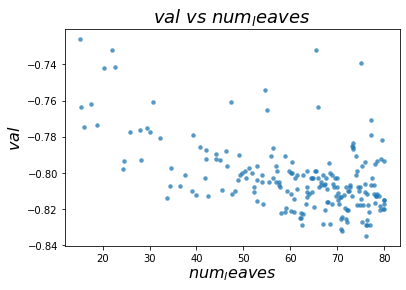

In [41]:
keyz = list(best_params.keys())
for key in keyz:
    plot_loss_vs_param( key )

#LOSS VS HP



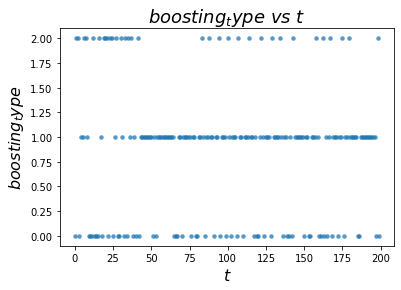

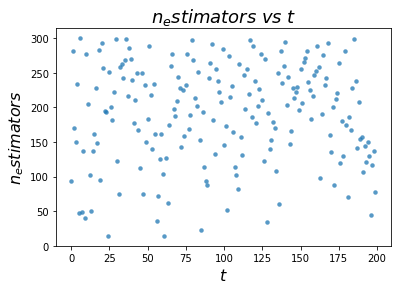

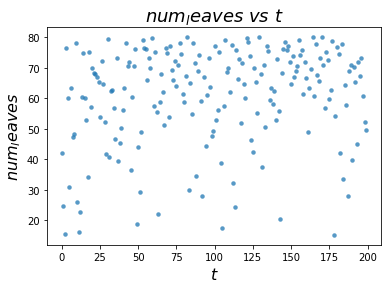

In [42]:

for key in keyz:
    plot_param_vs_time( key )
#HP VS TIME

In [44]:
for key in list(rosemary.data.keys()):
    print(key)

SPX-T-1
USD Index-T-1
VIX-T-1
Gold-T-1
Oil-T-1
Nikkei-T-1
Dax-T-1
10Yr-T-1
2Yr-T-1
EEM-T-1
High Yield Fund-T-1
XLE-T-1
XLF-T-1
XLI-T-1
AUDJPY-T-1
SPX-RSI-T-1
BBU-Distance-T-1
BBL-Distance-T-1
MACD-Histogram-T-1
SPX-T-3
USD Index-T-3
VIX-T-3
Gold-T-3
Oil-T-3
Nikkei-T-3
Dax-T-3
10Yr-T-3
2Yr-T-3
EEM-T-3
High Yield Fund-T-3
XLE-T-3
XLF-T-3
XLI-T-3
AUDJPY-T-3
SPX-RSI-T-3
BBU-Distance-T-3
BBL-Distance-T-3
MACD-Histogram-T-3
SPX-T-5
USD Index-T-5
VIX-T-5
Gold-T-5
Oil-T-5
Nikkei-T-5
Dax-T-5
10Yr-T-5
2Yr-T-5
EEM-T-5
High Yield Fund-T-5
XLE-T-5
XLF-T-5
XLI-T-5
AUDJPY-T-5
SPX-RSI-T-5
BBU-Distance-T-5
BBL-Distance-T-5
MACD-Histogram-T-5
SPX-T-14
USD Index-T-14
VIX-T-14
Gold-T-14
Oil-T-14
Nikkei-T-14
Dax-T-14
10Yr-T-14
2Yr-T-14
EEM-T-14
High Yield Fund-T-14
XLE-T-14
XLF-T-14
XLI-T-14
AUDJPY-T-14
SPX-RSI-T-14
BBU-Distance-T-14
BBL-Distance-T-14
MACD-Histogram-T-14
SPX-T-21
USD Index-T-21
VIX-T-21
Gold-T-21
Oil-T-21
Nikkei-T-21
Dax-T-21
10Yr-T-21
2Yr-T-21
EEM-T-21
High Yield Fund-T-21
XLE-T-21
XLF-T-